In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import pandas as pd
from torch.autograd import Variable
import re
import numpy as np
from PIL import Image

import sys
import os
sys.path.append("../NephNet")
import argparse
import torch
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from train import get_instance

from trainer.trainer_vae import TrainerVAE as Trainer
from utils import Logger
from utils import util
from utils import torchsummary
from utils import transforms3d as t3d
import torch.nn.init as init

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\tqdm\autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


Modules loaded


In [176]:
#Create a data loader
config_text = "C:/Users/awoloshu/Documents/NephNet/configs/config_VAE.json"
#config_text = "C:/Users/awoloshu/Documents/NephNet/configs/config_VAE_mask.json"
with open(config_text) as handle:
    config = json.load(handle)
# setting path to save trained models and log files
path = os.path.join(config['trainer']['save_dir'], config['name'])

#model = get_instance(module_arch, 'arch', config)
torch.backends.cudnn.benchmark = True
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["NUMEXPR_MAX_THREADS"] = "16"
print("GPUs available: " + str(torch.cuda.device_count()))
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
train_logger = Logger()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# setup data_loader instances
data_loader = get_instance(module_data, 'data_loader', config)
valid_data_loader = data_loader.split_validation()

if torch.cuda.is_available():
    print("Using GPU: " + torch.cuda.get_device_name(0))
else:
    print("Using CPU to train")

# get function handles of loss and metrics
loss = getattr(module_loss, config['loss']) #looks in model/loss.py for criterion function specified in config
criterion = loss(data_loader.dataset.weight.to(device)) # for imbalanced datasets
metrics = [getattr(module_metric, met) for met in config['metrics']]

# build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
if config['optimizer']['type'] == "adabound":
    optimizer = getattr(adabound, "AdaBound")(trainable_params, **config['optimizer']['args'])
else:
    optimizer = get_instance(torch.optim, 'optimizer', config, trainable_params)
lr_scheduler = get_instance(torch.optim.lr_scheduler, 'lr_scheduler', config, optimizer)

GPUs available: 1
Using GPU: GeForce RTX 2080 Ti


torch.Size([64, 1, 7, 32, 32])


<IPython.core.display.Javascript object>


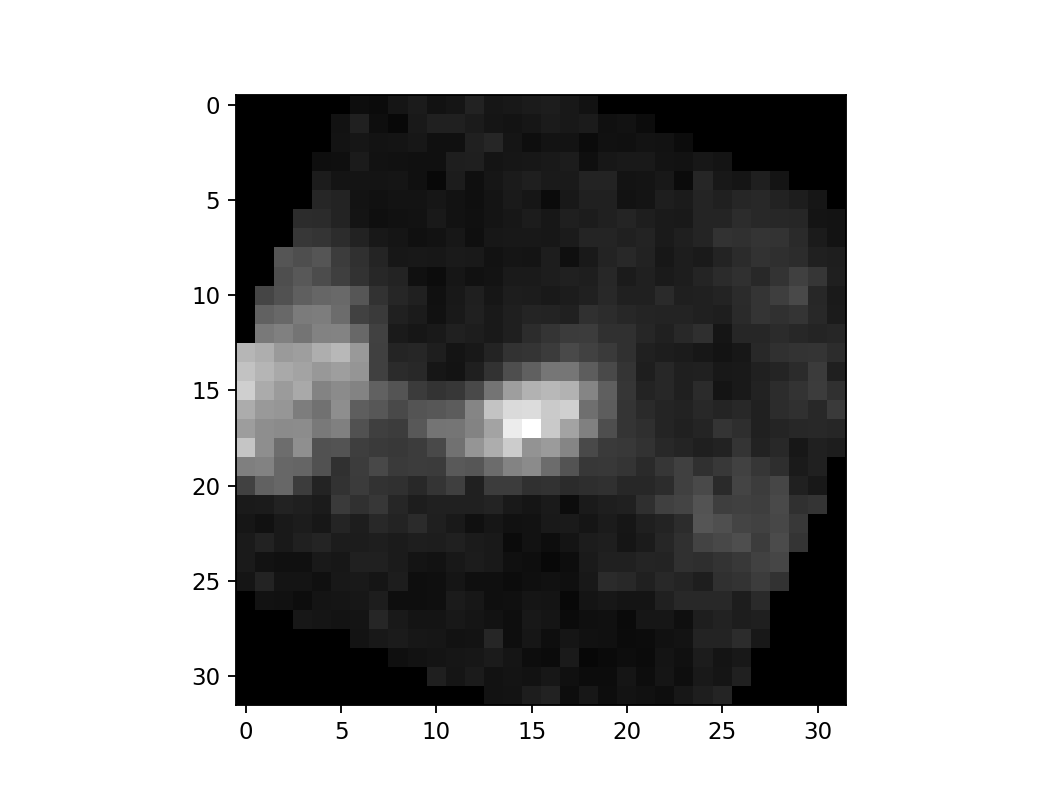

In [177]:
images, labels = next(iter(data_loader))

print(images.shape)
img = np.squeeze(images[0].cpu().numpy())[3]
plt.figure()
plt.imshow(img, cmap = 'gray')

In [178]:
N_EPOCHS = 10           # times to run the model on complete data
INPUT_DIM = 32*32*7     # size of each input
HIDDEN_DIM = 256        # hidden dimension
LATENT_DIM = 10         # latent vector dimension
N_CLASSES = 7          # number of classes in the data
lr = 1e-3               # learning rate

In [179]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=4608):
        return input.view(input.size(0), size, 1, 1)
    
class VAE(nn.Module):
    def __init__(self, image_channels=7, h_dim=4608, z_dim=32):
        super(VAE, self).__init__()
        self.depth = 16
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, self.depth, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(self.depth, self.depth*2,kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(self.depth*2, self.depth*4, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(self.depth*4, self.depth*8, kernel_size=3, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, self.depth*8, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(self.depth*8, self.depth*4, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(self.depth*4, self.depth*2, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(self.depth*2, image_channels, kernel_size=4, stride=2),
            nn.Sigmoid(),
        )
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Kaming Initialization
                init.kaiming_normal_(m.weight.data)
                #m.bias.data.fill_(0)
                init.normal_(m.bias.data)
            elif isinstance(m, nn.Linear):
                # Kaming Initialization
                init.kaiming_normal_(m.weight.data)
                #m.bias.data.fill_(0)
                init.normal_(m.bias.data)
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).cuda()
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def representation(self, x):
        return self.bottleneck(self.encoder(x))[0]

    def forward(self, x):
        #print(x.shape)
        x = torch.squeeze(x)
        h = self.encoder(x)
        #print(h.shape)
        z, mu, logvar = self.bottleneck(h)
        z = self.fc3(z)
        return self.decoder(z), mu, logvar    

In [180]:

    
class UnFlatten2d(nn.Module):
    def forward(self, input, size=4608):
        return input.view(input.size(0),1, 7, 32, 32)


class VAE2d(nn.Module):
    def __init__(self, image_channels=1, h_dim=2056, z_dim=25):
        super(VAE2d, self).__init__()
        self.depth = 16
        self.num_features = 200 
        self.encoder = nn.Sequential(
            Flatten(), 
            nn.Linear(int(32*32*7), h_dim),
            nn.Linear(h_dim, self.num_features)
        )
        
        self.fc1 = nn.Linear(self.num_features, z_dim)
        self.fc2 = nn.Linear(self.num_features, z_dim)
        self.fc3 = nn.Linear(z_dim, self.num_features)
        
        self.decoder = nn.Sequential(
            nn.Linear(self.num_features, h_dim),
            nn.Linear(h_dim, int(32*32*7)),
            UnFlatten2d(),
            nn.Sigmoid()
            
        )
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Kaming Initialization
                init.kaiming_normal_(m.weight.data)
                #m.bias.data.fill_(0)
                init.normal_(m.bias.data)
            elif isinstance(m, nn.Linear):
                # Kaming Initialization
                init.kaiming_normal_(m.weight.data)
                #m.bias.data.fill_(0)
                init.normal_(m.bias.data)
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).cuda()
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def representation(self, x):
        return self.bottleneck(self.encoder(x))[0]

    def forward(self, x):
        #print(x.shape)
        #x = x[:,:,3,:,:]
        #print(x.shape)
        h = self.encoder(x)
        #print(h.shape)
        z, mu, logvar = self.bottleneck(h)
        z = self.fc3(z)
        return self.decoder(z), mu, logvar


    
model = VAE2d()    
if torch.cuda.is_available():
    model.cuda()

reconstruction_function = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=1e-4, amsgrad = True, weight_decay = 1e-5)
import math
def loss_function(recon_x, x, mu, logvar, epoch):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    #print(recon_x.shape)
    #print(x.shape)
    s = nn.Sigmoid()
    BCE = reconstruction_function(recon_x, x)  # mse loss
    if math.isnan(BCE.cpu().detach().numpy()):
        print("LOSS IS NAN... ENDING TRAINING")
        exit()
    #print(BCE.cpu().detach().numpy())
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    if epoch < 50:
        B = 0.01
        a = 1
    elif epoch < 100:
        B = 0.1
        a = 1
    else:
        B = 0.5
        a = 1
    return a*BCE + KLD*B

In [155]:
trainer = Trainer(model, loss_function, metrics, optimizer,
                  resume=None,
                  config=config,
                  data_loader=data_loader,
                  valid_data_loader=valid_data_loader,
                  lr_scheduler=lr_scheduler,
                  train_logger=train_logger)

trainer.train()

C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\torch\nn\_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
    epoch          : 1
    loss           : 17785.29288999496
    MSE            : 17730.036766790574
    val_loss       : 4751.30914015997
    val_MSE        : 4697.148367745535


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/cd45VAE\0113_132807\checkpoint-epoch1.pth ...
Saving current best: model_best.pth ...
    epoch          : 2
    loss           : 4217.447960638231
    MSE            : 4164.762965048513
    val_loss       : 4180.098191034226
    val_MSE        : 4126.30669875372


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/cd45VAE\0113_132807\checkpoint-epoch2.pth ...
Saving current best: model_best.pth ...
    epoch          : 3
    loss           : 3573.0397102602064
    MSE            : 3520.6383509482107
    val_loss       : 3344.4901181175596
    val_MSE        : 3291.534644717262


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/cd45VAE\0113_132807\checkpoint-epoch3.pth ...
Saving current best: model_best.pth ...
    epoch          : 4
    loss           : 3220.81885750063
    MSE            : 3168.4005501039564
    val_loss       : 3219.1738862537204
    val_MSE        : 3165.4611700148807


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/cd45VAE\0113_132807\checkpoint-epoch4.pth ...
Saving current best: model_best.pth ...
    epoch          : 5
    loss           : 2940.371822234123
    MSE            : 2888.4808310231856
    val_loss       : 2721.204810732887
    val_MSE        : 2669.5332380022323


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/cd45VAE\0113_132807\checkpoint-epoch5.pth ...
Saving current best: model_best.pth ...
    epoch          : 6
    loss           : 2706.166231216923
    MSE            : 2654.5817467474167
    val_loss       : 2544.3214053199404
    val_MSE        : 2492.9654773530506


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/cd45VAE\0113_132807\checkpoint-epoch6.pth ...
Saving current best: model_best.pth ...
    epoch          : 7
    loss           : 2475.9374458559096
    MSE            : 2424.7169386340724
    val_loss       : 2425.262363978795
    val_MSE        : 2373.308773949033


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/cd45VAE\0113_132807\checkpoint-epoch7.pth ...
Saving current best: model_best.pth ...
    epoch          : 8
    loss           : 2328.6427789503527
    MSE            : 2277.3260576801918
    val_loss       : 2254.2970261346727
    val_MSE        : 2202.690668015253


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/cd45VAE\0113_132807\checkpoint-epoch8.pth ...
Saving current best: model_best.pth ...
    epoch          : 9
    loss           : 2176.6290657289564
    MSE            : 2125.591552734375
    val_loss       : 2126.1136474609375
    val_MSE        : 2074.90731375558


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/cd45VAE\0113_132807\checkpoint-epoch9.pth ...
Saving current best: model_best.pth ...
    epoch          : 10
    loss           : 2021.4041531470514
    MSE            : 1970.7910648469
    val_loss       : 1975.7212669735864
    val_MSE        : 1924.8369780040923


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/cd45VAE\0113_132807\checkpoint-epoch10.pth ...
Saving current best: model_best.pth ...
    epoch          : 11
    loss           : 1930.8587794150076
    MSE            : 1880.6153544764366
    val_loss       : 1902.539794921875
    val_MSE        : 1852.6317429315477


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/cd45VAE\0113_132807\checkpoint-epoch11.pth ...
Saving current best: model_best.pth ...
    epoch          : 12
    loss           : 1844.6376559349799
    MSE            : 1794.8480638073336
    val_loss       : 1797.4430106026787
    val_MSE        : 1747.6821812220983


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/cd45VAE\0113_132807\checkpoint-epoch12.pth ...
Saving current best: model_best.pth ...
    epoch          : 13
    loss           : 1788.3106088945942
    MSE            : 1739.0080910959553
    val_loss       : 1795.0058884393602
    val_MSE        : 1745.851574125744


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/cd45VAE\0113_132807\checkpoint-epoch13.pth ...
Saving current best: model_best.pth ...
    epoch          : 14
    loss           : 1720.1161311980218
    MSE            : 1671.174798780872
    val_loss       : 1762.408447265625
    val_MSE        : 1713.0970807756696


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/cd45VAE\0113_132807\checkpoint-epoch14.pth ...
Saving current best: model_best.pth ...
    epoch          : 15
    loss           : 1685.1022525910407
    MSE            : 1636.553971813571
    val_loss       : 1713.572265625
    val_MSE        : 1664.9788876488096


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/cd45VAE\0113_132807\checkpoint-epoch15.pth ...
Saving current best: model_best.pth ...
    epoch          : 16
    loss           : 1629.6177663495464
    MSE            : 1581.5348727318549
    val_loss       : 1634.641636439732
    val_MSE        : 1587.018833705357


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/cd45VAE\0113_132807\checkpoint-epoch16.pth ...
Saving current best: model_best.pth ...
    epoch          : 17
    loss           : 1600.3082167102446
    MSE            : 1552.6229740265876
    val_loss       : 1573.0595005580358
    val_MSE        : 1525.6233375186011


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/cd45VAE\0113_132807\checkpoint-epoch17.pth ...
Saving current best: model_best.pth ...
    epoch          : 18
    loss           : 1566.5345498361896
    MSE            : 1519.2474503055696
    val_loss       : 1667.108177548363
    val_MSE        : 1619.3768659319196


Model has not improved in -------------| 1 epochs


    epoch          : 19
    loss           : 1538.1265967584425
    MSE            : 1491.1063350554437
    val_loss       : 1550.2447335379463
    val_MSE        : 1503.1559186662946


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/cd45VAE\0113_132807\checkpoint-epoch19.pth ...
Saving current best: model_best.pth ...
    epoch          : 20
    loss           : 1517.1967310751638
    MSE            : 1470.5240773847027
    val_loss       : 1512.4319545200892
    val_MSE        : 1466.0150902157739


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/cd45VAE\0113_132807\checkpoint-epoch20.pth ...
Saving current best: model_best.pth ...
    epoch          : 21
    loss           : 1504.5767960086946
    MSE            : 1458.1603644586378
    val_loss       : 1531.0865304129463
    val_MSE        : 1484.6119035993304


Model has not improved in -------------| 1 epochs


    epoch          : 22
    loss           : 1491.041731311429
    MSE            : 1444.9053679435483
    val_loss       : 1516.5970865885417
    val_MSE        : 1470.3186209542412


Model has not improved in -------------| 2 epochs


    epoch          : 23
    loss           : 1461.7161835701236
    MSE            : 1415.9186243857107
    val_loss       : 1481.9429699125744
    val_MSE        : 1436.2102980840773


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/cd45VAE\0113_132807\checkpoint-epoch23.pth ...
Saving current best: model_best.pth ...
    epoch          : 24
    loss           : 1470.0152942288307
    MSE            : 1424.4308402769027
    val_loss       : 1466.5132242838542
    val_MSE        : 1420.956263950893


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/cd45VAE\0113_132807\checkpoint-epoch24.pth ...
Saving current best: model_best.pth ...
    epoch          : 25
    loss           : 1446.8336053663684
    MSE            : 1401.507583618164
    val_loss       : 1453.227562313988
    val_MSE        : 1408.0993012927827


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/cd45VAE\0113_132807\checkpoint-epoch25.pth ...
Saving current best: model_best.pth ...
    epoch          : 26
    loss           : 1436.5484461630545
    MSE            : 1391.6024209299396
    val_loss       : 1453.0307675316221
    val_MSE        : 1408.2431815011162


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/cd45VAE\0113_132807\checkpoint-epoch26.pth ...
Saving current best: model_best.pth ...
    epoch          : 27
    loss           : 1414.2488270421181
    MSE            : 1369.771958874118
    val_loss       : 1469.7420712425596
    val_MSE        : 1425.1215994698662


Model has not improved in -------------| 1 epochs


    epoch          : 28
    loss           : 1423.8189913841986
    MSE            : 1379.5544394216229
    val_loss       : 1421.163841610863
    val_MSE        : 1377.0711379278273


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/cd45VAE\0113_132807\checkpoint-epoch28.pth ...
Saving current best: model_best.pth ...
    epoch          : 29
    loss           : 1428.8453664472027
    MSE            : 1384.7088504914313
    val_loss       : 1449.6870059058779
    val_MSE        : 1405.6241920107886


Model has not improved in -------------| 1 epochs


    epoch          : 30
    loss           : 1409.5093659431705
    MSE            : 1365.551776516822
    val_loss       : 1448.7101876395088
    val_MSE        : 1404.7005964006696


Model has not improved in -------------| 2 epochs


    epoch          : 31
    loss           : 1419.9236460039692
    MSE            : 1376.1220078006868
    val_loss       : 1454.2816336495537
    val_MSE        : 1411.0103236607142


Model has not improved in -------------| 3 epochs


    epoch          : 32
    loss           : 1405.7906907604586
    MSE            : 1362.3142286731352
    val_loss       : 1423.0655808221727
    val_MSE        : 1379.4822939918154


Model has not improved in -------------| 4 epochs


    epoch          : 33
    loss           : 1405.7745282573085
    MSE            : 1362.3340675600114
    val_loss       : 1388.9810035342261
    val_MSE        : 1345.4708600725446


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/cd45VAE\0113_132807\checkpoint-epoch33.pth ...
Saving current best: model_best.pth ...
    epoch          : 34
    loss           : 1401.6767775012602
    MSE            : 1358.2949838945942
    val_loss       : 1439.0868152436756
    val_MSE        : 1395.5795317150298


Model has not improved in -------------| 1 epochs


    epoch          : 35
    loss           : 1397.024373700542
    MSE            : 1353.9664779170866
    val_loss       : 1422.9248802548364
    val_MSE        : 1379.7722865513392


Model has not improved in -------------| 2 epochs


    epoch          : 36
    loss           : 1404.2095602712322
    MSE            : 1361.2326955487652
    val_loss       : 1391.5518508184523
    val_MSE        : 1348.540783110119


Model has not improved in -------------| 3 epochs


    epoch          : 37
    loss           : 1393.0299653084048
    MSE            : 1350.1578836748677
    val_loss       : 1385.0450265066963
    val_MSE        : 1342.2491920107886


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/cd45VAE\0113_132807\checkpoint-epoch37.pth ...
Saving current best: model_best.pth ...
    epoch          : 38
    loss           : 1389.2788765199723
    MSE            : 1346.5598902548513
    val_loss       : 1408.4537934802827
    val_MSE        : 1365.5552397228423


Model has not improved in -------------| 1 epochs


    epoch          : 39
    loss           : 1384.4661953833795
    MSE            : 1341.978775516633
    val_loss       : 1401.3415934244792
    val_MSE        : 1358.7745477585565


Model has not improved in -------------| 2 epochs


    epoch          : 40
    loss           : 1387.6177565051664
    MSE            : 1345.2656638853011
    val_loss       : 1390.565708705357
    val_MSE        : 1348.2458670479912


Model has not improved in -------------| 3 epochs


    epoch          : 41
    loss           : 1389.4215078046245
    MSE            : 1347.1249547158518
    val_loss       : 1385.6290399460565
    val_MSE        : 1343.5100853329614


Model has not improved in -------------| 4 epochs


    epoch          : 42
    loss           : 1384.2574659778227
    MSE            : 1342.0924539873677
    val_loss       : 1393.2419491722471
    val_MSE        : 1350.9981515066963


Model has not improved in -------------| 5 epochs


    epoch          : 43
    loss           : 1379.931885257844
    MSE            : 1337.8472275272493
    val_loss       : 1416.5136311848958
    val_MSE        : 1374.2061883835565


Model has not improved in -------------| 6 epochs


    epoch          : 44
    loss           : 1388.8004790275327
    MSE            : 1346.6154588268648
    val_loss       : 1428.901123046875
    val_MSE        : 1386.3676699683779


Model has not improved in -------------| 7 epochs


    epoch          : 45
    loss           : 1389.470947265625
    MSE            : 1347.3240661621094
    val_loss       : 1399.5328311011904
    val_MSE        : 1357.5378882998511


Model has not improved in -------------| 8 epochs


    epoch          : 46
    loss           : 1392.0145263671875
    MSE            : 1350.0074866510206
    val_loss       : 1393.8408958798364
    val_MSE        : 1351.8899507068452


Model has not improved in -------------| 9 epochs


    epoch          : 47
    loss           : 1378.3204158659905
    MSE            : 1336.5428826116747
    val_loss       : 1410.3531377883185
    val_MSE        : 1368.5465727306548


Model has not improved in -------------| 10 epochs


    epoch          : 48
    loss           : 1368.2166122928743
    MSE            : 1326.4900798182334
    val_loss       : 1379.2283703031994
    val_MSE        : 1337.4342099144346


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/cd45VAE\0113_132807\checkpoint-epoch48.pth ...
Saving current best: model_best.pth ...
    epoch          : 49
    loss           : 1373.552456763483
    MSE            : 1331.8324368384576
    val_loss       : 1388.1232154482886
    val_MSE        : 1346.3869570777529


Model has not improved in -------------| 1 epochs


    epoch          : 50
    loss           : 1676.2549851940523
    MSE            : 1385.4320757465978
    val_loss       : 1640.9078485398065
    val_MSE        : 1400.0512869698662


Model has not improved in -------------| 2 epochs


    epoch          : 51
    loss           : 1637.6187438964844
    MSE            : 1404.3766036495085
    val_loss       : 1672.4236769903273
    val_MSE        : 1440.0186709449404


Model has not improved in -------------| 3 epochs


    epoch          : 52
    loss           : 1629.7731717017389
    MSE            : 1402.8313500189013
    val_loss       : 1638.2234816778273
    val_MSE        : 1414.143333798363


Model has not improved in -------------| 4 epochs


    epoch          : 53
    loss           : 1617.08983390562
    MSE            : 1394.5994823824974
    val_loss       : 1645.5002615792412
    val_MSE        : 1425.2388509114583


Model has not improved in -------------| 5 epochs


    epoch          : 54
    loss           : 1630.3465231618572
    MSE            : 1409.8039432648688
    val_loss       : 1650.7810756138392
    val_MSE        : 1430.2710542224702


Model has not improved in -------------| 6 epochs


    epoch          : 55
    loss           : 1629.7052149618826
    MSE            : 1409.6585053474673
    val_loss       : 1648.398937406994
    val_MSE        : 1428.75048828125


Model has not improved in -------------| 7 epochs


    epoch          : 56
    loss           : 1620.2453957834553
    MSE            : 1401.5982508505545
    val_loss       : 1637.361363002232
    val_MSE        : 1417.3778424944196


Model has not improved in -------------| 8 epochs


    epoch          : 57
    loss           : 1616.883553781817
    MSE            : 1400.3409669937625
    val_loss       : 1631.033958798363
    val_MSE        : 1413.008800688244


Model has not improved in -------------| 9 epochs


    epoch          : 58
    loss           : 1606.1516585811491
    MSE            : 1389.295921079574
    val_loss       : 1619.7028866722471
    val_MSE        : 1404.9117315383185


Model has not improved in -------------| 10 epochs


    epoch          : 59
    loss           : 1634.7230569162678
    MSE            : 1418.781520720451
    val_loss       : 1622.9713251023065
    val_MSE        : 1406.9491722470239


Model has not improved in -------------| 11 epochs


    epoch          : 60
    loss           : 1613.3522181357107
    MSE            : 1398.242910077495
    val_loss       : 1634.2601957775298
    val_MSE        : 1416.8087274460565


Model has not improved in -------------| 12 epochs


    epoch          : 61
    loss           : 1615.7862932758946
    MSE            : 1399.9502937563004
    val_loss       : 1636.8500337146577
    val_MSE        : 1418.396263485863


Model has not improved in -------------| 13 epochs


    epoch          : 62
    loss           : 1619.4227029123615
    MSE            : 1404.4302259875883
    val_loss       : 1611.3661295572917
    val_MSE        : 1397.2153843470983


Model has not improved in -------------| 14 epochs


    epoch          : 63
    loss           : 1614.8738098144531
    MSE            : 1400.6855114352318
    val_loss       : 1612.5030575706846
    val_MSE        : 1396.8970598493304


Model has not improved in -------------| 15 epochs


    epoch          : 64
    loss           : 1611.811542141822
    MSE            : 1397.2192914409022
    val_loss       : 1614.668922061012
    val_MSE        : 1399.085414341518


Model has not improved in -------------| 16 epochs


    epoch          : 65
    loss           : 1614.8589772870464
    MSE            : 1400.3763221002393
    val_loss       : 1618.1759381975446
    val_MSE        : 1402.8827078683037


Model has not improved in -------------| 17 epochs


    epoch          : 66
    loss           : 1613.6514538180443
    MSE            : 1400.1633950510334
    val_loss       : 1627.559070405506
    val_MSE        : 1411.7898879278273


Model has not improved in -------------| 18 epochs


    epoch          : 67
    loss           : 1613.2586512411795
    MSE            : 1399.3240287534652
    val_loss       : 1610.173118954613
    val_MSE        : 1394.8419828869048


Model has not improved in -------------| 19 epochs


    epoch          : 68
    loss           : 1612.1673357563634
    MSE            : 1397.961638419859
    val_loss       : 1588.9725632440477
    val_MSE        : 1374.6935744512648


Model has not improved in -------------| 20 epochs


    epoch          : 69
    loss           : 1604.42868632655
    MSE            : 1390.2794597994896
    val_loss       : 1616.5696091424852
    val_MSE        : 1400.9301176525298


Model has not improved in -------------| 21 epochs


    epoch          : 70
    loss           : 1610.6820088048134
    MSE            : 1396.8986471852947
    val_loss       : 1643.6617024739583
    val_MSE        : 1429.0486363002233


Model has not improved in -------------| 22 epochs


    epoch          : 71
    loss           : 1608.5965684460054
    MSE            : 1395.2047266806326
    val_loss       : 1624.4994535900298
    val_MSE        : 1410.576939174107


Model has not improved in -------------| 23 epochs


    epoch          : 72
    loss           : 1605.3616283785911
    MSE            : 1392.5197714528729
    val_loss       : 1631.6421363467261
    val_MSE        : 1415.1276157924108


Model has not improved in -------------| 24 epochs


    epoch          : 73
    loss           : 1617.454117313508
    MSE            : 1404.4855336835308
    val_loss       : 1628.5515834263392
    val_MSE        : 1411.6482689267114


Model has not improved in -------------| 25 epochs


    epoch          : 74
    loss           : 1603.3736463977446
    MSE            : 1389.9894802954889
    val_loss       : 1631.3291073753721
    val_MSE        : 1417.954578218006


Model has not improved in -------------| 26 epochs


    epoch          : 75
    loss           : 1612.6468092395414
    MSE            : 1399.3880073793473
    val_loss       : 1637.2799595424108
    val_MSE        : 1421.859398251488


Model has not improved in -------------| 27 epochs


    epoch          : 76
    loss           : 1615.2425586331276
    MSE            : 1401.809352751701
    val_loss       : 1652.0971854073662
    val_MSE        : 1437.9657505580358


Model has not improved in -------------| 28 epochs


    epoch          : 77
    loss           : 1604.8649144326487
    MSE            : 1392.6724410518523
    val_loss       : 1633.1025565011162
    val_MSE        : 1419.9290829613096


Model has not improved in -------------| 29 epochs


    epoch          : 78
    loss           : 1607.5504111013104
    MSE            : 1394.8909223002772
    val_loss       : 1632.7425188337054
    val_MSE        : 1418.1872384207588


Model has not improved in -------------| 30 epochs


    epoch          : 79
    loss           : 1606.8762512207031
    MSE            : 1394.388956377583
    val_loss       : 1626.688988095238
    val_MSE        : 1411.6508382161458


Model has not improved in -------------| 31 epochs


    epoch          : 80
    loss           : 1605.3079765073714
    MSE            : 1392.8087679955268
    val_loss       : 1640.0423177083333
    val_MSE        : 1425.2565220424108


Model has not improved in -------------| 32 epochs


    epoch          : 81
    loss           : 1597.743864982359
    MSE            : 1385.6875196887602
    val_loss       : 1628.7018171037946
    val_MSE        : 1414.6922956194196


Model has not improved in -------------| 33 epochs


    epoch          : 82
    loss           : 1609.0044319398942
    MSE            : 1397.7759158226752
    val_loss       : 1647.9833984375
    val_MSE        : 1435.2767799014136


Model has not improved in -------------| 34 epochs


    epoch          : 83
    loss           : 1606.130818028604
    MSE            : 1393.405006654801
    val_loss       : 1635.9645821707588
    val_MSE        : 1420.2597249348958


Model has not improved in -------------| 35 epochs


    epoch          : 84
    loss           : 1605.3006286621094
    MSE            : 1393.121061263546
    val_loss       : 1622.2717982700892
    val_MSE        : 1409.0117129371279


Model has not improved in -------------| 36 epochs


    epoch          : 85
    loss           : 1603.5553175403227
    MSE            : 1391.840812436996
    val_loss       : 1634.8560849144346
    val_MSE        : 1423.1131998697917


Model has not improved in -------------| 37 epochs


    epoch          : 86
    loss           : 1608.4378376622353
    MSE            : 1397.9660044024067
    val_loss       : 1629.484351748512
    val_MSE        : 1416.8642578125


Model has not improved in -------------| 38 epochs


    epoch          : 87
    loss           : 1605.7359924316406
    MSE            : 1394.2794406029486
    val_loss       : 1623.955066499256
    val_MSE        : 1409.8753429594494


Model has not improved in -------------| 39 epochs


    epoch          : 88
    loss           : 1596.862565563571
    MSE            : 1385.658650059854
    val_loss       : 1607.9522879464287
    val_MSE        : 1393.1683465866815


Model has not improved in -------------| 40 epochs


    epoch          : 89
    loss           : 1597.2646041377898
    MSE            : 1385.1395362115675
    val_loss       : 1621.1424444289435
    val_MSE        : 1406.3481910342261


Model has not improved in -------------| 41 epochs


    epoch          : 90
    loss           : 1605.036847514491
    MSE            : 1393.1227416992188
    val_loss       : 1621.4171026320685
    val_MSE        : 1408.1205996558779


Model has not improved in -------------| 42 epochs


    epoch          : 91
    loss           : 1604.4490464733492
    MSE            : 1393.762942406439
    val_loss       : 1623.1822974795386
    val_MSE        : 1411.1592901320685


Model has not improved in -------------| 43 epochs


    epoch          : 92
    loss           : 1602.2720819288684
    MSE            : 1391.6050405194683
    val_loss       : 1616.7696881975446
    val_MSE        : 1403.3110177176338


Model has not improved in -------------| 44 epochs


    epoch          : 93
    loss           : 1599.8599607406125
    MSE            : 1388.5831948557209
    val_loss       : 1612.212367466518
    val_MSE        : 1399.3873756045386


Model has not improved in -------------| 45 epochs


    epoch          : 94
    loss           : 1593.9311169039818
    MSE            : 1383.224364249937
    val_loss       : 1629.1218784877233
    val_MSE        : 1416.5660226004463


Model has not improved in -------------| 46 epochs


    epoch          : 95
    loss           : 1600.0460116478705
    MSE            : 1388.9346323320942
    val_loss       : 1618.2768496558779
    val_MSE        : 1408.4854271298364


Model has not improved in -------------| 47 epochs


    epoch          : 96
    loss           : 1597.1793301490045
    MSE            : 1387.1278469947076
    val_loss       : 1619.0518566313244
    val_MSE        : 1408.3607061476935


Model has not improved in -------------| 48 epochs


    epoch          : 97
    loss           : 1602.6617411951866
    MSE            : 1392.5435466151084
    val_loss       : 1616.2945091610864
    val_MSE        : 1404.3557710193452


Model has not improved in -------------| 49 epochs


    epoch          : 98
    loss           : 1601.2412581905241
    MSE            : 1390.133788078062
    val_loss       : 1632.7985026041667
    val_MSE        : 1419.445033482143


Model has not improved in -------------| 50 epochs


    epoch          : 99
    loss           : 1604.360365344632
    MSE            : 1393.1445686586442
    val_loss       : 1605.013195219494
    val_MSE        : 1391.3705066499256


Model has not improved in -------------| 51 epochs


    epoch          : 100
    loss           : 2192.8959084787675
    MSE            : 1608.0118733067666
    val_loss       : 2185.3650251116073
    val_MSE        : 1638.779564267113


Model has not improved in -------------| 52 epochs


    epoch          : 101
    loss           : 2171.644843316847
    MSE            : 1642.6889057774697
    val_loss       : 2170.006522042411
    val_MSE        : 1640.3324788411458


Model has not improved in -------------| 53 epochs


    epoch          : 102
    loss           : 2165.433640018586
    MSE            : 1641.9476997621598
    val_loss       : 2213.588628859747
    val_MSE        : 1676.4217122395833


Model has not improved in -------------| 54 epochs


    epoch          : 103
    loss           : 2165.772525910408
    MSE            : 1641.1365799442415
    val_loss       : 2204.1722412109375
    val_MSE        : 1669.4043840680804


Model has not improved in -------------| 55 epochs


    epoch          : 104
    loss           : 2161.3301736154863
    MSE            : 1641.2548168551536
    val_loss       : 2177.7967122395835
    val_MSE        : 1655.9792015438989


Model has not improved in -------------| 56 epochs


    epoch          : 105
    loss           : 2158.8293860650833
    MSE            : 1637.5005434097782
    val_loss       : 2160.592569986979
    val_MSE        : 1626.1556396484375


Model has not improved in -------------| 57 epochs


    epoch          : 106
    loss           : 2158.113473215411
    MSE            : 1637.498989966608
    val_loss       : 2170.8126453218006
    val_MSE        : 1653.315406436012


Model has not improved in -------------| 58 epochs


    epoch          : 107
    loss           : 2157.679851901147
    MSE            : 1638.2839227491809
    val_loss       : 2199.1098749069943
    val_MSE        : 1675.6338704427083


Model has not improved in -------------| 59 epochs


    epoch          : 108
    loss           : 2157.66949758222
    MSE            : 1641.1536087528352
    val_loss       : 2195.7852841331846
    val_MSE        : 1670.4087088448662


Model has not improved in -------------| 60 epochs


    epoch          : 109
    loss           : 2167.030205511278
    MSE            : 1649.0605832992062
    val_loss       : 2175.631620861235
    val_MSE        : 1652.0016508556548


Model has not improved in -------------| 61 epochs


    epoch          : 110
    loss           : 2153.519370786605
    MSE            : 1637.8271878150201
    val_loss       : 2179.910824730283
    val_MSE        : 1645.028785342262


Model has not improved in -------------| 62 epochs


    epoch          : 111
    loss           : 2156.6375791488153
    MSE            : 1640.6105317146548
    val_loss       : 2173.7620675223216
    val_MSE        : 1659.0168398902529


Model has not improved in -------------| 63 epochs


    epoch          : 112
    loss           : 2153.802973593435
    MSE            : 1637.8927868258568
    val_loss       : 2174.000261579241
    val_MSE        : 1663.0442882719494


Model has not improved in -------------| 64 epochs


    epoch          : 113
    loss           : 2167.3394578503026
    MSE            : 1650.782691217238
    val_loss       : 2193.177798316592
    val_MSE        : 1664.9577346075148


Model has not improved in -------------| 65 epochs


    epoch          : 114
    loss           : 2160.2684158817415
    MSE            : 1643.2212996944304
    val_loss       : 2196.6531517392114
    val_MSE        : 1659.8266427176338


Model has not improved in -------------| 66 epochs


    epoch          : 115
    loss           : 2149.971386324975
    MSE            : 1634.8270224294354
    val_loss       : 2156.5577160063244
    val_MSE        : 1633.3046409970239


Model has not improved in -------------| 67 epochs


    epoch          : 116
    loss           : 2151.131576045867
    MSE            : 1638.4840186334425
    val_loss       : 2174.136980329241
    val_MSE        : 1651.1801699683779


Model has not improved in -------------| 68 epochs


    epoch          : 117
    loss           : 2154.2305691626766
    MSE            : 1637.6594622212071
    val_loss       : 2175.280006045387
    val_MSE        : 1651.0471365792412


Model has not improved in -------------| 69 epochs


    epoch          : 118
    loss           : 2155.8127037786667
    MSE            : 1642.3940045756679
    val_loss       : 2129.295567103795
    val_MSE        : 1621.8033563523065


Model has not improved in -------------| 70 epochs


    epoch          : 119
    loss           : 2152.055162983556
    MSE            : 1637.5421792307209
    val_loss       : 2183.223185221354
    val_MSE        : 1661.580113002232


Model has not improved in -------------| 71 epochs


    epoch          : 120
    loss           : 2156.8162989462576
    MSE            : 1644.0538280856224
    val_loss       : 2193.6639113653273
    val_MSE        : 1669.1228608630952


Model has not improved in -------------| 72 epochs


    epoch          : 121
    loss           : 2145.7288493494834
    MSE            : 1634.944368423954
    val_loss       : 2189.003348214286
    val_MSE        : 1673.9873686290923


Model has not improved in -------------| 73 epochs


    epoch          : 122
    loss           : 2141.647492439516
    MSE            : 1629.6686302923388
    val_loss       : 2172.077421642485
    val_MSE        : 1660.3695591517858


Model has not improved in -------------| 74 epochs


    epoch          : 123
    loss           : 2146.199239423198
    MSE            : 1635.409374606225
    val_loss       : 2173.2708507719494
    val_MSE        : 1660.1573370070685


Model has not improved in -------------| 75 epochs


    epoch          : 124
    loss           : 2155.2832976310483
    MSE            : 1641.5317166236139
    val_loss       : 2181.142758324033
    val_MSE        : 1655.9394008091517


Model has not improved in -------------| 76 epochs


    epoch          : 125
    loss           : 2149.9076055711316
    MSE            : 1638.319606657951
    val_loss       : 2178.4076392764136
    val_MSE        : 1661.6105259486608


Model has not improved in -------------| 77 epochs


    epoch          : 126
    loss           : 2139.8132708149574
    MSE            : 1631.1399910219254
    val_loss       : 2164.2028285435267
    val_MSE        : 1648.8195103236608


Model has not improved in -------------| 78 epochs


    epoch          : 127
    loss           : 2136.7042315083168
    MSE            : 1626.2064149918094
    val_loss       : 2159.7393101283483
    val_MSE        : 1633.966331845238


Model has not improved in -------------| 79 epochs


    epoch          : 128
    loss           : 2141.497782061177
    MSE            : 1630.5335624448714
    val_loss       : 2154.451148623512
    val_MSE        : 1649.0718994140625


Model has not improved in -------------| 80 epochs


    epoch          : 129
    loss           : 2144.3140977428807
    MSE            : 1634.216302687122
    val_loss       : 2185.504679361979
    val_MSE        : 1673.9967157273065


Model has not improved in -------------| 81 epochs


    epoch          : 130
    loss           : 2145.879415204448
    MSE            : 1637.8822159305696
    val_loss       : 2163.6610223679318
    val_MSE        : 1652.082972935268


Model has not improved in -------------| 82 epochs


    epoch          : 131
    loss           : 2149.6862044795866
    MSE            : 1639.2515682097405
    val_loss       : 2195.3192603701636
    val_MSE        : 1684.8629847935267


Model has not improved in -------------| 83 epochs


    epoch          : 132
    loss           : 2156.9326595183343
    MSE            : 1644.554913920741
    val_loss       : 2128.0831996372767
    val_MSE        : 1622.9938906715029


Model has not improved in -------------| 84 epochs


    epoch          : 133
    loss           : 2147.1673249275455
    MSE            : 1636.863770515688
    val_loss       : 2172.9490269252233
    val_MSE        : 1647.2312825520833


Model has not improved in -------------| 85 epochs


    epoch          : 134
    loss           : 2147.386974703881
    MSE            : 1637.674568422379
    val_loss       : 2176.196951729911
    val_MSE        : 1647.0871872674852


Model has not improved in -------------| 86 epochs


    epoch          : 135
    loss           : 2139.883643365675
    MSE            : 1628.3524681829638
    val_loss       : 2164.6034168061756
    val_MSE        : 1646.8267880394346


Model has not improved in -------------| 87 epochs


    epoch          : 136
    loss           : 2144.1639896515876
    MSE            : 1634.6643883489794
    val_loss       : 2161.3070475260415
    val_MSE        : 1652.0526529947917


Model has not improved in -------------| 88 epochs


    epoch          : 137
    loss           : 2135.245637955204
    MSE            : 1625.9041098317791
    val_loss       : 2173.9975469680057
    val_MSE        : 1655.3292526971727


Model has not improved in -------------| 89 epochs


    epoch          : 138
    loss           : 2147.9932418331023
    MSE            : 1637.3164889427924
    val_loss       : 2158.115007672991
    val_MSE        : 1647.4356863839287


Model has not improved in -------------| 90 epochs


    epoch          : 139
    loss           : 2145.538819343813
    MSE            : 1634.2941185735888
    val_loss       : 2190.924763997396
    val_MSE        : 1666.2949276878721


Model has not improved in -------------| 91 epochs


    epoch          : 140
    loss           : 2148.31885750063
    MSE            : 1639.5444887222782
    val_loss       : 2154.0405796595983
    val_MSE        : 1640.8415934244792


Model has not improved in -------------| 92 epochs


    epoch          : 141
    loss           : 2141.592088268649
    MSE            : 1633.0925745810232
    val_loss       : 2177.797892252604
    val_MSE        : 1661.7522437686011


Model has not improved in -------------| 93 epochs


    epoch          : 142
    loss           : 2139.4623019310734
    MSE            : 1630.6769064626385
    val_loss       : 2165.138828822545
    val_MSE        : 1644.7760184151787


Model has not improved in -------------| 94 epochs


    epoch          : 143
    loss           : 2152.7755235241307
    MSE            : 1642.7755491195187
    val_loss       : 2134.840779622396
    val_MSE        : 1623.7393508184523


Model has not improved in -------------| 95 epochs


    epoch          : 144
    loss           : 2144.8524484942036
    MSE            : 1637.303460890247
    val_loss       : 2171.4776146298364
    val_MSE        : 1652.3845505487352


Model has not improved in -------------| 96 epochs


    epoch          : 145
    loss           : 2142.7183562247983
    MSE            : 1632.6393757481728
    val_loss       : 2165.136213030134
    val_MSE        : 1656.5692080543154


Model has not improved in -------------| 97 epochs


    epoch          : 146
    loss           : 2142.3331220073082
    MSE            : 1632.2664430679813
    val_loss       : 2150.7755998883927
    val_MSE        : 1639.177211216518


Model has not improved in -------------| 98 epochs


    epoch          : 147
    loss           : 2142.779325423702
    MSE            : 1634.3637242471018
    val_loss       : 2168.158976236979
    val_MSE        : 1654.7018054780506


Model has not improved in -------------| 99 epochs


    epoch          : 148
    loss           : 2130.824509159211
    MSE            : 1626.2730811334425
    val_loss       : 2155.3795805431546
    val_MSE        : 1644.4688778831846


Model has not improved in -------------| 100 epochs


    epoch          : 149
    loss           : 2132.1556238974295
    MSE            : 1626.9444668677545
    val_loss       : 2176.269513811384
    val_MSE        : 1664.0529087611608


Model has not improved in -------------| 101 epochs


    epoch          : 150
    loss           : 2140.982467159148
    MSE            : 1630.9921481224799
    val_loss       : 2158.46915108817
    val_MSE        : 1652.5690046037946


Model has not improved in -------------| 102 epochs


    epoch          : 151
    loss           : 2139.6421823809223
    MSE            : 1630.7580290763608
    val_loss       : 2157.389956519717
    val_MSE        : 1640.4812534877233


Model has not improved in -------------| 103 epochs


    epoch          : 152
    loss           : 2142.1781439012098
    MSE            : 1633.4848514679938
    val_loss       : 2158.9744989304318
    val_MSE        : 1642.8451509021577


Model has not improved in -------------| 104 epochs


    epoch          : 153
    loss           : 2137.205359674269
    MSE            : 1628.1680799914946
    val_loss       : 2142.99459984189
    val_MSE        : 1647.0809326171875


Model has not improved in -------------| 105 epochs


    epoch          : 154
    loss           : 2142.7525762742566
    MSE            : 1633.018787999307
    val_loss       : 2149.216558547247
    val_MSE        : 1639.4554792131696


Model has not improved in -------------| 106 epochs


    epoch          : 155
    loss           : 2138.5753351026965
    MSE            : 1632.271465670678
    val_loss       : 2162.9297979445682
    val_MSE        : 1644.8467668805804


Model has not improved in -------------| 107 epochs


    epoch          : 156
    loss           : 2134.2113568705895
    MSE            : 1627.8012567335559
    val_loss       : 2178.0872163318454
    val_MSE        : 1660.2433093843006


Model has not improved in -------------| 108 epochs


    epoch          : 157
    loss           : 2134.496329030683
    MSE            : 1627.5738771500125
    val_loss       : 2160.58935546875
    val_MSE        : 1642.0782528831846


Model has not improved in -------------| 109 epochs


    epoch          : 158
    loss           : 2136.948214623236
    MSE            : 1630.9123318579889
    val_loss       : 2154.0742071242557
    val_MSE        : 1635.8545212518602


Model has not improved in -------------| 110 epochs


    epoch          : 159
    loss           : 2126.8748562720516
    MSE            : 1624.352313626197
    val_loss       : 2156.292009626116
    val_MSE        : 1636.539771670387


Model has not improved in -------------| 111 epochs


    epoch          : 160
    loss           : 2143.222004552041
    MSE            : 1636.4111800655241
    val_loss       : 2146.428867885045
    val_MSE        : 1640.7202613467261


Model has not improved in -------------| 112 epochs


    epoch          : 161
    loss           : 2133.518719088647
    MSE            : 1626.328117124496
    val_loss       : 2169.156732468378
    val_MSE        : 1656.6968064081102


Model has not improved in -------------| 113 epochs


    epoch          : 162
    loss           : 2126.0389040054815
    MSE            : 1622.047588717553
    val_loss       : 2159.85848563058
    val_MSE        : 1649.9209275018602


Model has not improved in -------------| 114 epochs


    epoch          : 163
    loss           : 2131.6443776776714
    MSE            : 1623.236353720388
    val_loss       : 2149.4190441313244
    val_MSE        : 1631.2481340680804


Model has not improved in -------------| 115 epochs


    epoch          : 164
    loss           : 2130.6232673891127
    MSE            : 1624.951203377016
    val_loss       : 2158.0650227864585
    val_MSE        : 1662.4024309430804


Model has not improved in -------------| 116 epochs


    epoch          : 165
    loss           : 2136.028595955141
    MSE            : 1629.513425765499
    val_loss       : 2152.3916829427085
    val_MSE        : 1636.2030436197917


Model has not improved in -------------| 117 epochs


    epoch          : 166
    loss           : 2136.692190847089
    MSE            : 1629.1204184255291
    val_loss       : 2176.8687569754466
    val_MSE        : 1658.1634114583333


Model has not improved in -------------| 118 epochs


    epoch          : 167
    loss           : 2140.550301828692
    MSE            : 1630.830589048324
    val_loss       : 2145.7250627790177
    val_MSE        : 1642.5774100167412


Model has not improved in -------------| 119 epochs


    epoch          : 168
    loss           : 2136.117899248677
    MSE            : 1632.0747975995464
    val_loss       : 2161.9915364583335
    val_MSE        : 1655.342296781994


Model has not improved in -------------| 120 epochs


    epoch          : 169
    loss           : 2136.640443863407
    MSE            : 1630.8660898516255
    val_loss       : 2160.89260718936
    val_MSE        : 1657.4421909877233


Model has not improved in -------------| 121 epochs


    epoch          : 170
    loss           : 2131.672390845514
    MSE            : 1623.9739301127772
    val_loss       : 2143.4572172619046
    val_MSE        : 1621.1884242466517


Model has not improved in -------------| 122 epochs


    epoch          : 171
    loss           : 2133.1291070753527
    MSE            : 1624.6810273201236
    val_loss       : 2171.678728376116
    val_MSE        : 1648.8999604724702


Model has not improved in -------------| 123 epochs


    epoch          : 172
    loss           : 2128.0539964245213
    MSE            : 1618.6087616951236
    val_loss       : 2160.766130719866
    val_MSE        : 1646.6271100725446


Model has not improved in -------------| 124 epochs


    epoch          : 173
    loss           : 2132.190163889239
    MSE            : 1625.4539538967995
    val_loss       : 2168.616768973214
    val_MSE        : 1658.043422154018


Model has not improved in -------------| 125 epochs


    epoch          : 174
    loss           : 2135.9959411621094
    MSE            : 1629.2448858445691
    val_loss       : 2156.6419793991818
    val_MSE        : 1652.8597470238096


Model has not improved in -------------| 126 epochs


    epoch          : 175
    loss           : 2137.757874519594
    MSE            : 1633.9293527910786
    val_loss       : 2152.715890066964
    val_MSE        : 1649.1701950799852


Model has not improved in -------------| 127 epochs


    epoch          : 176
    loss           : 2132.0338016633063
    MSE            : 1626.8406893822455
    val_loss       : 2155.353783017113
    val_MSE        : 1647.4725283668154


Model has not improved in -------------| 128 epochs


    epoch          : 177
    loss           : 2134.900199644027
    MSE            : 1626.1777058262978
    val_loss       : 2134.4456554594494
    val_MSE        : 1621.3586832682292


Model has not improved in -------------| 129 epochs


    epoch          : 178
    loss           : 2131.544400122858
    MSE            : 1629.1587819745464
    val_loss       : 2157.999825613839
    val_MSE        : 1649.0029994419642


Model has not improved in -------------| 130 epochs


    epoch          : 179
    loss           : 2136.3845598774574
    MSE            : 1632.1385734311996
    val_loss       : 2169.1280226934523
    val_MSE        : 1649.4093250093006


Model has not improved in -------------| 131 epochs


    epoch          : 180
    loss           : 2122.8150496944304
    MSE            : 1619.7950764317666
    val_loss       : 2149.526093982515
    val_MSE        : 1644.2031715029761


Model has not improved in -------------| 132 epochs


    epoch          : 181
    loss           : 2126.620064027848
    MSE            : 1622.2094106366558
    val_loss       : 2159.707071940104
    val_MSE        : 1639.7083914620537


Model has not improved in -------------| 133 epochs


    epoch          : 182
    loss           : 2130.589012884325
    MSE            : 1626.688005016696
    val_loss       : 2142.2456868489585
    val_MSE        : 1632.618187313988


Model has not improved in -------------| 134 epochs


    epoch          : 183
    loss           : 2132.261707921182
    MSE            : 1623.7381641018776
    val_loss       : 2137.926519484747
    val_MSE        : 1614.0589715866815


Model has not improved in -------------| 135 epochs


    epoch          : 184
    loss           : 2134.679441390499
    MSE            : 1627.3494676159273
    val_loss       : 2135.173095703125
    val_MSE        : 1625.3559105282739


Model has not improved in -------------| 136 epochs


    epoch          : 185
    loss           : 2131.080810546875
    MSE            : 1626.1282732563634
    val_loss       : 2145.1415899367557
    val_MSE        : 1636.7355550130208


Model has not improved in -------------| 137 epochs


    epoch          : 186
    loss           : 2122.5379756804437
    MSE            : 1619.623509560862
    val_loss       : 2128.658383324033
    val_MSE        : 1621.6940046037946


Model has not improved in -------------| 138 epochs


    epoch          : 187
    loss           : 2121.8976302608366
    MSE            : 1619.2719362320438
    val_loss       : 2167.7398914155506
    val_MSE        : 1665.4944893973213


Model has not improved in -------------| 139 epochs


    epoch          : 188
    loss           : 2133.447296142578
    MSE            : 1626.650838544292
    val_loss       : 2173.5315697079614
    val_MSE        : 1653.9453648158483


Model has not improved in -------------| 140 epochs


    epoch          : 189
    loss           : 2130.426970451109
    MSE            : 1625.9579044465095
    val_loss       : 2164.5970226469494
    val_MSE        : 1648.2704787481398


Model has not improved in -------------| 141 epochs


    epoch          : 190
    loss           : 2124.187192855343
    MSE            : 1620.0430799914946
    val_loss       : 2153.829921177455
    val_MSE        : 1644.7512788318452


Model has not improved in -------------| 142 epochs


    epoch          : 191
    loss           : 2139.9921107138357
    MSE            : 1633.6909681750883
    val_loss       : 2196.9903971354165
    val_MSE        : 1673.0804327101935


Model has not improved in -------------| 143 epochs


    epoch          : 192
    loss           : 2135.134990076865
    MSE            : 1629.1436068627143
    val_loss       : 2151.276681082589
    val_MSE        : 1648.7339913504463


Model has not improved in -------------| 144 epochs


    epoch          : 193
    loss           : 2138.654606972971
    MSE            : 1635.4301511703
    val_loss       : 2184.40478515625
    val_MSE        : 1669.4449695405506


Model has not improved in -------------| 145 epochs


    epoch          : 194
    loss           : 2128.610414566532
    MSE            : 1624.7878034037929
    val_loss       : 2159.277390252976
    val_MSE        : 1643.7457159133185


Model has not improved in -------------| 146 epochs


    epoch          : 195
    loss           : 2129.5044535975303
    MSE            : 1623.8734367124496
    val_loss       : 2155.7020554315477
    val_MSE        : 1639.7144542875744


Model has not improved in -------------| 147 epochs


    epoch          : 196
    loss           : 2134.1293167606477
    MSE            : 1627.217063657699
    val_loss       : 2143.584449404762
    val_MSE        : 1638.4373314267114


Model has not improved in -------------| 148 epochs


    epoch          : 197
    loss           : 2130.3519316642514
    MSE            : 1626.8904940697455
    val_loss       : 2166.3586077008927
    val_MSE        : 1656.0282796223958


Model has not improved in -------------| 149 epochs


    epoch          : 198
    loss           : 2129.017122330204
    MSE            : 1624.7025461504536
    val_loss       : 2156.9776611328125
    val_MSE        : 1645.6088285900298


Model has not improved in -------------| 150 epochs


    epoch          : 199
    loss           : 2125.1818129016506
    MSE            : 1620.3216080204134
    val_loss       : 2138.992606026786
    val_MSE        : 1627.653785342262


Model has not improved in -------------| 151 epochs


    epoch          : 200
    loss           : 2121.0992136309223
    MSE            : 1617.3701634560862
    val_loss       : 2149.1563778831846
    val_MSE        : 1632.198451450893


Model has not improved in -------------| 152 epochs


    epoch          : 201
    loss           : 2124.501713906565
    MSE            : 1619.0165523406
    val_loss       : 2150.6826927548364
    val_MSE        : 1632.1848842075892


Model has not improved in -------------| 153 epochs


    epoch          : 202
    loss           : 2115.2682091497604
    MSE            : 1613.5851617628527
    val_loss       : 2156.7495640345983
    val_MSE        : 1650.6125778924852


Model has not improved in -------------| 154 epochs


    epoch          : 203
    loss           : 2120.058355516003
    MSE            : 1615.691432829826
    val_loss       : 2137.3913457961307
    val_MSE        : 1630.3403262183779


Model has not improved in -------------| 155 epochs


    epoch          : 204
    loss           : 2112.146207747921
    MSE            : 1605.8718143586188
    val_loss       : 2165.3328450520835
    val_MSE        : 1648.7312418619792


Model has not improved in -------------| 156 epochs


    epoch          : 205
    loss           : 2115.2850696194555
    MSE            : 1612.965827203566
    val_loss       : 2152.389154343378
    val_MSE        : 1648.9972970145088


Model has not improved in -------------| 157 epochs


    epoch          : 206
    loss           : 2122.396691106981
    MSE            : 1619.3343121928554
    val_loss       : 2154.673520042783
    val_MSE        : 1643.4617454892114


Model has not improved in -------------| 158 epochs


    epoch          : 207
    loss           : 2136.5919268208168
    MSE            : 1628.6615078833795
    val_loss       : 2138.3327287946427
    val_MSE        : 1641.373046875


Model has not improved in -------------| 159 epochs


    epoch          : 208
    loss           : 2125.309311405305
    MSE            : 1620.4462546071697
    val_loss       : 2143.602562313988
    val_MSE        : 1639.1931733630952


Model has not improved in -------------| 160 epochs


    epoch          : 209
    loss           : 2128.635533486643
    MSE            : 1623.960231657951
    val_loss       : 2138.5211297898068
    val_MSE        : 1638.467017764137


Model has not improved in -------------| 161 epochs


    epoch          : 210
    loss           : 2127.4630117108745
    MSE            : 1623.3023396153603
    val_loss       : 2150.8077334449404
    val_MSE        : 1645.3950718470983


Model has not improved in -------------| 162 epochs


    epoch          : 211
    loss           : 2133.388909124559
    MSE            : 1628.6285233036165
    val_loss       : 2147.756795247396
    val_MSE        : 1631.8828996930804


Model has not improved in -------------| 163 epochs


    epoch          : 212
    loss           : 2119.0947019515497
    MSE            : 1614.081340174521
    val_loss       : 2113.844220842634
    val_MSE        : 1606.722865513393


Model has not improved in -------------| 164 epochs


    epoch          : 213
    loss           : 2125.125454810358
    MSE            : 1623.13377921812
    val_loss       : 2156.722917829241
    val_MSE        : 1653.4012741815477


Model has not improved in -------------| 165 epochs


    epoch          : 214
    loss           : 2134.5313346616686
    MSE            : 1629.6075134277344
    val_loss       : 2169.023210797991
    val_MSE        : 1662.109840029762


Model has not improved in -------------| 166 epochs


    epoch          : 215
    loss           : 2129.9174410912296
    MSE            : 1626.3670614919354
    val_loss       : 2163.7625616164432
    val_MSE        : 1642.187755766369


Model has not improved in -------------| 167 epochs


    epoch          : 216
    loss           : 2126.6707310830393
    MSE            : 1620.0595496393018
    val_loss       : 2117.343081519717
    val_MSE        : 1617.4631812686011


Model has not improved in -------------| 168 epochs


    epoch          : 217
    loss           : 2124.6972892515123
    MSE            : 1621.582966466104
    val_loss       : 2140.2058686755954
    val_MSE        : 1633.0112827845983


Model has not improved in -------------| 169 epochs


    epoch          : 218
    loss           : 2131.4850532777846
    MSE            : 1622.7838144610005
    val_loss       : 2165.5141078404017
    val_MSE        : 1649.9994303385417


Model has not improved in -------------| 170 epochs


    epoch          : 219
    loss           : 2115.6715215867566
    MSE            : 1611.2226119502898
    val_loss       : 2130.8884626116073
    val_MSE        : 1628.1922142392114


Model has not improved in -------------| 171 epochs


    epoch          : 220
    loss           : 2132.3551182900705
    MSE            : 1629.0564181420111
    val_loss       : 2141.959693545387
    val_MSE        : 1637.5787760416667


Model has not improved in -------------| 172 epochs


    epoch          : 221
    loss           : 2118.840569280809
    MSE            : 1615.5203562090473
    val_loss       : 2136.8233584449404
    val_MSE        : 1621.631603422619


Model has not improved in -------------| 173 epochs


    epoch          : 222
    loss           : 2123.405484107233
    MSE            : 1619.5967151272682
    val_loss       : 2152.695783342634
    val_MSE        : 1644.6847853887648


Model has not improved in -------------| 174 epochs


    epoch          : 223
    loss           : 2119.799821422946
    MSE            : 1617.6236729775705
    val_loss       : 2154.919387090774
    val_MSE        : 1650.4659249441963


Model has not improved in -------------| 175 epochs


    epoch          : 224
    loss           : 2110.882595923639
    MSE            : 1610.5618601152973
    val_loss       : 2142.116681780134
    val_MSE        : 1623.0257393973213


Model has not improved in -------------| 176 epochs


    epoch          : 225
    loss           : 2125.0116764191657
    MSE            : 1619.3272271925402
    val_loss       : 2101.036615280878
    val_MSE        : 1602.5716320219494


Model has not improved in -------------| 177 epochs


    epoch          : 226
    loss           : 2124.296417236328
    MSE            : 1621.2551308908771
    val_loss       : 2153.0545654296875
    val_MSE        : 1651.0670631045386


Model has not improved in -------------| 178 epochs


    epoch          : 227
    loss           : 2119.938199935421
    MSE            : 1619.553189185358
    val_loss       : 2134.999331519717
    val_MSE        : 1627.931849888393


Model has not improved in -------------| 179 epochs


    epoch          : 228
    loss           : 2120.517560405116
    MSE            : 1619.5462036132812
    val_loss       : 2151.817603701637
    val_MSE        : 1641.5240943545386


Model has not improved in -------------| 180 epochs


    epoch          : 229
    loss           : 2140.468780517578
    MSE            : 1633.3509806971397
    val_loss       : 2179.551531110491
    val_MSE        : 1669.732212611607


Model has not improved in -------------| 181 epochs


    epoch          : 230
    loss           : 2114.030740061114
    MSE            : 1609.1218547205772
    val_loss       : 2157.130853562128
    val_MSE        : 1647.6944580078125


Model has not improved in -------------| 182 epochs


    epoch          : 231
    loss           : 2120.84028773154
    MSE            : 1616.689419654108
    val_loss       : 2168.6895577566966
    val_MSE        : 1658.0999058314733


Model has not improved in -------------| 183 epochs


    epoch          : 232
    loss           : 2115.398892310358
    MSE            : 1613.6491502331148
    val_loss       : 2133.9148297991073
    val_MSE        : 1618.4183756510417


Model has not improved in -------------| 184 epochs


    epoch          : 233
    loss           : 2129.5148512317287
    MSE            : 1625.557129890688
    val_loss       : 2164.189767020089
    val_MSE        : 1642.8497721354167


Model has not improved in -------------| 185 epochs


    epoch          : 234
    loss           : 2123.100387081023
    MSE            : 1618.3922276650705
    val_loss       : 2150.734154110863
    val_MSE        : 1641.7396937779017


Model has not improved in -------------| 186 epochs


    epoch          : 235
    loss           : 2121.809848908455
    MSE            : 1616.3877622542843
    val_loss       : 2146.719523111979
    val_MSE        : 1634.3715297154017


Model has not improved in -------------| 187 epochs


    epoch          : 236
    loss           : 2123.0016213693925
    MSE            : 1619.624509749874
    val_loss       : 2147.7461460658483
    val_MSE        : 1642.8831205822173


Model has not improved in -------------| 188 epochs


    epoch          : 237
    loss           : 2123.0377285865047
    MSE            : 1618.629385671308
    val_loss       : 2147.140915643601
    val_MSE        : 1639.5638543991815


Model has not improved in -------------| 189 epochs


    epoch          : 238
    loss           : 2125.376268940587
    MSE            : 1620.062029438634
    val_loss       : 2171.6092936197915
    val_MSE        : 1654.9532470703125


Model has not improved in -------------| 190 epochs


    epoch          : 239
    loss           : 2115.377224829889
    MSE            : 1609.8866094773816
    val_loss       : 2133.7493954613096
    val_MSE        : 1626.5811535063244


Model has not improved in -------------| 191 epochs


    epoch          : 240
    loss           : 2122.83925702495
    MSE            : 1619.5721740722656
    val_loss       : 2128.6709914434523
    val_MSE        : 1620.542468843006


Model has not improved in -------------| 192 epochs


    epoch          : 241
    loss           : 2117.6604948966733
    MSE            : 1615.3006818217616
    val_loss       : 2111.938482375372
    val_MSE        : 1606.1141183035713


Model has not improved in -------------| 193 epochs


    epoch          : 242
    loss           : 2120.818647815335
    MSE            : 1616.3338071761593
    val_loss       : 2160.946039109003
    val_MSE        : 1660.152599516369


Model has not improved in -------------| 194 epochs


    epoch          : 243
    loss           : 2126.640429096837
    MSE            : 1622.178971813571
    val_loss       : 2136.2808721633182
    val_MSE        : 1635.6347249348958


Model has not improved in -------------| 195 epochs


    epoch          : 244
    loss           : 2128.7560080251387
    MSE            : 1622.7514205440398
    val_loss       : 2138.684372674851
    val_MSE        : 1632.1355271112352


Model has not improved in -------------| 196 epochs


    epoch          : 245
    loss           : 2119.4361867597027
    MSE            : 1614.2052188996345
    val_loss       : 2117.754150390625
    val_MSE        : 1606.172084263393


Model has not improved in -------------| 197 epochs


    epoch          : 246
    loss           : 2122.431869014617
    MSE            : 1617.9519495810232
    val_loss       : 2165.1966494605654
    val_MSE        : 1652.3036934988838


Model has not improved in -------------| 198 epochs


    epoch          : 247
    loss           : 2117.732172812185
    MSE            : 1614.0765361170616
    val_loss       : 2146.5448056175596
    val_MSE        : 1644.67919921875


Model has not improved in -------------| 199 epochs


    epoch          : 248
    loss           : 2114.5738564768144
    MSE            : 1612.9036225349673
    val_loss       : 2141.0296572730654
    val_MSE        : 1631.1343994140625


Model has not improved in -------------| 200 epochs


    epoch          : 249
    loss           : 2117.904102940713
    MSE            : 1614.4993325510334
    val_loss       : 2125.6302606491818
    val_MSE        : 1615.7919631231398


Model has not improved in -------------| 201 epochs


    epoch          : 250
    loss           : 2118.542494250882
    MSE            : 1615.0964818154612
    val_loss       : 2129.851492745536
    val_MSE        : 1615.7141287667412


Model has not improved in -------------| 202 epochs


    epoch          : 251
    loss           : 2124.052165369834
    MSE            : 1619.1890022523942
    val_loss       : 2142.018816266741
    val_MSE        : 1628.9440162295386


Model has not improved in -------------| 203 epochs


    epoch          : 252
    loss           : 2117.6429709157637
    MSE            : 1613.218520625945
    val_loss       : 2132.6058407738096
    val_MSE        : 1618.5883963448662


Model has not improved in -------------| 204 epochs


    epoch          : 253
    loss           : 2113.8685233823717
    MSE            : 1610.1408169654107
    val_loss       : 2129.8135114397323
    val_MSE        : 1613.517578125


Model has not improved in -------------| 205 epochs


    epoch          : 254
    loss           : 2109.806622905116
    MSE            : 1608.2371826171875
    val_loss       : 2158.819027855283
    val_MSE        : 1647.0640462239583


Model has not improved in -------------| 206 epochs


    epoch          : 255
    loss           : 2118.1600774949598
    MSE            : 1612.8728893649193
    val_loss       : 2126.444888160342
    val_MSE        : 1618.2894287109375


Model has not improved in -------------| 207 epochs


    epoch          : 256
    loss           : 2117.421643657069
    MSE            : 1613.4964392877393
    val_loss       : 2142.276123046875
    val_MSE        : 1632.9126499720983


Model has not improved in -------------| 208 epochs


    epoch          : 257
    loss           : 2123.427297284526
    MSE            : 1619.7752715080014
    val_loss       : 2154.3827311197915
    val_MSE        : 1631.4751790364583


Model has not improved in -------------| 209 epochs


    epoch          : 258
    loss           : 2111.0353285266506
    MSE            : 1606.2486631331906
    val_loss       : 2131.2149832589284
    val_MSE        : 1613.2459542410713


Model has not improved in -------------| 210 epochs


    epoch          : 259
    loss           : 2127.9888689594886
    MSE            : 1623.6158014112902
    val_loss       : 2124.328322637649
    val_MSE        : 1617.5402773902529


Model has not improved in -------------| 211 epochs


    epoch          : 260
    loss           : 2114.305223034274
    MSE            : 1613.7635192871094
    val_loss       : 2142.8477492559523
    val_MSE        : 1639.8592354910713


Model has not improved in -------------| 212 epochs


    epoch          : 261
    loss           : 2114.5533555553807
    MSE            : 1611.8778332125755
    val_loss       : 2140.505905877976
    val_MSE        : 1633.862281436012


Model has not improved in -------------| 213 epochs


    epoch          : 262
    loss           : 2106.984899705456
    MSE            : 1607.1294467064643
    val_loss       : 2139.45760672433
    val_MSE        : 1618.2038399832588


Model has not improved in -------------| 214 epochs


    epoch          : 263
    loss           : 2113.622552687122
    MSE            : 1609.3758889475178
    val_loss       : 2133.2953171502977
    val_MSE        : 1637.4990408761162


Model has not improved in -------------| 215 epochs


    epoch          : 264
    loss           : 2118.229251984627
    MSE            : 1615.9501313240298
    val_loss       : 2105.4973260788693
    val_MSE        : 1608.1804954892114


Model has not improved in -------------| 216 epochs


    epoch          : 265
    loss           : 2113.1306998960436
    MSE            : 1610.4333456716229
    val_loss       : 2146.782557896205
    val_MSE        : 1631.6947660900298


Model has not improved in -------------| 217 epochs


    epoch          : 266
    loss           : 2116.194289668914
    MSE            : 1613.5109243085308
    val_loss       : 2132.3348679315477
    val_MSE        : 1618.973667689732


Model has not improved in -------------| 218 epochs


    epoch          : 267
    loss           : 2106.3322507796747
    MSE            : 1603.0793673607611
    val_loss       : 2118.1087239583335
    val_MSE        : 1612.3855852399554


Model has not improved in -------------| 219 epochs


    epoch          : 268
    loss           : 2121.7137145996094
    MSE            : 1616.620356405935
    val_loss       : 2097.5965285528273
    val_MSE        : 1596.4569149925596


Model has not improved in -------------| 220 epochs


    epoch          : 269
    loss           : 2119.0938435216103
    MSE            : 1615.9342828566027
    val_loss       : 2130.5074172247023
    val_MSE        : 1620.045886811756


Model has not improved in -------------| 221 epochs


    epoch          : 270
    loss           : 2104.6053388041832
    MSE            : 1603.6061539188509
    val_loss       : 2149.7703915550596
    val_MSE        : 1636.0646216982886


Model has not improved in -------------| 222 epochs


    epoch          : 271
    loss           : 2109.5831279139366
    MSE            : 1607.9908526020665
    val_loss       : 2143.309018089658
    val_MSE        : 1633.4277750651042


Model has not improved in -------------| 223 epochs


    epoch          : 272
    loss           : 2110.1084722703504
    MSE            : 1607.4799302624117
    val_loss       : 2138.481730143229
    val_MSE        : 1627.7078218005952


Model has not improved in -------------| 224 epochs


    epoch          : 273
    loss           : 2109.655601255355
    MSE            : 1607.2815404092112
    val_loss       : 2142.4185325985864
    val_MSE        : 1640.896716889881


Model has not improved in -------------| 225 epochs


    epoch          : 274
    loss           : 2117.8474672379034
    MSE            : 1615.8442038259197
    val_loss       : 2135.900384812128
    val_MSE        : 1631.1034749348958


Model has not improved in -------------| 226 epochs


    epoch          : 275
    loss           : 2108.748823596585
    MSE            : 1606.607211205267
    val_loss       : 2115.278872535342
    val_MSE        : 1613.940162295387


Model has not improved in -------------| 227 epochs


    epoch          : 276
    loss           : 2115.8106472876766
    MSE            : 1612.2457393523187
    val_loss       : 2119.946283249628
    val_MSE        : 1618.4155447823662


Model has not improved in -------------| 228 epochs


    epoch          : 277
    loss           : 2111.2135974514867
    MSE            : 1608.6259273406
    val_loss       : 2151.140892392113
    val_MSE        : 1642.0525367373511


Model has not improved in -------------| 229 epochs


    epoch          : 278
    loss           : 2115.715887254284
    MSE            : 1613.570094939201
    val_loss       : 2138.244076683408
    val_MSE        : 1631.9399588448662


Model has not improved in -------------| 230 epochs


    epoch          : 279
    loss           : 2110.8162320044735
    MSE            : 1606.3075738722277
    val_loss       : 2109.770792643229
    val_MSE        : 1610.9766496930804


Model has not improved in -------------| 231 epochs


    epoch          : 280
    loss           : 2109.0858065697453
    MSE            : 1606.076929892263
    val_loss       : 2136.76364281064
    val_MSE        : 1617.088890438988


Model has not improved in -------------| 232 epochs


    epoch          : 281
    loss           : 2114.1053545551918
    MSE            : 1612.0222748787173
    val_loss       : 2149.050821940104
    val_MSE        : 1642.5792643229167


Model has not improved in -------------| 233 epochs


    epoch          : 282
    loss           : 2110.11959445092
    MSE            : 1607.0644659226941
    val_loss       : 2141.268804640997
    val_MSE        : 1622.4360642206102


Model has not improved in -------------| 234 epochs


    epoch          : 283
    loss           : 2105.4191038070185
    MSE            : 1604.0695357784148
    val_loss       : 2156.6785249255954
    val_MSE        : 1634.6889590308779


Model has not improved in -------------| 235 epochs


    epoch          : 284
    loss           : 2116.663563389932
    MSE            : 1612.3136498235888
    val_loss       : 2125.005086263021
    val_MSE        : 1619.2699381510417


Model has not improved in -------------| 236 epochs


    epoch          : 285
    loss           : 2107.7584169449347
    MSE            : 1605.6646954936366
    val_loss       : 2148.5734979538693
    val_MSE        : 1643.2071881975446


Model has not improved in -------------| 237 epochs


    epoch          : 286
    loss           : 2114.1356713079635
    MSE            : 1612.399405202558
    val_loss       : 2135.4766961960568
    val_MSE        : 1621.3747500465029


Model has not improved in -------------| 238 epochs


    epoch          : 287
    loss           : 2118.3062399587325
    MSE            : 1612.7810865832914
    val_loss       : 2135.417550223214
    val_MSE        : 1629.2830636160713


Model has not improved in -------------| 239 epochs


    epoch          : 288
    loss           : 2103.1307215536795
    MSE            : 1600.3628786148563
    val_loss       : 2119.770222981771
    val_MSE        : 1610.968040829613


Model has not improved in -------------| 240 epochs


    epoch          : 289
    loss           : 2109.990515924269
    MSE            : 1606.745354437059
    val_loss       : 2130.1135835193454
    val_MSE        : 1619.3773832775298


Model has not improved in -------------| 241 epochs


    epoch          : 290
    loss           : 2106.4689508253527
    MSE            : 1603.302244124874
    val_loss       : 2131.210518973214
    val_MSE        : 1628.1954752604167


Model has not improved in -------------| 242 epochs


    epoch          : 291
    loss           : 2103.8694585984754
    MSE            : 1600.9533159809728
    val_loss       : 2128.133719308036
    val_MSE        : 1627.2791457403273


Model has not improved in -------------| 243 epochs


    epoch          : 292
    loss           : 2116.0746312295237
    MSE            : 1613.605962937878
    val_loss       : 2136.1468098958335
    val_MSE        : 1620.0743291945685


Model has not improved in -------------| 244 epochs


    epoch          : 293
    loss           : 2112.602086221018
    MSE            : 1609.6845329038558
    val_loss       : 2123.0970575241818
    val_MSE        : 1617.8023216610864


Model has not improved in -------------| 245 epochs


    epoch          : 294
    loss           : 2104.527798560358
    MSE            : 1601.8148016160535
    val_loss       : 2148.3822253999256
    val_MSE        : 1643.0935000465029


Model has not improved in -------------| 246 epochs


    epoch          : 295
    loss           : 2125.714595671623
    MSE            : 1621.0298855689264
    val_loss       : 2130.1129208519346
    val_MSE        : 1619.1201346261162


Model has not improved in -------------| 247 epochs


    epoch          : 296
    loss           : 2114.5467844317036
    MSE            : 1613.5570934664818
    val_loss       : 2119.4690290178573
    val_MSE        : 1614.2036830357142


Model has not improved in -------------| 248 epochs


    epoch          : 297
    loss           : 2105.1033285817794
    MSE            : 1602.9559306483116
    val_loss       : 2141.3065359933034
    val_MSE        : 1630.957298642113


Model has not improved in -------------| 249 epochs


    epoch          : 298
    loss           : 2114.2523557601435
    MSE            : 1610.823437106225
    val_loss       : 2128.9718424479165
    val_MSE        : 1623.7015497116815


Model has not improved in -------------| 250 epochs


    epoch          : 299
    loss           : 2116.157713859312
    MSE            : 1615.502401044292
    val_loss       : 2129.5164097377233
    val_MSE        : 1617.6680908203125


Model has not improved in -------------| 251 epochs


    epoch          : 300
    loss           : 2115.458445887412
    MSE            : 1611.7994837607107
    val_loss       : 2110.719656808036
    val_MSE        : 1604.4184047154017


Model has not improved in -------------| 252 epochs


    epoch          : 301
    loss           : 2110.6292419433594
    MSE            : 1608.552508938697
    val_loss       : 2120.1842506045386
    val_MSE        : 1610.1661376953125


Model has not improved in -------------| 253 epochs


    epoch          : 302
    loss           : 2102.765871109501
    MSE            : 1603.3964971726941
    val_loss       : 2124.003749302455
    val_MSE        : 1620.5183977399554


Model has not improved in -------------| 254 epochs


    epoch          : 303
    loss           : 2105.9563706920994
    MSE            : 1604.915281234249
    val_loss       : 2143.0554547991073
    val_MSE        : 1629.3896426246279


Model has not improved in -------------| 255 epochs


    epoch          : 304
    loss           : 2113.83938992408
    MSE            : 1610.6744906517768
    val_loss       : 2120.141874767485
    val_MSE        : 1618.0988304501489


Model has not improved in -------------| 256 epochs


    epoch          : 305
    loss           : 2113.377720986643
    MSE            : 1610.427986391129
    val_loss       : 2115.9203520275296
    val_MSE        : 1608.9730108351935


Model has not improved in -------------| 257 epochs


    epoch          : 306
    loss           : 2106.610600625315
    MSE            : 1606.028800718246
    val_loss       : 2144.4828113374256
    val_MSE        : 1627.2326195126489


Model has not improved in -------------| 258 epochs


    epoch          : 307
    loss           : 2113.7754939909905
    MSE            : 1610.086222987021
    val_loss       : 2111.206746419271
    val_MSE        : 1612.3905087425596


Model has not improved in -------------| 259 epochs


    epoch          : 308
    loss           : 2112.547609390751
    MSE            : 1612.4998680853075
    val_loss       : 2147.1954229445682
    val_MSE        : 1628.8368094308037


Model has not improved in -------------| 260 epochs


    epoch          : 309
    loss           : 2119.3202711536037
    MSE            : 1616.8106295677924
    val_loss       : 2122.512677873884
    val_MSE        : 1619.8617989676338


Model has not improved in -------------| 261 epochs


    epoch          : 310
    loss           : 2114.662386986517
    MSE            : 1612.6172317997102
    val_loss       : 2132.213088262649
    val_MSE        : 1623.410656156994


Model has not improved in -------------| 262 epochs


    epoch          : 311
    loss           : 2106.2042137884323
    MSE            : 1605.3050399288054
    val_loss       : 2147.1903541201636
    val_MSE        : 1653.3115757533483


Model has not improved in -------------| 263 epochs


    epoch          : 312
    loss           : 2109.5227631599673
    MSE            : 1607.0030970419607
    val_loss       : 2148.139956519717
    val_MSE        : 1630.4756673177083


Model has not improved in -------------| 264 epochs


    epoch          : 313
    loss           : 2106.6510492140246
    MSE            : 1603.4498025217365
    val_loss       : 2121.606892903646
    val_MSE        : 1623.5748523530506


Model has not improved in -------------| 265 epochs


    epoch          : 314
    loss           : 2114.218264672064
    MSE            : 1610.832261608493
    val_loss       : 2113.787777855283
    val_MSE        : 1611.8539748418898


Model has not improved in -------------| 266 epochs


    epoch          : 315
    loss           : 2109.1063399776335
    MSE            : 1608.5822950793852
    val_loss       : 2125.0912039620534
    val_MSE        : 1615.7235572451636


Model has not improved in -------------| 267 epochs


    epoch          : 316
    loss           : 2114.055176765688
    MSE            : 1607.920875795426
    val_loss       : 2136.425008138021
    val_MSE        : 1635.8937116350446


Model has not improved in -------------| 268 epochs


    epoch          : 317
    loss           : 2099.886910715411
    MSE            : 1600.9063100507183
    val_loss       : 2123.6800362723216
    val_MSE        : 1624.9081566220239


Model has not improved in -------------| 269 epochs


    epoch          : 318
    loss           : 2113.3489734280492
    MSE            : 1611.1316991006174
    val_loss       : 2108.358840215774
    val_MSE        : 1616.2310791015625


Model has not improved in -------------| 270 epochs


    epoch          : 319
    loss           : 2106.829080889302
    MSE            : 1604.562214512979
    val_loss       : 2138.3391694568454
    val_MSE        : 1633.5941627139136


Model has not improved in -------------| 271 epochs


    epoch          : 320
    loss           : 2103.02490234375
    MSE            : 1600.5207243888608
    val_loss       : 2142.7453497023807
    val_MSE        : 1631.5560593377977


Model has not improved in -------------| 272 epochs


    epoch          : 321
    loss           : 2107.004403391192
    MSE            : 1604.5494847451487
    val_loss       : 2132.1519484747023
    val_MSE        : 1621.0934012276787


Model has not improved in -------------| 273 epochs


    epoch          : 322
    loss           : 2113.758253528226
    MSE            : 1610.375985422442
    val_loss       : 2134.612107049851
    val_MSE        : 1625.744361514137


Model has not improved in -------------| 274 epochs


    epoch          : 323
    loss           : 2111.465834094632
    MSE            : 1609.1210071194557
    val_loss       : 2120.556884765625
    val_MSE        : 1615.549525669643


Model has not improved in -------------| 275 epochs


    epoch          : 324
    loss           : 2102.0633978074598
    MSE            : 1600.3876588882938
    val_loss       : 2123.705897739955
    val_MSE        : 1612.4406796409971


Model has not improved in -------------| 276 epochs


    epoch          : 325
    loss           : 2107.9027463851435
    MSE            : 1604.2850499306955
    val_loss       : 2134.991391136533
    val_MSE        : 1625.4400692894346


Model has not improved in -------------| 277 epochs


    epoch          : 326
    loss           : 2100.474600515058
    MSE            : 1600.082974341608
    val_loss       : 2125.5414690290177
    val_MSE        : 1619.5980108351935


Model has not improved in -------------| 278 epochs


    epoch          : 327
    loss           : 2117.0875460716984
    MSE            : 1611.6925216182585
    val_loss       : 2134.9163585844494
    val_MSE        : 1627.7607480003721


Model has not improved in -------------| 279 epochs


    epoch          : 328
    loss           : 2109.4310962307836
    MSE            : 1608.6732719175277
    val_loss       : 2118.4971226283483
    val_MSE        : 1605.0861642020088


Model has not improved in -------------| 280 epochs


    epoch          : 329
    loss           : 2106.647393011278
    MSE            : 1605.9812917401714
    val_loss       : 2153.0379348028273
    val_MSE        : 1645.4505673363096


Model has not improved in -------------| 281 epochs


    epoch          : 330
    loss           : 2110.782893027029
    MSE            : 1609.6942837622857
    val_loss       : 2144.4852236793154
    val_MSE        : 1645.6009753999256


Model has not improved in -------------| 282 epochs


    epoch          : 331
    loss           : 2115.211682719569
    MSE            : 1611.7869292228452
    val_loss       : 2142.6700439453125
    val_MSE        : 1620.7181687127977


Model has not improved in -------------| 283 epochs


    epoch          : 332
    loss           : 2105.9883905226184
    MSE            : 1602.5694570233745
    val_loss       : 2132.8531029110864
    val_MSE        : 1618.068103608631


Model has not improved in -------------| 284 epochs


    epoch          : 333
    loss           : 2110.2484623078376
    MSE            : 1606.174818469632
    val_loss       : 2132.7820754278273
    val_MSE        : 1622.8820975167412


Model has not improved in -------------| 285 epochs


    epoch          : 334
    loss           : 2115.040555892452
    MSE            : 1611.7427614273563
    val_loss       : 2113.417660667783
    val_MSE        : 1604.8133719308037


Model has not improved in -------------| 286 epochs


    epoch          : 335
    loss           : 2109.2046833653603
    MSE            : 1606.972875779675
    val_loss       : 2115.389363606771
    val_MSE        : 1603.183326357887


Model has not improved in -------------| 287 epochs


    epoch          : 336
    loss           : 2111.04536093435
    MSE            : 1608.1982382497479
    val_loss       : 2132.1214134579614
    val_MSE        : 1622.2004568917412


Model has not improved in -------------| 288 epochs


    epoch          : 337
    loss           : 2108.7301202589465
    MSE            : 1605.9730362430696
    val_loss       : 2110.5078880673364
    val_MSE        : 1607.625255766369


Model has not improved in -------------| 289 epochs


    epoch          : 338
    loss           : 2111.277669598979
    MSE            : 1609.016590733682
    val_loss       : 2163.0897507440477
    val_MSE        : 1653.0589715866815


Model has not improved in -------------| 290 epochs


    epoch          : 339
    loss           : 2112.44239265688
    MSE            : 1609.9829770980343
    val_loss       : 2125.09079124814
    val_MSE        : 1613.5609305245537


Model has not improved in -------------| 291 epochs


    epoch          : 340
    loss           : 2105.516334779801
    MSE            : 1601.9485444099673
    val_loss       : 2122.3070707775296
    val_MSE        : 1623.0550420851935


Model has not improved in -------------| 292 epochs


    epoch          : 341
    loss           : 2116.6847573557206
    MSE            : 1613.451673938382
    val_loss       : 2137.290800548735
    val_MSE        : 1626.948695591518


Model has not improved in -------------| 293 epochs


    epoch          : 342
    loss           : 2108.609149563697
    MSE            : 1604.8390542307209
    val_loss       : 2110.468215215774
    val_MSE        : 1595.3668212890625


Model has not improved in -------------| 294 epochs


    epoch          : 343
    loss           : 2110.497805687689
    MSE            : 1605.9102930868826
    val_loss       : 2126.949486142113
    val_MSE        : 1619.2617885044642


Model has not improved in -------------| 295 epochs


    epoch          : 344
    loss           : 2107.428420528289
    MSE            : 1606.4947647586946
    val_loss       : 2134.237810407366
    val_MSE        : 1626.0982607886904


Model has not improved in -------------| 296 epochs


    epoch          : 345
    loss           : 2097.8842350129157
    MSE            : 1597.7540165070563
    val_loss       : 2134.000778924851
    val_MSE        : 1638.9070579892114


Model has not improved in -------------| 297 epochs


    epoch          : 346
    loss           : 2098.8234292307206
    MSE            : 1597.519986060358
    val_loss       : 2122.931570870536
    val_MSE        : 1614.6506928943452


Model has not improved in -------------| 298 epochs


    epoch          : 347
    loss           : 2108.662821123677
    MSE            : 1606.7536906580772
    val_loss       : 2118.1048467726932
    val_MSE        : 1614.4421444847471


Model has not improved in -------------| 299 epochs


    epoch          : 348
    loss           : 2099.873011435232
    MSE            : 1597.1042756111392
    val_loss       : 2121.2698567708335
    val_MSE        : 1607.9631928943452


Model has not improved in -------------| 300 epochs


    epoch          : 349
    loss           : 2101.3592765562
    MSE            : 1598.7364068800402
    val_loss       : 2112.6842447916665
    val_MSE        : 1611.9322393508185


Model has not improved in -------------| 301 epochs


    epoch          : 350
    loss           : 2104.311278312437
    MSE            : 1603.53369632844
    val_loss       : 2126.0880185081846
    val_MSE        : 1631.5311744326636


Model has not improved in -------------| 302 epochs


    epoch          : 351
    loss           : 2104.1686588410407
    MSE            : 1605.1034093056955
    val_loss       : 2148.0178106398807
    val_MSE        : 1635.4022739955358


Model has not improved in -------------| 303 epochs


    epoch          : 352
    loss           : 2109.623570596018
    MSE            : 1607.2030245873236
    val_loss       : 2146.4280831473216
    val_MSE        : 1631.9157889229912


Model has not improved in -------------| 304 epochs


    epoch          : 353
    loss           : 2103.3894978184853
    MSE            : 1601.7344980547505
    val_loss       : 2148.949021112351
    val_MSE        : 1631.3038620721727


Model has not improved in -------------| 305 epochs


    epoch          : 354
    loss           : 2106.7109798308343
    MSE            : 1603.8412337764616
    val_loss       : 2131.678263346354
    val_MSE        : 1625.512706938244


Model has not improved in -------------| 306 epochs


    epoch          : 355
    loss           : 2104.1881615423385
    MSE            : 1601.5866000267768
    val_loss       : 2134.363612583705
    val_MSE        : 1627.6759033203125


Model has not improved in -------------| 307 epochs


    epoch          : 356
    loss           : 2108.657533707157
    MSE            : 1605.0585209015876
    val_loss       : 2133.15579078311
    val_MSE        : 1625.6417759486608


Model has not improved in -------------| 308 epochs


    epoch          : 357
    loss           : 2112.015347388483
    MSE            : 1608.1469441075478
    val_loss       : 2123.287888299851
    val_MSE        : 1607.683082217262


Model has not improved in -------------| 309 epochs


    epoch          : 358
    loss           : 2103.081251575101
    MSE            : 1600.4724760978452
    val_loss       : 2107.7437802269346
    val_MSE        : 1604.1731712704614


Model has not improved in -------------| 310 epochs


    epoch          : 359
    loss           : 2104.56007336032
    MSE            : 1604.6975373298892
    val_loss       : 2114.7510928199404
    val_MSE        : 1609.408958798363


Model has not improved in -------------| 311 epochs


    epoch          : 360
    loss           : 2106.4983678017893
    MSE            : 1604.2473725349673
    val_loss       : 2109.1149379185267
    val_MSE        : 1606.0824672154017


Model has not improved in -------------| 312 epochs


    epoch          : 361
    loss           : 2103.661131828062
    MSE            : 1600.2795065602947
    val_loss       : 2101.9370640345983
    val_MSE        : 1604.2939976283483


Model has not improved in -------------| 313 epochs


    epoch          : 362
    loss           : 2100.5627845025833
    MSE            : 1599.5814996534777
    val_loss       : 2134.7662469773068
    val_MSE        : 1619.7405773344494


Model has not improved in -------------| 314 epochs


    epoch          : 363
    loss           : 2107.6195403068295
    MSE            : 1604.1838014664188
    val_loss       : 2128.1191057477677
    val_MSE        : 1622.8375825427827


Model has not improved in -------------| 315 epochs


    epoch          : 364
    loss           : 2098.3595088835687
    MSE            : 1598.3181624873991
    val_loss       : 2121.6297781808034
    val_MSE        : 1620.1754266648065


Model has not improved in -------------| 316 epochs


    epoch          : 365
    loss           : 2094.240938248173
    MSE            : 1595.2459815240675
    val_loss       : 2143.5279424758182
    val_MSE        : 1631.4827997116815


Model has not improved in -------------| 317 epochs


    epoch          : 366
    loss           : 2103.474692067792
    MSE            : 1600.550015357233
    val_loss       : 2117.322957356771
    val_MSE        : 1615.8204229445685


Model has not improved in -------------| 318 epochs


    epoch          : 367
    loss           : 2108.378225018901
    MSE            : 1607.191631686303
    val_loss       : 2115.668212890625
    val_MSE        : 1611.7250918433779


Model has not improved in -------------| 319 epochs


    epoch          : 368
    loss           : 2089.5962908344886
    MSE            : 1587.4596596994709
    val_loss       : 2131.123285202753
    val_MSE        : 1630.4843808128721


Model has not improved in -------------| 320 epochs


    epoch          : 369
    loss           : 2102.157635104272
    MSE            : 1599.8264809885334
    val_loss       : 2118.5001860119046
    val_MSE        : 1617.8444126674108


Model has not improved in -------------| 321 epochs


    epoch          : 370
    loss           : 2101.3706743794105
    MSE            : 1598.947234122984
    val_loss       : 2099.941830589658
    val_MSE        : 1599.4073021298364


Model has not improved in -------------| 322 epochs


    epoch          : 371
    loss           : 2108.5118290070563
    MSE            : 1606.1163074124245
    val_loss       : 2140.9739350818454
    val_MSE        : 1628.7690604073662


Model has not improved in -------------| 323 epochs


    epoch          : 372
    loss           : 2100.342564736643
    MSE            : 1598.8450189405871
    val_loss       : 2131.1375034877233
    val_MSE        : 1627.9284028552827


Model has not improved in -------------| 324 epochs


    epoch          : 373
    loss           : 2103.9503006473665
    MSE            : 1601.1276274650327
    val_loss       : 2117.7554699125744
    val_MSE        : 1606.9157191685267


Model has not improved in -------------| 325 epochs


    epoch          : 374
    loss           : 2103.6543382213963
    MSE            : 1600.5486617549773
    val_loss       : 2106.460867745536
    val_MSE        : 1602.7683686755952


Model has not improved in -------------| 326 epochs


    epoch          : 375
    loss           : 2106.424352830456
    MSE            : 1605.203645767704
    val_loss       : 2137.254952566964
    val_MSE        : 1624.193126860119


Model has not improved in -------------| 327 epochs


    epoch          : 376
    loss           : 2101.1355895996094
    MSE            : 1597.974837764617
    val_loss       : 2125.3565441313244
    val_MSE        : 1625.5025867280506


Model has not improved in -------------| 328 epochs


    epoch          : 377
    loss           : 2097.3487883537045
    MSE            : 1597.6938752205142
    val_loss       : 2117.4213344029017
    val_MSE        : 1612.7919980003721


Model has not improved in -------------| 329 epochs


    epoch          : 378
    loss           : 2098.623797016759
    MSE            : 1595.9146639916205
    val_loss       : 2123.82430594308
    val_MSE        : 1620.1249069940477


Model has not improved in -------------| 330 epochs


    epoch          : 379
    loss           : 2104.4196521389867
    MSE            : 1601.761474609375
    val_loss       : 2129.1708403087796
    val_MSE        : 1627.1705787295386


Model has not improved in -------------| 331 epochs


    epoch          : 380
    loss           : 2106.728467387538
    MSE            : 1605.4183201943674
    val_loss       : 2126.2698335193454
    val_MSE        : 1617.949730282738


Model has not improved in -------------| 332 epochs


    epoch          : 381
    loss           : 2105.187662432271
    MSE            : 1602.7909417921496
    val_loss       : 2146.8969145275296
    val_MSE        : 1642.5475260416667


Model has not improved in -------------| 333 epochs


    epoch          : 382
    loss           : 2104.106223813949
    MSE            : 1602.1871446178804
    val_loss       : 2118.2974795386904
    val_MSE        : 1607.130347842262


Model has not improved in -------------| 334 epochs


    epoch          : 383
    loss           : 2100.6192902595767
    MSE            : 1600.8431790259576
    val_loss       : 2156.053867885045
    val_MSE        : 1649.305210658482


Model has not improved in -------------| 335 epochs


    epoch          : 384
    loss           : 2102.4940156013736
    MSE            : 1602.1636706936745
    val_loss       : 2109.8599679129466
    val_MSE        : 1603.9939662388392


Model has not improved in -------------| 336 epochs


    epoch          : 385
    loss           : 2107.799531998173
    MSE            : 1604.889355074975
    val_loss       : 2127.402320498512
    val_MSE        : 1618.083519345238


Model has not improved in -------------| 337 epochs


    epoch          : 386
    loss           : 2112.0830491588963
    MSE            : 1608.9586644326487
    val_loss       : 2149.546409970238
    val_MSE        : 1626.2248593284971


Model has not improved in -------------| 338 epochs


    epoch          : 387
    loss           : 2101.8982179703253
    MSE            : 1599.7267337922126
    val_loss       : 2119.556216285342
    val_MSE        : 1617.79736328125


Model has not improved in -------------| 339 epochs


    epoch          : 388
    loss           : 2097.556805026147
    MSE            : 1595.0931691815777
    val_loss       : 2137.6789202008927
    val_MSE        : 1628.3922119140625


Model has not improved in -------------| 340 epochs


    epoch          : 389
    loss           : 2107.287123157132
    MSE            : 1605.8194048481603
    val_loss       : 2134.7763323102677
    val_MSE        : 1625.7815232049852


Model has not improved in -------------| 341 epochs


    epoch          : 390
    loss           : 2099.2678458921373
    MSE            : 1598.0240951045866
    val_loss       : 2131.7848307291665
    val_MSE        : 1621.8340366908483


Model has not improved in -------------| 342 epochs


    epoch          : 391
    loss           : 2101.4399837370843
    MSE            : 1600.220197123866
    val_loss       : 2118.0945347377233
    val_MSE        : 1620.5670456659227


Model has not improved in -------------| 343 epochs


    epoch          : 392
    loss           : 2103.7685950494583
    MSE            : 1601.1092046922254
    val_loss       : 2138.2515811011904
    val_MSE        : 1640.9030064174108


Model has not improved in -------------| 344 epochs


    epoch          : 393
    loss           : 2103.331515404486
    MSE            : 1601.1261222593246
    val_loss       : 2116.0202520461307
    val_MSE        : 1614.6331787109375


Model has not improved in -------------| 345 epochs


    epoch          : 394
    loss           : 2102.3280098207533
    MSE            : 1601.3436535250755
    val_loss       : 2125.2972412109375
    val_MSE        : 1614.8077625093006


Model has not improved in -------------| 346 epochs


    epoch          : 395
    loss           : 2090.3279684743575
    MSE            : 1587.801489060925
    val_loss       : 2124.050002325149
    val_MSE        : 1617.6141299293154


Model has not improved in -------------| 347 epochs


    epoch          : 396
    loss           : 2098.0598390640753
    MSE            : 1597.8799044701361
    val_loss       : 2116.4505382719494
    val_MSE        : 1612.3423665364583


Model has not improved in -------------| 348 epochs


    epoch          : 397
    loss           : 2098.345447171119
    MSE            : 1597.2015617124496
    val_loss       : 2149.5428292410716
    val_MSE        : 1633.4808117094494


Model has not improved in -------------| 349 epochs


    epoch          : 398
    loss           : 2102.289602956464
    MSE            : 1598.1055543961063
    val_loss       : 2132.2777564639136
    val_MSE        : 1628.5894949776787


Model has not improved in -------------| 350 epochs


    epoch          : 399
    loss           : 2096.232370684224
    MSE            : 1596.2448366226688
    val_loss       : 2113.8446451822915
    val_MSE        : 1604.1147984095983


Model has not improved in -------------| 351 epochs


    epoch          : 400
    loss           : 2099.121067170174
    MSE            : 1597.8014043992566
    val_loss       : 2113.3985130673364
    val_MSE        : 1609.2947649274554


Model has not improved in -------------| 352 epochs


    epoch          : 401
    loss           : 2104.2901345529863
    MSE            : 1600.5792167417464
    val_loss       : 2127.809145972842
    val_MSE        : 1611.5205078125


Model has not improved in -------------| 353 epochs


    epoch          : 402
    loss           : 2098.9478503811742
    MSE            : 1597.2363734091482
    val_loss       : 2119.4725632440477
    val_MSE        : 1610.1117001488096


Model has not improved in -------------| 354 epochs


    epoch          : 403
    loss           : 2097.5169992754536
    MSE            : 1597.5674891318045
    val_loss       : 2122.5857456752233
    val_MSE        : 1610.7118384951636


Model has not improved in -------------| 355 epochs


    epoch          : 404
    loss           : 2095.7327083464593
    MSE            : 1596.4944674584174
    val_loss       : 2128.3796037946427
    val_MSE        : 1613.2084670293898


Model has not improved in -------------| 356 epochs


    epoch          : 405
    loss           : 2097.7439821304815
    MSE            : 1595.8717789188509
    val_loss       : 2119.815202985491
    val_MSE        : 1613.83349609375


Model has not improved in -------------| 357 epochs


    epoch          : 406
    loss           : 2106.2678833007812
    MSE            : 1602.6802761939264
    val_loss       : 2132.1527099609375
    val_MSE        : 1617.3216959635417


Model has not improved in -------------| 358 epochs


    epoch          : 407
    loss           : 2093.205855831023
    MSE            : 1593.896752142137
    val_loss       : 2125.629441034226
    val_MSE        : 1611.0213332403273


Model has not improved in -------------| 359 epochs


    epoch          : 408
    loss           : 2110.154606972971
    MSE            : 1606.5095825195312
    val_loss       : 2117.5434047154017
    val_MSE        : 1604.6150890531994


Model has not improved in -------------| 360 epochs


    epoch          : 409
    loss           : 2105.1285292102443
    MSE            : 1601.3354738297
    val_loss       : 2130.3578345889136
    val_MSE        : 1619.5324067615327


Model has not improved in -------------| 361 epochs


    epoch          : 410
    loss           : 2102.64895531439
    MSE            : 1601.2445531045237
    val_loss       : 2124.180355980283
    val_MSE        : 1616.4875662667412


Model has not improved in -------------| 362 epochs


    epoch          : 411
    loss           : 2098.0490476546747
    MSE            : 1596.3890193816155
    val_loss       : 2120.395292736235
    val_MSE        : 1611.3066348121279


Model has not improved in -------------| 363 epochs


    epoch          : 412
    loss           : 2099.806143483808
    MSE            : 1596.8977936775455
    val_loss       : 2137.4217703683034
    val_MSE        : 1620.3818824404761


Model has not improved in -------------| 364 epochs


    epoch          : 413
    loss           : 2102.3070599955895
    MSE            : 1602.0225298481603
    val_loss       : 2120.325352260045
    val_MSE        : 1606.0406145368304


Model has not improved in -------------| 365 epochs


    epoch          : 414
    loss           : 2100.3169791929186
    MSE            : 1598.5438133978075
    val_loss       : 2138.716047014509
    val_MSE        : 1624.6269996279761


Model has not improved in -------------| 366 epochs


    epoch          : 415
    loss           : 2101.286428143901
    MSE            : 1599.885937106225
    val_loss       : 2124.147943405878
    val_MSE        : 1614.2994907924108


Model has not improved in -------------| 367 epochs


    epoch          : 416
    loss           : 2101.426712528352
    MSE            : 1598.798583984375
    val_loss       : 2122.097458612351
    val_MSE        : 1615.4554094587054


Model has not improved in -------------| 368 epochs


    epoch          : 417
    loss           : 2091.565882528982
    MSE            : 1592.8414060531125
    val_loss       : 2125.919637044271
    val_MSE        : 1627.7257486979167


Model has not improved in -------------| 369 epochs


    epoch          : 418
    loss           : 2105.2386198966733
    MSE            : 1604.8274230957031
    val_loss       : 2119.8261195591517
    val_MSE        : 1614.2348807198662


Model has not improved in -------------| 370 epochs


    epoch          : 419
    loss           : 2106.898192374937
    MSE            : 1604.8633363785282
    val_loss       : 2128.188959030878
    val_MSE        : 1617.8739246186756


Model has not improved in -------------| 371 epochs


    epoch          : 420
    loss           : 2108.3428630213584
    MSE            : 1607.4371387112526
    val_loss       : 2138.24258858817
    val_MSE        : 1626.2654215494792


Model has not improved in -------------| 372 epochs


    epoch          : 421
    loss           : 2099.619369999055
    MSE            : 1598.838890814012
    val_loss       : 2122.2110479445682
    val_MSE        : 1622.583961123512


Model has not improved in -------------| 373 epochs


    epoch          : 422
    loss           : 2111.215114470451
    MSE            : 1611.721949423513
    val_loss       : 2114.5939825148807
    val_MSE        : 1614.385486421131


Model has not improved in -------------| 374 epochs


    epoch          : 423
    loss           : 2101.2701563681326
    MSE            : 1600.1561584472656
    val_loss       : 2133.8409365699404
    val_MSE        : 1619.1805361793154


Model has not improved in -------------| 375 epochs


    epoch          : 424
    loss           : 2099.4844173308343
    MSE            : 1598.4786298198085
    val_loss       : 2139.4403308686756
    val_MSE        : 1634.2759602864583


Model has not improved in -------------| 376 epochs


    epoch          : 425
    loss           : 2093.5268977995843
    MSE            : 1591.4811549032888
    val_loss       : 2144.6848493303573
    val_MSE        : 1638.7212088448662


Model has not improved in -------------| 377 epochs


    epoch          : 426
    loss           : 2100.0801913353703
    MSE            : 1599.142105594758
    val_loss       : 2131.560767764137
    val_MSE        : 1631.8057512555804


Model has not improved in -------------| 378 epochs


    epoch          : 427
    loss           : 2095.2081948557206
    MSE            : 1592.5529283092867
    val_loss       : 2141.5809326171875
    val_MSE        : 1629.4031633649554


Model has not improved in -------------| 379 epochs


    epoch          : 428
    loss           : 2092.189778973979
    MSE            : 1591.1204932428175
    val_loss       : 2146.872762044271
    val_MSE        : 1629.0235770089287


Model has not improved in -------------| 380 epochs


    epoch          : 429
    loss           : 2100.606174592049
    MSE            : 1598.0447998046875
    val_loss       : 2104.325416201637
    val_MSE        : 1601.8265264601935


Model has not improved in -------------| 381 epochs


    epoch          : 430
    loss           : 2090.087593324723
    MSE            : 1591.5789706322455
    val_loss       : 2109.7102806454614
    val_MSE        : 1599.9622918991815


Model has not improved in -------------| 382 epochs


    epoch          : 431
    loss           : 2097.1446582425024
    MSE            : 1593.5862987887474
    val_loss       : 2133.6451706659227
    val_MSE        : 1630.7447102864583


Model has not improved in -------------| 383 epochs


    epoch          : 432
    loss           : 2098.4654619770668
    MSE            : 1597.9438939248362
    val_loss       : 2148.4154517764136
    val_MSE        : 1632.7518543061756


Model has not improved in -------------| 384 epochs


    epoch          : 433
    loss           : 2105.41790476153
    MSE            : 1602.8256215741558
    val_loss       : 2126.1002197265625
    val_MSE        : 1622.434581938244


Model has not improved in -------------| 385 epochs


    epoch          : 434
    loss           : 2097.170436736076
    MSE            : 1596.2303151776714
    val_loss       : 2115.3920375279017
    val_MSE        : 1604.9522995721727


Model has not improved in -------------| 386 epochs


    epoch          : 435
    loss           : 2100.099312074723
    MSE            : 1599.669402091734
    val_loss       : 2113.4446614583335
    val_MSE        : 1603.914318266369


Model has not improved in -------------| 387 epochs


    epoch          : 436
    loss           : 2096.1200118526335
    MSE            : 1596.0790041031375
    val_loss       : 2135.609706333705
    val_MSE        : 1621.5053071521577


Model has not improved in -------------| 388 epochs


    epoch          : 437
    loss           : 2097.1414302702874
    MSE            : 1594.892811436807
    val_loss       : 2118.318644205729
    val_MSE        : 1613.4384823753721


Model has not improved in -------------| 389 epochs


    epoch          : 438
    loss           : 2103.0633476011217
    MSE            : 1600.2372141192036
    val_loss       : 2098.0992664155506
    val_MSE        : 1607.2023053850446


Model has not improved in -------------| 390 epochs


    epoch          : 439
    loss           : 2096.8873330393144
    MSE            : 1595.8915720293598
    val_loss       : 2127.013398670015
    val_MSE        : 1615.160121372768


Model has not improved in -------------| 391 epochs


    epoch          : 440
    loss           : 2100.7183985556326
    MSE            : 1599.407976704259
    val_loss       : 2142.731183733259
    val_MSE        : 1636.6770193917412


Model has not improved in -------------| 392 epochs


    epoch          : 441
    loss           : 2096.4424773185483
    MSE            : 1596.0970104586693
    val_loss       : 2126.755702427455
    val_MSE        : 1617.458751860119


Model has not improved in -------------| 393 epochs


    epoch          : 442
    loss           : 2099.926315799836
    MSE            : 1598.5339050292969
    val_loss       : 2118.076410202753
    val_MSE        : 1601.019298735119


Model has not improved in -------------| 394 epochs


    epoch          : 443
    loss           : 2094.7138091056577
    MSE            : 1593.6059767200102
    val_loss       : 2109.3993326822915
    val_MSE        : 1604.7064092726935


Model has not improved in -------------| 395 epochs


    epoch          : 444
    loss           : 2088.6494524555824
    MSE            : 1589.6376086819557
    val_loss       : 2126.90670921689
    val_MSE        : 1622.291236514137


Model has not improved in -------------| 396 epochs


    epoch          : 445
    loss           : 2089.650627874559
    MSE            : 1589.8576286069808
    val_loss       : 2140.662527901786
    val_MSE        : 1634.8147147042412


Model has not improved in -------------| 397 epochs


    epoch          : 446
    loss           : 2096.5966078235256
    MSE            : 1595.2981665826612
    val_loss       : 2140.1923711867557
    val_MSE        : 1632.3729713076636


Model has not improved in -------------| 398 epochs


    epoch          : 447
    loss           : 2098.4822998046875
    MSE            : 1598.5681516585812
    val_loss       : 2114.89950125558
    val_MSE        : 1611.0679350353423


Model has not improved in -------------| 399 epochs


    epoch          : 448
    loss           : 2105.197269562752
    MSE            : 1602.3284971175656
    val_loss       : 2135.193312872024
    val_MSE        : 1623.3967982700892


Model has not improved in -------------| 400 epochs


    epoch          : 449
    loss           : 2100.1518948462704
    MSE            : 1597.238476168725
    val_loss       : 2092.842814127604
    val_MSE        : 1591.406517392113


Model has not improved in -------------| 401 epochs


    epoch          : 450
    loss           : 2100.903596939579
    MSE            : 1598.3795549946446
    val_loss       : 2131.9918677920386
    val_MSE        : 1628.7315615699404


Model has not improved in -------------| 402 epochs


    epoch          : 451
    loss           : 2099.9818636986515
    MSE            : 1598.803181309854
    val_loss       : 2119.2091180710568
    val_MSE        : 1616.729713076637


Model has not improved in -------------| 403 epochs


    epoch          : 452
    loss           : 2095.8673076014366
    MSE            : 1596.386466733871
    val_loss       : 2122.1273658389136
    val_MSE        : 1608.1787167503721


Model has not improved in -------------| 404 epochs


    epoch          : 453
    loss           : 2096.479256906817
    MSE            : 1595.3920012443295
    val_loss       : 2114.7579520089284
    val_MSE        : 1614.5620930989583


Model has not improved in -------------| 405 epochs


    epoch          : 454
    loss           : 2102.7471982894403
    MSE            : 1600.4840097735005
    val_loss       : 2118.3628976004466
    val_MSE        : 1615.7184593563989


Model has not improved in -------------| 406 epochs


    epoch          : 455
    loss           : 2102.8253134450606
    MSE            : 1600.780755812122
    val_loss       : 2120.299310593378
    val_MSE        : 1609.056849888393


Model has not improved in -------------| 407 epochs


    epoch          : 456
    loss           : 2102.1676202589465
    MSE            : 1599.5195981917843
    val_loss       : 2133.6720028831846
    val_MSE        : 1628.881556919643


Model has not improved in -------------| 408 epochs


    epoch          : 457
    loss           : 2104.851517215852
    MSE            : 1603.0872389270414
    val_loss       : 2121.5606224423364
    val_MSE        : 1615.078148251488


Model has not improved in -------------| 409 epochs


    epoch          : 458
    loss           : 2090.220050442603
    MSE            : 1590.4436428931451
    val_loss       : 2133.3415411086307
    val_MSE        : 1623.5221063523065


Model has not improved in -------------| 410 epochs


    epoch          : 459
    loss           : 2106.698995282573
    MSE            : 1604.972191595262
    val_loss       : 2140.7393159412204
    val_MSE        : 1633.7096702938989


Model has not improved in -------------| 411 epochs


    epoch          : 460
    loss           : 2089.60840828188
    MSE            : 1588.988737044796
    val_loss       : 2111.2237723214284
    val_MSE        : 1605.2714320591517


Model has not improved in -------------| 412 epochs


    epoch          : 461
    loss           : 2096.1088306057836
    MSE            : 1595.019497779108
    val_loss       : 2102.665550595238
    val_MSE        : 1601.6256510416667


Model has not improved in -------------| 413 epochs


    epoch          : 462
    loss           : 2090.4023821430824
    MSE            : 1593.1781123991937
    val_loss       : 2102.1179082961307
    val_MSE        : 1594.739269438244


Model has not improved in -------------| 414 epochs


    epoch          : 463
    loss           : 2104.097684798702
    MSE            : 1603.3690599010836
    val_loss       : 2112.6084914434523
    val_MSE        : 1607.5189732142858


Model has not improved in -------------| 415 epochs


    epoch          : 464
    loss           : 2092.957323628087
    MSE            : 1592.7325144121723
    val_loss       : 2117.50387718564
    val_MSE        : 1603.996361142113


Model has not improved in -------------| 416 epochs


    epoch          : 465
    loss           : 2097.9240141837827
    MSE            : 1593.1792819115424
    val_loss       : 2117.763474237351
    val_MSE        : 1610.9502534412202


Model has not improved in -------------| 417 epochs


    epoch          : 466
    loss           : 2101.264602168914
    MSE            : 1600.806901501071
    val_loss       : 2115.9823404947915
    val_MSE        : 1608.927234468006


Model has not improved in -------------| 418 epochs


    epoch          : 467
    loss           : 2105.1372621597784
    MSE            : 1603.650919268208
    val_loss       : 2124.6229189918154
    val_MSE        : 1613.073695591518


Model has not improved in -------------| 419 epochs


    epoch          : 468
    loss           : 2087.6846786006804
    MSE            : 1587.2853275422126
    val_loss       : 2116.840826125372
    val_MSE        : 1609.0226295107886


Model has not improved in -------------| 420 epochs


    epoch          : 469
    loss           : 2104.1068627142135
    MSE            : 1601.8868191626764
    val_loss       : 2116.9243280319943
    val_MSE        : 1610.8211437406994


Model has not improved in -------------| 421 epochs


    epoch          : 470
    loss           : 2087.337645499937
    MSE            : 1588.9331674883442
    val_loss       : 2136.0118466331846
    val_MSE        : 1629.8858468191963


Model has not improved in -------------| 422 epochs


    epoch          : 471
    loss           : 2107.979800316595
    MSE            : 1603.026343560988
    val_loss       : 2124.6575695219494
    val_MSE        : 1613.9683372860864


Model has not improved in -------------| 423 epochs


    epoch          : 472
    loss           : 2096.352544969128
    MSE            : 1593.5687846522178
    val_loss       : 2122.205543154762
    val_MSE        : 1608.459461030506


Model has not improved in -------------| 424 epochs


    epoch          : 473
    loss           : 2100.4432008804815
    MSE            : 1597.9769779328376
    val_loss       : 2127.5359409877233
    val_MSE        : 1625.8473714192708


Model has not improved in -------------| 425 epochs


    epoch          : 474
    loss           : 2098.7289074313258
    MSE            : 1600.3725241384197
    val_loss       : 2136.317690894717
    val_MSE        : 1635.7870396205358


Model has not improved in -------------| 426 epochs


    epoch          : 475
    loss           : 2105.534412999307
    MSE            : 1603.7153074203
    val_loss       : 2134.165079752604
    val_MSE        : 1618.4514625186011


Model has not improved in -------------| 427 epochs


    epoch          : 476
    loss           : 2107.041244014617
    MSE            : 1603.2672955912929
    val_loss       : 2114.333990187872
    val_MSE        : 1617.1664167131696


Model has not improved in -------------| 428 epochs


    epoch          : 477
    loss           : 2098.362070391255
    MSE            : 1597.0438803395916
    val_loss       : 2112.970197405134
    val_MSE        : 1604.1599760509673


Model has not improved in -------------| 429 epochs


    epoch          : 478
    loss           : 2098.6872135285407
    MSE            : 1595.6582631757183
    val_loss       : 2099.2928641183034
    val_MSE        : 1595.1075730096727


Model has not improved in -------------| 430 epochs


    epoch          : 479
    loss           : 2091.187739218435
    MSE            : 1591.3960325179562
    val_loss       : 2116.1714390345983
    val_MSE        : 1605.5630638485864


Model has not improved in -------------| 431 epochs


    epoch          : 480
    loss           : 2097.6134220246345
    MSE            : 1597.378629622921
    val_loss       : 2136.7891206287204
    val_MSE        : 1626.1677536737352


Model has not improved in -------------| 432 epochs


    epoch          : 481
    loss           : 2097.8991315287926
    MSE            : 1595.4690581290952
    val_loss       : 2122.1416945684523
    val_MSE        : 1618.2470993768602


Model has not improved in -------------| 433 epochs


    epoch          : 482
    loss           : 2094.6031612273187
    MSE            : 1594.6102531186996
    val_loss       : 2144.920119512649
    val_MSE        : 1634.2251790364583


Model has not improved in -------------| 434 epochs


    epoch          : 483
    loss           : 2097.8953906643774
    MSE            : 1597.5082722325478
    val_loss       : 2115.105712890625
    val_MSE        : 1610.630882626488


Model has not improved in -------------| 435 epochs


    epoch          : 484
    loss           : 2102.3434123377647
    MSE            : 1600.4114665369834
    val_loss       : 2122.704351515997
    val_MSE        : 1616.6394798642114


Model has not improved in -------------| 436 epochs


    epoch          : 485
    loss           : 2105.012748472152
    MSE            : 1602.8274457377772
    val_loss       : 2113.6917840866818
    val_MSE        : 1607.8348504929315


Model has not improved in -------------| 437 epochs


    epoch          : 486
    loss           : 2094.8424347908267
    MSE            : 1593.9503469159527
    val_loss       : 2140.486345563616
    val_MSE        : 1624.6579299200148


Model has not improved in -------------| 438 epochs


    epoch          : 487
    loss           : 2092.139401343561
    MSE            : 1590.796873031124
    val_loss       : 2139.9201311383927
    val_MSE        : 1633.2966017950148


Model has not improved in -------------| 439 epochs


    epoch          : 488
    loss           : 2097.7884875882055
    MSE            : 1597.3829611501385
    val_loss       : 2100.6366431826636
    val_MSE        : 1602.0836356026787


Model has not improved in -------------| 440 epochs


    epoch          : 489
    loss           : 2104.442303073022
    MSE            : 1604.2823840725807
    val_loss       : 2117.3514229910716
    val_MSE        : 1604.3516090029761


Model has not improved in -------------| 441 epochs


    epoch          : 490
    loss           : 2092.1964190083168
    MSE            : 1592.9340229649697
    val_loss       : 2118.7242024739585
    val_MSE        : 1606.780296688988


Model has not improved in -------------| 442 epochs


    epoch          : 491
    loss           : 2098.7269779328376
    MSE            : 1600.7096075242566
    val_loss       : 2129.037359328497
    val_MSE        : 1609.1264474051338


Model has not improved in -------------| 443 epochs


    epoch          : 492
    loss           : 2092.860986525013
    MSE            : 1590.2184251354586
    val_loss       : 2128.9649251302085
    val_MSE        : 1619.8836088634673


Model has not improved in -------------| 444 epochs


    epoch          : 493
    loss           : 2091.4232246645033
    MSE            : 1592.184817406439
    val_loss       : 2121.8138892764136
    val_MSE        : 1623.5802757626489


Model has not improved in -------------| 445 epochs


    epoch          : 494
    loss           : 2103.422154580393
    MSE            : 1600.0975607595135
    val_loss       : 2141.3489757719494
    val_MSE        : 1631.0987374441963


Model has not improved in -------------| 446 epochs


    epoch          : 495
    loss           : 2103.0528534919986
    MSE            : 1600.1260454731603
    val_loss       : 2103.8082217261904
    val_MSE        : 1592.4175211588542


Model has not improved in -------------| 447 epochs


    epoch          : 496
    loss           : 2093.039226901147
    MSE            : 1590.9185987903227
    val_loss       : 2117.38332984561
    val_MSE        : 1617.9435221354167


Model has not improved in -------------| 448 epochs


    epoch          : 497
    loss           : 2099.31741726783
    MSE            : 1597.545435751638
    val_loss       : 2141.8498651413693
    val_MSE        : 1628.0756196521577


Model has not improved in -------------| 449 epochs


    epoch          : 498
    loss           : 2097.859401579826
    MSE            : 1596.1734756961946
    val_loss       : 2126.2100132533483
    val_MSE        : 1621.5453810918898


Model has not improved in -------------| 450 epochs


    epoch          : 499
    loss           : 2094.891405659337
    MSE            : 1595.219270767704
    val_loss       : 2130.655006045387
    val_MSE        : 1624.4579496837798


Model has not improved in -------------| 451 epochs


    epoch          : 500
    loss           : 2089.579766058153
    MSE            : 1588.0198521767893
    val_loss       : 2132.180925641741
    val_MSE        : 1618.626941499256


Model has not improved in -------------| 452 epochs


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/cd45VAE\0113_132807\checkpoint-epoch500.pth ...
    epoch          : 501
    loss           : 2096.739797284526
    MSE            : 1594.6884184806577
    val_loss       : 2130.9491606212796
    val_MSE        : 1618.6889009021577


Model has not improved in -------------| 453 epochs


    epoch          : 502
    loss           : 2097.892550560736
    MSE            : 1591.252444359564
    val_loss       : 2121.5049874441966
    val_MSE        : 1610.114525204613


Model has not improved in -------------| 454 epochs


    epoch          : 503
    loss           : 2094.6951559743575
    MSE            : 1590.707766625189
    val_loss       : 2141.8783133370534
    val_MSE        : 1634.6146240234375


Model has not improved in -------------| 455 epochs


    epoch          : 504
    loss           : 2095.5679636309223
    MSE            : 1595.594278643208
    val_loss       : 2101.215000697545
    val_MSE        : 1607.9681919642858


Model has not improved in -------------| 456 epochs


    epoch          : 505
    loss           : 2103.916930167906
    MSE            : 1602.9496007119455
    val_loss       : 2128.0645112537204
    val_MSE        : 1616.7879231770833


Model has not improved in -------------| 457 epochs


    epoch          : 506
    loss           : 2097.175941713395
    MSE            : 1596.5143284951487
    val_loss       : 2129.9115687779017
    val_MSE        : 1621.0473458426338


Model has not improved in -------------| 458 epochs


    epoch          : 507
    loss           : 2100.614666354272
    MSE            : 1598.068333779612
    val_loss       : 2127.313807896205
    val_MSE        : 1625.0636683872767


Model has not improved in -------------| 459 epochs


    epoch          : 508
    loss           : 2098.675832440776
    MSE            : 1599.8367329259072
    val_loss       : 2114.5008951822915
    val_MSE        : 1601.0633719308037


Model has not improved in -------------| 460 epochs


    epoch          : 509
    loss           : 2100.5727795016383
    MSE            : 1597.7618861044607
    val_loss       : 2124.2583589099704
    val_MSE        : 1613.8662923177083


Model has not improved in -------------| 461 epochs


    epoch          : 510
    loss           : 2095.4649589292467
    MSE            : 1593.8716676773563
    val_loss       : 2116.8651239304318
    val_MSE        : 1613.0352725074404


Model has not improved in -------------| 462 epochs


    epoch          : 511
    loss           : 2086.3124143538935
    MSE            : 1586.8386112336188
    val_loss       : 2108.3565673828125
    val_MSE        : 1597.0639822823662


Model has not improved in -------------| 463 epochs


    epoch          : 512
    loss           : 2100.017817343435
    MSE            : 1597.2723241006174
    val_loss       : 2099.1121768043154
    val_MSE        : 1599.6866396949404


Model has not improved in -------------| 464 epochs


    epoch          : 513
    loss           : 2094.6055927891884
    MSE            : 1592.1253957440777
    val_loss       : 2124.0354992094494
    val_MSE        : 1617.996570405506


Model has not improved in -------------| 465 epochs


    epoch          : 514
    loss           : 2092.8516757103703
    MSE            : 1591.7498218167214
    val_loss       : 2128.958205450149
    val_MSE        : 1627.1134091331846


Model has not improved in -------------| 466 epochs


    epoch          : 515
    loss           : 2107.2128030100175
    MSE            : 1604.659432688067
    val_loss       : 2110.915858677455
    val_MSE        : 1601.5894135974702


Model has not improved in -------------| 467 epochs


    epoch          : 516
    loss           : 2094.2372279013357
    MSE            : 1593.9219724593625
    val_loss       : 2128.124686104911
    val_MSE        : 1614.628882998512


Model has not improved in -------------| 468 epochs


    epoch          : 517
    loss           : 2089.3092021326866
    MSE            : 1589.0134917228452
    val_loss       : 2130.997872488839
    val_MSE        : 1617.4168294270833


Model has not improved in -------------| 469 epochs


    epoch          : 518
    loss           : 2090.4402249243954
    MSE            : 1589.1665580503402
    val_loss       : 2121.2220575241818
    val_MSE        : 1607.200474330357


Model has not improved in -------------| 470 epochs


    epoch          : 519
    loss           : 2093.0774486910914
    MSE            : 1591.4168199108492
    val_loss       : 2108.0428873697915
    val_MSE        : 1604.771949404762


Model has not improved in -------------| 471 epochs


    epoch          : 520
    loss           : 2092.8662798481605
    MSE            : 1592.02198250063
    val_loss       : 2091.446579706101
    val_MSE        : 1583.0599074590773


Model has not improved in -------------| 472 epochs


    epoch          : 521
    loss           : 2091.375479421308
    MSE            : 1587.3175501669607
    val_loss       : 2129.621163504464
    val_MSE        : 1620.9888857886904


Model has not improved in -------------| 473 epochs


    epoch          : 522
    loss           : 2094.6326244723414
    MSE            : 1592.8228838520665
    val_loss       : 2098.2789946056546
    val_MSE        : 1590.5277157738096


Model has not improved in -------------| 474 epochs


    epoch          : 523
    loss           : 2094.4600200037803
    MSE            : 1593.709447060862
    val_loss       : 2109.6493791852677
    val_MSE        : 1599.776099795387


Model has not improved in -------------| 475 epochs


    epoch          : 524
    loss           : 2098.3493110902846
    MSE            : 1596.283714048324
    val_loss       : 2121.7059965587796
    val_MSE        : 1619.7131173270088


Model has not improved in -------------| 476 epochs


    epoch          : 525
    loss           : 2091.872002386278
    MSE            : 1592.1890239100303
    val_loss       : 2107.6797223772323
    val_MSE        : 1602.2829996744792


Model has not improved in -------------| 477 epochs


    epoch          : 526
    loss           : 2092.115284581338
    MSE            : 1589.8690766365298
    val_loss       : 2115.98624093192
    val_MSE        : 1613.2432745070685


Model has not improved in -------------| 478 epochs


    epoch          : 527
    loss           : 2102.294709236391
    MSE            : 1600.2379189768146
    val_loss       : 2132.8316824776784
    val_MSE        : 1615.8512544177827


Model has not improved in -------------| 479 epochs


    epoch          : 528
    loss           : 2097.6517225696193
    MSE            : 1595.5483782368321
    val_loss       : 2102.0605119977677
    val_MSE        : 1598.1315859840029


Model has not improved in -------------| 480 epochs


    epoch          : 529
    loss           : 2089.10452664283
    MSE            : 1589.1554142121345
    val_loss       : 2139.182931082589
    val_MSE        : 1623.7111002604167


Model has not improved in -------------| 481 epochs


    epoch          : 530
    loss           : 2091.174986808531
    MSE            : 1588.4891514931955
    val_loss       : 2123.6750604538693
    val_MSE        : 1609.6126767113096


Model has not improved in -------------| 482 epochs


    epoch          : 531
    loss           : 2106.3765248944683
    MSE            : 1602.4244207566785
    val_loss       : 2106.3708379836307
    val_MSE        : 1602.0196126302083


Model has not improved in -------------| 483 epochs


    epoch          : 532
    loss           : 2088.8959537629157
    MSE            : 1589.3509029265374
    val_loss       : 2096.8782493954614
    val_MSE        : 1600.2258765811011


Model has not improved in -------------| 484 epochs


    epoch          : 533
    loss           : 2089.4007912912675
    MSE            : 1589.3674099829889
    val_loss       : 2117.162347702753
    val_MSE        : 1609.8380882626489


Model has not improved in -------------| 485 epochs


    epoch          : 534
    loss           : 2097.302895822833
    MSE            : 1594.4762258222027
    val_loss       : 2134.957786923363
    val_MSE        : 1623.3755057198662


Model has not improved in -------------| 486 epochs


    epoch          : 535
    loss           : 2096.4124933058215
    MSE            : 1597.3605386057209
    val_loss       : 2145.8075823102677
    val_MSE        : 1631.0339994884673


Model has not improved in -------------| 487 epochs


    epoch          : 536
    loss           : 2088.712439752394
    MSE            : 1588.3279202368951
    val_loss       : 2117.0777762276784
    val_MSE        : 1610.1840529668898


Model has not improved in -------------| 488 epochs


    epoch          : 537
    loss           : 2089.63234390751
    MSE            : 1590.2572759812879
    val_loss       : 2108.843924386161
    val_MSE        : 1601.6337309337798


Model has not improved in -------------| 489 epochs


    epoch          : 538
    loss           : 2094.176722372732
    MSE            : 1591.881336827432
    val_loss       : 2137.791236514137
    val_MSE        : 1624.7163783482142


Model has not improved in -------------| 490 epochs


    epoch          : 539
    loss           : 2098.2767511183215
    MSE            : 1597.7316303868447
    val_loss       : 2089.0604480561756
    val_MSE        : 1581.3983793712798


Model has not improved in -------------| 491 epochs


    epoch          : 540
    loss           : 2093.7661516743324
    MSE            : 1592.5354820989794
    val_loss       : 2122.5306396484375
    val_MSE        : 1612.0310000465029


Model has not improved in -------------| 492 epochs


    epoch          : 541
    loss           : 2091.0553342757685
    MSE            : 1588.8515989242062
    val_loss       : 2122.382388160342
    val_MSE        : 1620.5916806175596


Model has not improved in -------------| 493 epochs


    epoch          : 542
    loss           : 2091.405977310673
    MSE            : 1590.2468734248991
    val_loss       : 2114.4551885695682
    val_MSE        : 1610.3624035063244


Model has not improved in -------------| 494 epochs


    epoch          : 543
    loss           : 2100.8124104161416
    MSE            : 1598.1484729397682
    val_loss       : 2100.2579113188244
    val_MSE        : 1590.9132545107886


Model has not improved in -------------| 495 epochs


    epoch          : 544
    loss           : 2098.113235965852
    MSE            : 1595.7102631599673
    val_loss       : 2125.1901971726193
    val_MSE        : 1615.7700660342261


Model has not improved in -------------| 496 epochs


    epoch          : 545
    loss           : 2088.0687915432836
    MSE            : 1588.9632135206652
    val_loss       : 2130.9655180431546
    val_MSE        : 1631.1466355096727


Model has not improved in -------------| 497 epochs


    epoch          : 546
    loss           : 2102.8912570091984
    MSE            : 1601.082280312815
    val_loss       : 2121.7358921595983
    val_MSE        : 1617.9987037295386


Model has not improved in -------------| 498 epochs


    epoch          : 547
    loss           : 2095.7874775548134
    MSE            : 1594.3592962449598
    val_loss       : 2109.2037760416665
    val_MSE        : 1605.5758289155506


Model has not improved in -------------| 499 epochs


    epoch          : 548
    loss           : 2086.562743156187
    MSE            : 1587.0705123409148
    val_loss       : 2121.429728190104
    val_MSE        : 1610.9338785807292


Model has not improved in -------------| 500 epochs


    epoch          : 549
    loss           : 2094.146741313319
    MSE            : 1594.251433341734
    val_loss       : 2112.5193917410716
    val_MSE        : 1607.6288597470239


Model has not improved in -------------| 501 epochs


    epoch          : 550
    loss           : 2091.2604734359247
    MSE            : 1590.6077024398312
    val_loss       : 2136.403535388765
    val_MSE        : 1630.839587983631


Model has not improved in -------------| 502 epochs


    epoch          : 551
    loss           : 2107.6492663967992
    MSE            : 1603.4226970057334
    val_loss       : 2122.6377708798364
    val_MSE        : 1609.1221575055804


Model has not improved in -------------| 503 epochs


    epoch          : 552
    loss           : 2088.4332501811364
    MSE            : 1588.5882873535156
    val_loss       : 2135.345964704241
    val_MSE        : 1627.468517485119


Model has not improved in -------------| 504 epochs


    epoch          : 553
    loss           : 2097.2274701518395
    MSE            : 1595.5005503008442
    val_loss       : 2121.2772158668154
    val_MSE        : 1602.8966587611608


Model has not improved in -------------| 505 epochs


    epoch          : 554
    loss           : 2081.9609778619583
    MSE            : 1582.350844844695
    val_loss       : 2105.585141136533
    val_MSE        : 1594.7413271949404


Model has not improved in -------------| 506 epochs


    epoch          : 555
    loss           : 2091.441368841356
    MSE            : 1588.2864744124875
    val_loss       : 2111.9666573660716
    val_MSE        : 1601.2646193731398


Model has not improved in -------------| 507 epochs


    epoch          : 556
    loss           : 2090.6692829747353
    MSE            : 1589.2663229665447
    val_loss       : 2127.8729306175596
    val_MSE        : 1614.9856945219494


Model has not improved in -------------| 508 epochs


    epoch          : 557
    loss           : 2094.2440992786037
    MSE            : 1591.7834915653352
    val_loss       : 2104.3448370070682
    val_MSE        : 1595.8112211681548


Model has not improved in -------------| 509 epochs


    epoch          : 558
    loss           : 2104.874725341797
    MSE            : 1600.7561842395414
    val_loss       : 2117.53622000558
    val_MSE        : 1601.2167503720239


Model has not improved in -------------| 510 epochs


    epoch          : 559
    loss           : 2083.884510655557
    MSE            : 1583.1287221600933
    val_loss       : 2113.6446765718006
    val_MSE        : 1607.5435791015625


Model has not improved in -------------| 511 epochs


    epoch          : 560
    loss           : 2090.6764004615047
    MSE            : 1589.5074974798388
    val_loss       : 2141.9686279296875
    val_MSE        : 1631.2789887927827


Model has not improved in -------------| 512 epochs


    epoch          : 561
    loss           : 2085.026340607674
    MSE            : 1584.9195399130545
    val_loss       : 2112.250685918899
    val_MSE        : 1604.1820591517858


Model has not improved in -------------| 513 epochs


    epoch          : 562
    loss           : 2100.6451307727443
    MSE            : 1598.656697919292
    val_loss       : 2130.3185279482886
    val_MSE        : 1617.2756812686011


Model has not improved in -------------| 514 epochs


    epoch          : 563
    loss           : 2087.7157622306577
    MSE            : 1590.478289204259
    val_loss       : 2142.2525402250744
    val_MSE        : 1634.2012474423364


Model has not improved in -------------| 515 epochs


    epoch          : 564
    loss           : 2098.3021427277595
    MSE            : 1597.4666078629032
    val_loss       : 2118.3992978050596
    val_MSE        : 1610.950950985863


Model has not improved in -------------| 516 epochs


    epoch          : 565
    loss           : 2097.8973437893774
    MSE            : 1594.5834389963459
    val_loss       : 2113.12109375
    val_MSE        : 1600.9696684337798


Model has not improved in -------------| 517 epochs


    epoch          : 566
    loss           : 2095.3677643806705
    MSE            : 1594.1692475349673
    val_loss       : 2138.756632486979
    val_MSE        : 1627.146007719494


Model has not improved in -------------| 518 epochs


    epoch          : 567
    loss           : 2092.5411701817666
    MSE            : 1591.557349420363
    val_loss       : 2131.89071219308
    val_MSE        : 1620.737072172619


Model has not improved in -------------| 519 epochs


    epoch          : 568
    loss           : 2085.0401581794986
    MSE            : 1586.416762813445
    val_loss       : 2119.5736083984375
    val_MSE        : 1609.190929594494


Model has not improved in -------------| 520 epochs


    epoch          : 569
    loss           : 2097.6924911006804
    MSE            : 1596.7238651398688
    val_loss       : 2122.765427362351
    val_MSE        : 1619.656482514881


Model has not improved in -------------| 521 epochs


    epoch          : 570
    loss           : 2092.046645625945
    MSE            : 1590.0428171465473
    val_loss       : 2130.0760207403273
    val_MSE        : 1616.0477353050596


Model has not improved in -------------| 522 epochs


    epoch          : 571
    loss           : 2096.855945217994
    MSE            : 1593.2078916488156
    val_loss       : 2103.771728515625
    val_MSE        : 1603.0079578218006


Model has not improved in -------------| 523 epochs


    epoch          : 572
    loss           : 2096.5464891003026
    MSE            : 1595.1309174568423
    val_loss       : 2139.199480329241
    val_MSE        : 1640.271484375


Model has not improved in -------------| 524 epochs


    epoch          : 573
    loss           : 2093.9979907620336
    MSE            : 1595.3836177702874
    val_loss       : 2108.5372198195682
    val_MSE        : 1603.3446974981398


Model has not improved in -------------| 525 epochs


    epoch          : 574
    loss           : 2084.3448801348286
    MSE            : 1584.04539538968
    val_loss       : 2115.0105096726193
    val_MSE        : 1611.9120396205358


Model has not improved in -------------| 526 epochs


    epoch          : 575
    loss           : 2095.2652430380545
    MSE            : 1591.3188112320438
    val_loss       : 2102.5609770275296
    val_MSE        : 1604.7409028552827


Model has not improved in -------------| 527 epochs


    epoch          : 576
    loss           : 2087.959535660282
    MSE            : 1586.8468844506049
    val_loss       : 2100.0154738653273
    val_MSE        : 1600.2327357700892


Model has not improved in -------------| 528 epochs


    epoch          : 577
    loss           : 2086.106222829511
    MSE            : 1585.8075472924018
    val_loss       : 2113.7720482235864
    val_MSE        : 1612.7376069568452


Model has not improved in -------------| 529 epochs


    epoch          : 578
    loss           : 2110.004114950857
    MSE            : 1607.2881824124245
    val_loss       : 2111.9143182663693
    val_MSE        : 1598.5428001767114


Model has not improved in -------------| 530 epochs


    epoch          : 579
    loss           : 2089.6888910108996
    MSE            : 1587.5393745668473
    val_loss       : 2096.231689453125
    val_MSE        : 1594.302490234375


Model has not improved in -------------| 531 epochs


    epoch          : 580
    loss           : 2096.144784250567
    MSE            : 1595.6162719726562
    val_loss       : 2115.149617513021
    val_MSE        : 1607.3958856491815


Model has not improved in -------------| 532 epochs


    epoch          : 581
    loss           : 2085.5441973286293
    MSE            : 1587.1182398642263
    val_loss       : 2123.89504859561
    val_MSE        : 1621.0404517764136


Model has not improved in -------------| 533 epochs


    epoch          : 582
    loss           : 2091.398000409526
    MSE            : 1591.1120064027848
    val_loss       : 2118.783476329985
    val_MSE        : 1608.6790887741815


Model has not improved in -------------| 534 epochs


    epoch          : 583
    loss           : 2098.7396417433215
    MSE            : 1596.9473246912803
    val_loss       : 2114.606956845238
    val_MSE        : 1619.5361793154761


Model has not improved in -------------| 535 epochs


    epoch          : 584
    loss           : 2092.1597801946823
    MSE            : 1591.1571556829638
    val_loss       : 2131.4271414620534
    val_MSE        : 1622.0072253999256


Model has not improved in -------------| 536 epochs


    epoch          : 585
    loss           : 2097.075949392011
    MSE            : 1595.0367510395665
    val_loss       : 2099.412812732515
    val_MSE        : 1599.4964890252977


Model has not improved in -------------| 537 epochs


    epoch          : 586
    loss           : 2089.5924731839086
    MSE            : 1588.2366795693674
    val_loss       : 2104.8954729352677
    val_MSE        : 1604.9761381603423


Model has not improved in -------------| 538 epochs


    epoch          : 587
    loss           : 2090.4894094159527
    MSE            : 1589.7433176348286
    val_loss       : 2095.4646926153273
    val_MSE        : 1590.0164911179315


Model has not improved in -------------| 539 epochs


    epoch          : 588
    loss           : 2088.208672308153
    MSE            : 1587.032186200542
    val_loss       : 2129.734578450521
    val_MSE        : 1621.1507917131696


Model has not improved in -------------| 540 epochs


    epoch          : 589
    loss           : 2087.730211811681
    MSE            : 1588.802476452243
    val_loss       : 2125.5650692894346
    val_MSE        : 1619.6893194289435


Model has not improved in -------------| 541 epochs


    epoch          : 590
    loss           : 2090.0376537692164
    MSE            : 1588.045882686492
    val_loss       : 2120.600074404762
    val_MSE        : 1607.3961297898065


Model has not improved in -------------| 542 epochs


    epoch          : 591
    loss           : 2098.259530344317
    MSE            : 1595.585711079259
    val_loss       : 2115.4952857607886
    val_MSE        : 1608.086879185268


Model has not improved in -------------| 543 epochs


    epoch          : 592
    loss           : 2088.253193516885
    MSE            : 1586.9679329164567
    val_loss       : 2133.0128871372767
    val_MSE        : 1624.2026774088542


Model has not improved in -------------| 544 epochs


    epoch          : 593
    loss           : 2091.329050371724
    MSE            : 1592.0033746534777
    val_loss       : 2138.935878208705
    val_MSE        : 1622.7488664899554


Model has not improved in -------------| 545 epochs


    epoch          : 594
    loss           : 2096.25431085402
    MSE            : 1594.2696100050402
    val_loss       : 2097.070271809896
    val_MSE        : 1592.7989211309523


Model has not improved in -------------| 546 epochs


    epoch          : 595
    loss           : 2086.2919016192036
    MSE            : 1585.0511789629536
    val_loss       : 2134.27102515811
    val_MSE        : 1629.8744942801338


Model has not improved in -------------| 547 epochs


    epoch          : 596
    loss           : 2089.896662558279
    MSE            : 1591.7653217930947
    val_loss       : 2109.513247535342
    val_MSE        : 1602.1105375744048


Model has not improved in -------------| 548 epochs


    epoch          : 597
    loss           : 2088.3590363533267
    MSE            : 1586.4475954117313
    val_loss       : 2105.1507975260415
    val_MSE        : 1603.826450892857


Model has not improved in -------------| 549 epochs


    epoch          : 598
    loss           : 2092.2435076313636
    MSE            : 1592.1692189862652
    val_loss       : 2116.4581182570682
    val_MSE        : 1610.5415736607142


Model has not improved in -------------| 550 epochs


    epoch          : 599
    loss           : 2087.489538377331
    MSE            : 1587.5093305034022
    val_loss       : 2128.3062453497023
    val_MSE        : 1616.8568522135417


Model has not improved in -------------| 551 epochs


    epoch          : 600
    loss           : 2107.9703073809223
    MSE            : 1605.5908508300781
    val_loss       : 2125.517758324033
    val_MSE        : 1608.3515159970239


Model has not improved in -------------| 552 epochs


    epoch          : 601
    loss           : 2094.148910030242
    MSE            : 1590.6587859122983
    val_loss       : 2107.021280924479
    val_MSE        : 1602.0937906901042


Model has not improved in -------------| 553 epochs


    epoch          : 602
    loss           : 2093.0214449974796
    MSE            : 1590.1249655446697
    val_loss       : 2113.91455078125
    val_MSE        : 1606.3875790550596


Model has not improved in -------------| 554 epochs


    epoch          : 603
    loss           : 2093.005402595766
    MSE            : 1590.762418685421
    val_loss       : 2134.3216436476932
    val_MSE        : 1628.2975376674108


Model has not improved in -------------| 555 epochs


    epoch          : 604
    loss           : 2088.693849625126
    MSE            : 1587.4236814437375
    val_loss       : 2107.592837379092
    val_MSE        : 1596.860804966518


Model has not improved in -------------| 556 epochs


    epoch          : 605
    loss           : 2088.7589249149446
    MSE            : 1588.6351180538054
    val_loss       : 2122.1438802083335
    val_MSE        : 1623.0512404668898


Model has not improved in -------------| 557 epochs


    epoch          : 606
    loss           : 2094.117743707472
    MSE            : 1592.9485808341733
    val_loss       : 2124.32284109933
    val_MSE        : 1619.8754243396577


Model has not improved in -------------| 558 epochs


    epoch          : 607
    loss           : 2088.902618408203
    MSE            : 1587.8638236753402
    val_loss       : 2119.3529110863096
    val_MSE        : 1610.838355654762


Model has not improved in -------------| 559 epochs


    epoch          : 608
    loss           : 2084.6297144736013
    MSE            : 1584.132121424521
    val_loss       : 2121.847324916295
    val_MSE        : 1621.8402390252977


Model has not improved in -------------| 560 epochs


    epoch          : 609
    loss           : 2091.077962567729
    MSE            : 1587.905956637475
    val_loss       : 2129.613478887649
    val_MSE        : 1627.0048363095239


Model has not improved in -------------| 561 epochs


    epoch          : 610
    loss           : 2087.4410262569304
    MSE            : 1587.7401024603075
    val_loss       : 2119.271548316592
    val_MSE        : 1607.1208786737352


Model has not improved in -------------| 562 epochs


    epoch          : 611
    loss           : 2090.925096081149
    MSE            : 1590.3362298780871
    val_loss       : 2106.6052769252233
    val_MSE        : 1604.5611049107142


Model has not improved in -------------| 563 epochs


    epoch          : 612
    loss           : 2084.7925690681705
    MSE            : 1583.241941390499
    val_loss       : 2110.018572126116
    val_MSE        : 1605.0011625744048


Model has not improved in -------------| 564 epochs


    epoch          : 613
    loss           : 2091.8138752598916
    MSE            : 1591.4600524902344
    val_loss       : 2111.363746279762
    val_MSE        : 1617.0654238746279


Model has not improved in -------------| 565 epochs


    epoch          : 614
    loss           : 2094.787255071825
    MSE            : 1596.595475719821
    val_loss       : 2113.914486839658
    val_MSE        : 1609.0630871000744


Model has not improved in -------------| 566 epochs


    epoch          : 615
    loss           : 2089.579606579196
    MSE            : 1590.0313110351562
    val_loss       : 2093.5848214285716
    val_MSE        : 1596.7302304222471


Model has not improved in -------------| 567 epochs


    epoch          : 616
    loss           : 2088.8917000063
    MSE            : 1586.7379928096648
    val_loss       : 2118.770972842262
    val_MSE        : 1610.8860851469494


Model has not improved in -------------| 568 epochs


    epoch          : 617
    loss           : 2088.824671591482
    MSE            : 1587.6173519011468
    val_loss       : 2133.6549537295386
    val_MSE        : 1628.0406436011904


Model has not improved in -------------| 569 epochs


    epoch          : 618
    loss           : 2088.1651286463584
    MSE            : 1588.6881753244709
    val_loss       : 2111.0301688058034
    val_MSE        : 1604.7576962425596


Model has not improved in -------------| 570 epochs


    epoch          : 619
    loss           : 2092.9776315996723
    MSE            : 1592.0411997149067
    val_loss       : 2093.6920572916665
    val_MSE        : 1584.9626988002233


Model has not improved in -------------| 571 epochs


    epoch          : 620
    loss           : 2089.015658470892
    MSE            : 1588.5881219679309
    val_loss       : 2095.884207589286
    val_MSE        : 1590.6589297340029


Model has not improved in -------------| 572 epochs


    epoch          : 621
    loss           : 2089.656471498551
    MSE            : 1588.2334614415322
    val_loss       : 2107.375558035714
    val_MSE        : 1599.416224888393


Model has not improved in -------------| 573 epochs


    epoch          : 622
    loss           : 2100.044218986265
    MSE            : 1597.9421662361392
    val_loss       : 2110.3889741443454
    val_MSE        : 1601.7889520554315


Model has not improved in -------------| 574 epochs


    epoch          : 623
    loss           : 2090.5309024933845
    MSE            : 1590.1162709882183
    val_loss       : 2125.5674176897323
    val_MSE        : 1617.7764718191963


Model has not improved in -------------| 575 epochs


    epoch          : 624
    loss           : 2081.409403154927
    MSE            : 1582.6729125976562
    val_loss       : 2114.839117140997
    val_MSE        : 1606.8817313058037


Model has not improved in -------------| 576 epochs


    epoch          : 625
    loss           : 2086.8255664456274
    MSE            : 1586.7767619471397
    val_loss       : 2143.4503813244046
    val_MSE        : 1620.6248372395833


Model has not improved in -------------| 577 epochs


    epoch          : 626
    loss           : 2083.7254491006174
    MSE            : 1584.0839883127521
    val_loss       : 2139.270193917411
    val_MSE        : 1627.9120919363838


Model has not improved in -------------| 578 epochs


    epoch          : 627
    loss           : 2095.0399288054437
    MSE            : 1593.4531791440902
    val_loss       : 2110.359148297991
    val_MSE        : 1606.6756301153273


Model has not improved in -------------| 579 epochs


    epoch          : 628
    loss           : 2086.868584417528
    MSE            : 1587.8704538652973
    val_loss       : 2095.2042294456846
    val_MSE        : 1593.5255650111608


Model has not improved in -------------| 580 epochs


    epoch          : 629
    loss           : 2090.389470254221
    MSE            : 1588.3216267247353
    val_loss       : 2100.687970842634
    val_MSE        : 1594.272705078125


Model has not improved in -------------| 581 epochs


    epoch          : 630
    loss           : 2080.5607664046747
    MSE            : 1581.3414464150705
    val_loss       : 2125.4056222098216
    val_MSE        : 1618.8907645089287


Model has not improved in -------------| 582 epochs


    epoch          : 631
    loss           : 2094.341069375315
    MSE            : 1593.8655129709553
    val_loss       : 2112.5917619977677
    val_MSE        : 1611.5553617931548


Model has not improved in -------------| 583 epochs


    epoch          : 632
    loss           : 2088.950048631237
    MSE            : 1588.6585398027973
    val_loss       : 2111.0218215215773
    val_MSE        : 1608.383312406994


Model has not improved in -------------| 584 epochs


    epoch          : 633
    loss           : 2091.265055010396
    MSE            : 1591.293714954007
    val_loss       : 2111.5674874441966
    val_MSE        : 1614.4327857607886


Model has not improved in -------------| 585 epochs


    epoch          : 634
    loss           : 2094.3148262270033
    MSE            : 1594.3774374684979
    val_loss       : 2127.914614722842
    val_MSE        : 1619.4224562872023


Model has not improved in -------------| 586 epochs


    epoch          : 635
    loss           : 2086.1331993841354
    MSE            : 1585.8137925670992
    val_loss       : 2104.973871140253
    val_MSE        : 1593.0681908017114


Model has not improved in -------------| 587 epochs


    epoch          : 636
    loss           : 2096.512643137286
    MSE            : 1594.1873267389112
    val_loss       : 2110.666498093378
    val_MSE        : 1608.1599179222471


Model has not improved in -------------| 588 epochs


    epoch          : 637
    loss           : 2083.016389908329
    MSE            : 1583.2401290401335
    val_loss       : 2115.9120163690477
    val_MSE        : 1607.4316231863838


Model has not improved in -------------| 589 epochs


    epoch          : 638
    loss           : 2083.388401154549
    MSE            : 1584.188503142326
    val_loss       : 2113.6287783668154
    val_MSE        : 1604.7103678385417


Model has not improved in -------------| 590 epochs


    epoch          : 639
    loss           : 2092.1885996172505
    MSE            : 1589.4597906297254
    val_loss       : 2119.643531436012
    val_MSE        : 1617.6142113095239


Model has not improved in -------------| 591 epochs


    epoch          : 640
    loss           : 2090.2449626307334
    MSE            : 1588.242458220451
    val_loss       : 2107.298828125
    val_MSE        : 1601.118896484375


Model has not improved in -------------| 592 epochs


    epoch          : 641
    loss           : 2084.2947476294735
    MSE            : 1584.3927297284527
    val_loss       : 2109.460135323661
    val_MSE        : 1607.0252859933037


Model has not improved in -------------| 593 epochs


    epoch          : 642
    loss           : 2079.4418384182836
    MSE            : 1581.2485991447202
    val_loss       : 2098.281935918899
    val_MSE        : 1595.9318150111608


Model has not improved in -------------| 594 epochs


    epoch          : 643
    loss           : 2078.5873452463456
    MSE            : 1578.3364858319683
    val_loss       : 2108.606735956101
    val_MSE        : 1601.6324927920386


Model has not improved in -------------| 595 epochs


    epoch          : 644
    loss           : 2094.118457425025
    MSE            : 1593.4097870857486
    val_loss       : 2159.8900437127977
    val_MSE        : 1646.7311081659227


Model has not improved in -------------| 596 epochs


    epoch          : 645
    loss           : 2093.8733313775833
    MSE            : 1592.5123320548764
    val_loss       : 2117.413550967262
    val_MSE        : 1612.3517310732886


Model has not improved in -------------| 597 epochs


    epoch          : 646
    loss           : 2087.822554065335
    MSE            : 1586.0429313413558
    val_loss       : 2111.5191185360864
    val_MSE        : 1603.513916015625


Model has not improved in -------------| 598 epochs


    epoch          : 647
    loss           : 2095.6644966371596
    MSE            : 1591.7551702683973
    val_loss       : 2117.684837704613
    val_MSE        : 1606.5775204613096


Model has not improved in -------------| 599 epochs


    epoch          : 648
    loss           : 2091.0038176505795
    MSE            : 1590.0357803836946
    val_loss       : 2131.325480143229
    val_MSE        : 1617.1111886160713


Model has not improved in -------------| 600 epochs


    epoch          : 649
    loss           : 2089.8382253339214
    MSE            : 1588.6924694430443
    val_loss       : 2107.720639183408
    val_MSE        : 1604.657203311012


Model has not improved in -------------| 601 epochs


    epoch          : 650
    loss           : 2091.6953686129664
    MSE            : 1589.08298320155
    val_loss       : 2125.324922107515
    val_MSE        : 1619.5650402250744


Model has not improved in -------------| 602 epochs


    epoch          : 651
    loss           : 2091.7484258836316
    MSE            : 1591.1484030446697
    val_loss       : 2101.8682745070682
    val_MSE        : 1600.4697323753721


Model has not improved in -------------| 603 epochs


    epoch          : 652
    loss           : 2088.0425552860384
    MSE            : 1587.508528186429
    val_loss       : 2099.083054315476
    val_MSE        : 1595.6318184988838


Model has not improved in -------------| 604 epochs


    epoch          : 653
    loss           : 2085.7198378039943
    MSE            : 1583.5066715363532
    val_loss       : 2098.1751825241818
    val_MSE        : 1595.2624976748511


Model has not improved in -------------| 605 epochs


    epoch          : 654
    loss           : 2086.441473191784
    MSE            : 1585.5626378213205
    val_loss       : 2108.0857282366073
    val_MSE        : 1605.9048956008185


Model has not improved in -------------| 606 epochs


    epoch          : 655
    loss           : 2089.623484949912
    MSE            : 1590.5814081007434
    val_loss       : 2102.97745186942
    val_MSE        : 1599.0016392299108


Model has not improved in -------------| 607 epochs


    epoch          : 656
    loss           : 2091.2067457629787
    MSE            : 1590.1817341466103
    val_loss       : 2130.4564848400296
    val_MSE        : 1622.3375534784227


Model has not improved in -------------| 608 epochs


    epoch          : 657
    loss           : 2086.5887638215095
    MSE            : 1585.7473351263232
    val_loss       : 2146.4307686941966
    val_MSE        : 1635.9800676618304


Model has not improved in -------------| 609 epochs


    epoch          : 658
    loss           : 2087.5421231177547
    MSE            : 1588.2604350428428
    val_loss       : 2104.0855596633182
    val_MSE        : 1593.3034493582588


Model has not improved in -------------| 610 epochs


    epoch          : 659
    loss           : 2089.208739249937
    MSE            : 1587.5729005875125
    val_loss       : 2129.9085693359375
    val_MSE        : 1629.11328125


Model has not improved in -------------| 611 epochs


    epoch          : 660
    loss           : 2084.2486670709427
    MSE            : 1584.7526737336188
    val_loss       : 2101.649100167411
    val_MSE        : 1599.7370082310267


Model has not improved in -------------| 612 epochs


    epoch          : 661
    loss           : 2083.7771419402093
    MSE            : 1584.9081657163558
    val_loss       : 2109.6544305710568
    val_MSE        : 1603.3471040271577


Model has not improved in -------------| 613 epochs


    epoch          : 662
    loss           : 2094.573734406502
    MSE            : 1592.3442776587701
    val_loss       : 2103.3341355096727
    val_MSE        : 1607.4514973958333


Model has not improved in -------------| 614 epochs


    epoch          : 663
    loss           : 2087.2681953676283
    MSE            : 1588.3274910219254
    val_loss       : 2124.28030250186
    val_MSE        : 1624.3434535435267


Model has not improved in -------------| 615 epochs


    epoch          : 664
    loss           : 2095.2557215536795
    MSE            : 1594.2886825069304
    val_loss       : 2107.204566592262
    val_MSE        : 1605.9046921502977


Model has not improved in -------------| 616 epochs


    epoch          : 665
    loss           : 2094.9533297631046
    MSE            : 1596.6084703014742
    val_loss       : 2132.876621791295
    val_MSE        : 1624.5592564174108


Model has not improved in -------------| 617 epochs


    epoch          : 666
    loss           : 2088.62010734312
    MSE            : 1586.6397951187625
    val_loss       : 2096.021478562128
    val_MSE        : 1591.6343761625744


Model has not improved in -------------| 618 epochs


    epoch          : 667
    loss           : 2084.9341676773565
    MSE            : 1584.2021090599799
    val_loss       : 2110.0677664620534
    val_MSE        : 1600.831519717262


Model has not improved in -------------| 619 epochs


    epoch          : 668
    loss           : 2090.7477623724167
    MSE            : 1589.026149626701
    val_loss       : 2119.6487630208335
    val_MSE        : 1608.8445638020833


Model has not improved in -------------| 620 epochs


    epoch          : 669
    loss           : 2092.3530883789062
    MSE            : 1589.7054394137474
    val_loss       : 2107.3284853980654
    val_MSE        : 1602.9042503720239


Model has not improved in -------------| 621 epochs


    epoch          : 670
    loss           : 2089.146693075857
    MSE            : 1586.4136214717741
    val_loss       : 2127.40389578683
    val_MSE        : 1621.3255731491815


Model has not improved in -------------| 622 epochs


    epoch          : 671
    loss           : 2089.628920032132
    MSE            : 1587.7790241856728
    val_loss       : 2119.1908365885415
    val_MSE        : 1610.2826625279017


Model has not improved in -------------| 623 epochs


    epoch          : 672
    loss           : 2091.170573572959
    MSE            : 1589.0816414125504
    val_loss       : 2090.840663364955
    val_MSE        : 1582.5614711216517


Model has not improved in -------------| 624 epochs


    epoch          : 673
    loss           : 2091.3672898815526
    MSE            : 1589.8992457236013
    val_loss       : 2130.36385672433
    val_MSE        : 1618.1836983816963


Model has not improved in -------------| 625 epochs


    epoch          : 674
    loss           : 2082.0539472026207
    MSE            : 1582.7264158187375
    val_loss       : 2115.918480282738
    val_MSE        : 1611.3669840494792


Model has not improved in -------------| 626 epochs


    epoch          : 675
    loss           : 2093.5218417259953
    MSE            : 1592.5540279265374
    val_loss       : 2094.7775530133927
    val_MSE        : 1593.5639241536458


Model has not improved in -------------| 627 epochs


    epoch          : 676
    loss           : 2089.352033061366
    MSE            : 1589.0836191485005
    val_loss       : 2106.9886648995534
    val_MSE        : 1601.2429838634673


Model has not improved in -------------| 628 epochs


    epoch          : 677
    loss           : 2089.3966674804688
    MSE            : 1586.8993864982358
    val_loss       : 2115.88083031064
    val_MSE        : 1610.9049653552827


Model has not improved in -------------| 629 epochs


    epoch          : 678
    loss           : 2084.730438232422
    MSE            : 1584.662338749055
    val_loss       : 2085.28506905692
    val_MSE        : 1579.8851783389136


Model has not improved in -------------| 630 epochs


    epoch          : 679
    loss           : 2088.4200203188
    MSE            : 1588.3712994975429
    val_loss       : 2140.743890671503
    val_MSE        : 1622.3121628534227


Model has not improved in -------------| 631 epochs


    epoch          : 680
    loss           : 2084.251737533077
    MSE            : 1584.8199315224924
    val_loss       : 2118.397391183036
    val_MSE        : 1609.9925246465773


Model has not improved in -------------| 632 epochs


    epoch          : 681
    loss           : 2088.3031045236894
    MSE            : 1589.7735753213205
    val_loss       : 2125.943068731399
    val_MSE        : 1613.0194847470239


Model has not improved in -------------| 633 epochs


    epoch          : 682
    loss           : 2084.690620668473
    MSE            : 1584.1178244313885
    val_loss       : 2119.568533761161
    val_MSE        : 1610.7599400111608


Model has not improved in -------------| 634 epochs


    epoch          : 683
    loss           : 2089.2235225554437
    MSE            : 1589.0801883820563
    val_loss       : 2085.5110851469494
    val_MSE        : 1581.001674107143


Model has not improved in -------------| 635 epochs


    epoch          : 684
    loss           : 2088.012239517704
    MSE            : 1588.2187952841482
    val_loss       : 2103.561319986979
    val_MSE        : 1602.4087727864583


Model has not improved in -------------| 636 epochs


    epoch          : 685
    loss           : 2089.930392357611
    MSE            : 1588.804915889617
    val_loss       : 2108.8409888857886
    val_MSE        : 1601.4983607700892


Model has not improved in -------------| 637 epochs


    epoch          : 686
    loss           : 2084.743641514932
    MSE            : 1585.7610483477192
    val_loss       : 2100.849894205729
    val_MSE        : 1598.3201497395833


Model has not improved in -------------| 638 epochs


    epoch          : 687
    loss           : 2091.7434495495213
    MSE            : 1592.0684184412803
    val_loss       : 2101.2449253627233
    val_MSE        : 1594.2857666015625


Model has not improved in -------------| 639 epochs


    epoch          : 688
    loss           : 2094.4388703377017
    MSE            : 1591.9632371471773
    val_loss       : 2131.308634440104
    val_MSE        : 1621.0459681919642


Model has not improved in -------------| 640 epochs


    epoch          : 689
    loss           : 2085.8597421953755
    MSE            : 1584.6575504426032
    val_loss       : 2109.1808035714284
    val_MSE        : 1603.7469831194196


Model has not improved in -------------| 641 epochs


    epoch          : 690
    loss           : 2078.4850473711567
    MSE            : 1578.6620040401335
    val_loss       : 2111.5746954055057
    val_MSE        : 1605.7632359095983


Model has not improved in -------------| 642 epochs


    epoch          : 691
    loss           : 2084.1039645287296
    MSE            : 1586.645979358304
    val_loss       : 2118.9660295758927
    val_MSE        : 1614.3004964192708


Model has not improved in -------------| 643 epochs


    epoch          : 692
    loss           : 2087.252476846018
    MSE            : 1587.4730313208795
    val_loss       : 2114.9290887741818
    val_MSE        : 1605.6873663039435


Model has not improved in -------------| 644 epochs


    epoch          : 693
    loss           : 2085.00447820848
    MSE            : 1585.3443249117943
    val_loss       : 2116.39938499814
    val_MSE        : 1613.4088251023065


Model has not improved in -------------| 645 epochs


    epoch          : 694
    loss           : 2090.2340885285407
    MSE            : 1588.0620560184602
    val_loss       : 2114.107183547247
    val_MSE        : 1603.5264078776042


Model has not improved in -------------| 646 epochs


    epoch          : 695
    loss           : 2094.076893468057
    MSE            : 1589.1287536621094
    val_loss       : 2123.4295770554318
    val_MSE        : 1621.2250511532739


Model has not improved in -------------| 647 epochs


    epoch          : 696
    loss           : 2093.680436657321
    MSE            : 1593.3195101830268
    val_loss       : 2115.4059709821427
    val_MSE        : 1606.2321254185267


Model has not improved in -------------| 648 epochs


    epoch          : 697
    loss           : 2092.4826423891127
    MSE            : 1591.2945753528227
    val_loss       : 2122.1221051897323
    val_MSE        : 1615.6983468191963


Model has not improved in -------------| 649 epochs


    epoch          : 698
    loss           : 2096.6092302876136
    MSE            : 1595.9473168157763
    val_loss       : 2113.6669166201636
    val_MSE        : 1607.7411353701636


Model has not improved in -------------| 650 epochs


    epoch          : 699
    loss           : 2090.609622093939
    MSE            : 1589.443612375567
    val_loss       : 2093.764177594866
    val_MSE        : 1590.9534330822173


Model has not improved in -------------| 651 epochs


    epoch          : 700
    loss           : 2088.581950526084
    MSE            : 1586.3466196367817
    val_loss       : 2116.4518287295386
    val_MSE        : 1603.1053583054315


Model has not improved in -------------| 652 epochs


    epoch          : 701
    loss           : 2083.0140548213835
    MSE            : 1583.1581411054058
    val_loss       : 2111.273018973214
    val_MSE        : 1608.485630580357


Model has not improved in -------------| 653 epochs


    epoch          : 702
    loss           : 2079.847663141066
    MSE            : 1582.1800261466733
    val_loss       : 2093.246361142113
    val_MSE        : 1597.4452543712798


Model has not improved in -------------| 654 epochs


    epoch          : 703
    loss           : 2094.641320013231
    MSE            : 1594.4791535408267
    val_loss       : 2109.2089029947915
    val_MSE        : 1597.4661807105654


Model has not improved in -------------| 655 epochs


    epoch          : 704
    loss           : 2082.97901375063
    MSE            : 1583.0049369565902
    val_loss       : 2095.3833996000744
    val_MSE        : 1590.6920631045386


Model has not improved in -------------| 656 epochs


    epoch          : 705
    loss           : 2094.863554923765
    MSE            : 1594.438183199975
    val_loss       : 2114.7300153459823
    val_MSE        : 1617.2195463634673


Model has not improved in -------------| 657 epochs


    epoch          : 706
    loss           : 2087.614227294922
    MSE            : 1587.173558388987
    val_loss       : 2092.222208658854
    val_MSE        : 1592.4672037760417


Model has not improved in -------------| 658 epochs


    epoch          : 707
    loss           : 2087.478583551222
    MSE            : 1587.2867923859626
    val_loss       : 2111.569132486979
    val_MSE        : 1604.6312372116815


Model has not improved in -------------| 659 epochs


    epoch          : 708
    loss           : 2081.8722022271927
    MSE            : 1581.8972729098411
    val_loss       : 2117.3507138206846
    val_MSE        : 1610.9532819475446


Model has not improved in -------------| 660 epochs


    epoch          : 709
    loss           : 2089.0013634466354
    MSE            : 1588.5775766680317
    val_loss       : 2099.6784144810267
    val_MSE        : 1599.1219308035713


Model has not improved in -------------| 661 epochs


    epoch          : 710
    loss           : 2092.231707173009
    MSE            : 1591.2532338788433
    val_loss       : 2120.4884440104165
    val_MSE        : 1616.2895972842261


Model has not improved in -------------| 662 epochs


    epoch          : 711
    loss           : 2089.766763994771
    MSE            : 1589.6483144452495
    val_loss       : 2123.2450648716517
    val_MSE        : 1612.119384765625


Model has not improved in -------------| 663 epochs


    epoch          : 712
    loss           : 2084.8126063193045
    MSE            : 1583.181898547757
    val_loss       : 2107.525076729911
    val_MSE        : 1597.8083031063989


Model has not improved in -------------| 664 epochs


    epoch          : 713
    loss           : 2079.665060720136
    MSE            : 1579.3491722845263
    val_loss       : 2105.9491606212796
    val_MSE        : 1591.8528122674852


Model has not improved in -------------| 665 epochs


    epoch          : 714
    loss           : 2098.3382056451615
    MSE            : 1597.0864139679938
    val_loss       : 2116.8149762834823
    val_MSE        : 1607.24951171875


Model has not improved in -------------| 666 epochs


    epoch          : 715
    loss           : 2092.334208826865
    MSE            : 1592.3188594695062
    val_loss       : 2120.7183721633182
    val_MSE        : 1606.8504464285713


Model has not improved in -------------| 667 epochs


    epoch          : 716
    loss           : 2083.584683325983
    MSE            : 1582.995890955771
    val_loss       : 2133.500180199033
    val_MSE        : 1628.7382231212798


Model has not improved in -------------| 668 epochs


    epoch          : 717
    loss           : 2089.546657439201
    MSE            : 1588.078882032825
    val_loss       : 2090.726004464286
    val_MSE        : 1588.3156215122767


Model has not improved in -------------| 669 epochs


    epoch          : 718
    loss           : 2088.913997527092
    MSE            : 1588.7323716686617
    val_loss       : 2126.310081845238
    val_MSE        : 1620.0433756510417


Model has not improved in -------------| 670 epochs


    epoch          : 719
    loss           : 2088.0970232563636
    MSE            : 1586.9703241163684
    val_loss       : 2107.7701881045386
    val_MSE        : 1596.8812255859375


Model has not improved in -------------| 671 epochs


    epoch          : 720
    loss           : 2087.253153154927
    MSE            : 1586.8454550466229
    val_loss       : 2125.3022112165177
    val_MSE        : 1623.933849516369


Model has not improved in -------------| 672 epochs


    epoch          : 721
    loss           : 2089.9619859264744
    MSE            : 1590.66844226468
    val_loss       : 2118.6700613839284
    val_MSE        : 1611.7124488467261


Model has not improved in -------------| 673 epochs


    epoch          : 722
    loss           : 2076.525421142578
    MSE            : 1577.7808867423764
    val_loss       : 2110.5928838820682
    val_MSE        : 1610.5267043340773


Model has not improved in -------------| 674 epochs


    epoch          : 723
    loss           : 2084.724381969821
    MSE            : 1585.7214837843371
    val_loss       : 2112.8858933221727
    val_MSE        : 1606.9778762090773


Model has not improved in -------------| 675 epochs


    epoch          : 724
    loss           : 2090.078659549836
    MSE            : 1588.939704156691
    val_loss       : 2109.600603376116
    val_MSE        : 1606.755591982887


Model has not improved in -------------| 676 epochs


    epoch          : 725
    loss           : 2079.8231132261217
    MSE            : 1581.2166393649193
    val_loss       : 2118.9718308221727
    val_MSE        : 1625.4210786365327


Model has not improved in -------------| 677 epochs


    epoch          : 726
    loss           : 2087.657946186681
    MSE            : 1587.6826920047884
    val_loss       : 2128.0500837053573
    val_MSE        : 1620.4969249906994


Model has not improved in -------------| 678 epochs


    epoch          : 727
    loss           : 2090.332713465537
    MSE            : 1589.9270915369834
    val_loss       : 2102.6725144159227
    val_MSE        : 1597.8727852957588


Model has not improved in -------------| 679 epochs


    epoch          : 728
    loss           : 2092.5200933641004
    MSE            : 1593.4388742754536
    val_loss       : 2088.9611700148807
    val_MSE        : 1586.3197079613096


Model has not improved in -------------| 680 epochs


    epoch          : 729
    loss           : 2086.7990112304688
    MSE            : 1587.0384423040575
    val_loss       : 2085.6588309151784
    val_MSE        : 1581.5084461030506


Model has not improved in -------------| 681 epochs


    epoch          : 730
    loss           : 2084.489319832094
    MSE            : 1582.9737204274822
    val_loss       : 2116.122006370908
    val_MSE        : 1617.1441010974702


Model has not improved in -------------| 682 epochs


    epoch          : 731
    loss           : 2082.182360249181
    MSE            : 1583.4737922914567
    val_loss       : 2130.910092308408
    val_MSE        : 1621.9414934430804


Model has not improved in -------------| 683 epochs


    epoch          : 732
    loss           : 2092.9962778399067
    MSE            : 1593.0163032777848
    val_loss       : 2099.1332426525296
    val_MSE        : 1593.0926804315477


Model has not improved in -------------| 684 epochs


    epoch          : 733
    loss           : 2089.2274534163935
    MSE            : 1587.0916531470514
    val_loss       : 2092.5447939918154
    val_MSE        : 1585.7421468098958


Model has not improved in -------------| 685 epochs


    epoch          : 734
    loss           : 2087.8844446982107
    MSE            : 1586.2047562137727
    val_loss       : 2123.4540666852677
    val_MSE        : 1621.6283598400298


Model has not improved in -------------| 686 epochs


    epoch          : 735
    loss           : 2083.9891003024195
    MSE            : 1584.6461811680947
    val_loss       : 2127.3484642392114
    val_MSE        : 1616.313011532738


Model has not improved in -------------| 687 epochs


    epoch          : 736
    loss           : 2091.9686486028854
    MSE            : 1590.7063559255291
    val_loss       : 2122.4975469680057
    val_MSE        : 1612.9727666945685


Model has not improved in -------------| 688 epochs


    epoch          : 737
    loss           : 2098.3848207535284
    MSE            : 1594.9277048418598
    val_loss       : 2115.6129847935267
    val_MSE        : 1607.6007254464287


Model has not improved in -------------| 689 epochs


    epoch          : 738
    loss           : 2087.8592548985634
    MSE            : 1587.2398789928804
    val_loss       : 2097.4554385230654
    val_MSE        : 1597.7716529482886


Model has not improved in -------------| 690 epochs


    epoch          : 739
    loss           : 2086.0904521326866
    MSE            : 1586.1308249196697
    val_loss       : 2098.5953776041665
    val_MSE        : 1592.3384079706102


Model has not improved in -------------| 691 epochs


    epoch          : 740
    loss           : 2087.44620538527
    MSE            : 1585.835467923072
    val_loss       : 2138.7677118210568
    val_MSE        : 1618.6318650018602


Model has not improved in -------------| 692 epochs


    epoch          : 741
    loss           : 2085.0758489793348
    MSE            : 1585.7427328786541
    val_loss       : 2083.2525344122023
    val_MSE        : 1583.3911539713542


Model has not improved in -------------| 693 epochs


    epoch          : 742
    loss           : 2089.2317435972154
    MSE            : 1586.7241713000883
    val_loss       : 2114.872029622396
    val_MSE        : 1604.8202834356398


Model has not improved in -------------| 694 epochs


    epoch          : 743
    loss           : 2091.6492457236013
    MSE            : 1589.519537156628
    val_loss       : 2086.3739711216517
    val_MSE        : 1583.2199532645088


Model has not improved in -------------| 695 epochs


    epoch          : 744
    loss           : 2085.1944875409527
    MSE            : 1585.3013778194304
    val_loss       : 2106.749686104911
    val_MSE        : 1599.3009730747767


Model has not improved in -------------| 696 epochs


    epoch          : 745
    loss           : 2088.4915958527595
    MSE            : 1588.3802037392893
    val_loss       : 2117.64987327939
    val_MSE        : 1620.4733014787946


Model has not improved in -------------| 697 epochs


    epoch          : 746
    loss           : 2082.7894818705895
    MSE            : 1585.8641879174018
    val_loss       : 2121.8819696335568
    val_MSE        : 1615.2980317615327


Model has not improved in -------------| 698 epochs


    epoch          : 747
    loss           : 2090.933346656061
    MSE            : 1589.9192524571572
    val_loss       : 2102.907929920015
    val_MSE        : 1600.6524948846727


Model has not improved in -------------| 699 epochs


    epoch          : 748
    loss           : 2094.6346937610256
    MSE            : 1592.788832141507
    val_loss       : 2104.7469540550596
    val_MSE        : 1595.193103608631


Model has not improved in -------------| 700 epochs


    epoch          : 749
    loss           : 2091.93458015688
    MSE            : 1590.9295240832914
    val_loss       : 2118.7547723679318
    val_MSE        : 1613.2346714564733


Model has not improved in -------------| 701 epochs


    epoch          : 750
    loss           : 2079.2110142861643
    MSE            : 1580.589827014554
    val_loss       : 2081.8008393787204
    val_MSE        : 1587.3488711402529


Model has not improved in -------------| 702 epochs


    epoch          : 751
    loss           : 2091.6142991588963
    MSE            : 1591.062970561366
    val_loss       : 2121.3187895275296
    val_MSE        : 1609.123511904762


Model has not improved in -------------| 703 epochs


    epoch          : 752
    loss           : 2087.5487149146297
    MSE            : 1584.6624706637474
    val_loss       : 2120.109154110863
    val_MSE        : 1601.7518252418154


Model has not improved in -------------| 704 epochs


    epoch          : 753
    loss           : 2087.4091235745336
    MSE            : 1589.2558052309098
    val_loss       : 2104.488763718378
    val_MSE        : 1598.8812255859375


Model has not improved in -------------| 705 epochs


    epoch          : 754
    loss           : 2095.662909723097
    MSE            : 1595.3275333527595
    val_loss       : 2100.165370396205
    val_MSE        : 1596.9117082868304


Model has not improved in -------------| 706 epochs


    epoch          : 755
    loss           : 2078.3653259277344
    MSE            : 1581.0374608193674
    val_loss       : 2116.4984363374256
    val_MSE        : 1618.1210298084077


Model has not improved in -------------| 707 epochs


    epoch          : 756
    loss           : 2086.058024744834
    MSE            : 1587.2993695659022
    val_loss       : 2125.1041143508182
    val_MSE        : 1618.3090239025298


Model has not improved in -------------| 708 epochs


    epoch          : 757
    loss           : 2092.894276280557
    MSE            : 1592.3553063177294
    val_loss       : 2136.337111700149
    val_MSE        : 1626.6345389229912


Model has not improved in -------------| 709 epochs


    epoch          : 758
    loss           : 2085.7541582661293
    MSE            : 1584.7028385285407
    val_loss       : 2096.099301292783
    val_MSE        : 1583.6932547433037


Model has not improved in -------------| 710 epochs


    epoch          : 759
    loss           : 2096.8834533691406
    MSE            : 1594.134027296497
    val_loss       : 2096.1254766555057
    val_MSE        : 1590.2110711960565


Model has not improved in -------------| 711 epochs


    epoch          : 760
    loss           : 2091.261150729272
    MSE            : 1590.034431703629
    val_loss       : 2110.30916922433
    val_MSE        : 1603.0882103329614


Model has not improved in -------------| 712 epochs


    epoch          : 761
    loss           : 2080.300286077684
    MSE            : 1582.6805921985258
    val_loss       : 2112.2461751302085
    val_MSE        : 1606.4776785714287


Model has not improved in -------------| 713 epochs


    epoch          : 762
    loss           : 2091.003957440776
    MSE            : 1589.9740472608996
    val_loss       : 2110.61672828311
    val_MSE        : 1604.4757719494048


Model has not improved in -------------| 714 epochs


    epoch          : 763
    loss           : 2089.572988202495
    MSE            : 1589.900612123551
    val_loss       : 2094.095993768601
    val_MSE        : 1595.0261288597471


Model has not improved in -------------| 715 epochs


    epoch          : 764
    loss           : 2086.433904832409
    MSE            : 1586.0699344758063
    val_loss       : 2112.0999348958335
    val_MSE        : 1602.3583286830358


Model has not improved in -------------| 716 epochs


    epoch          : 765
    loss           : 2083.6588499007685
    MSE            : 1583.108392530872
    val_loss       : 2116.8477608816966
    val_MSE        : 1619.8624151320685


Model has not improved in -------------| 717 epochs


    epoch          : 766
    loss           : 2092.3135553175402
    MSE            : 1590.6464282620339
    val_loss       : 2096.513921828497
    val_MSE        : 1589.5360863095239


Model has not improved in -------------| 718 epochs


    epoch          : 767
    loss           : 2088.0125289424773
    MSE            : 1588.7266225507183
    val_loss       : 2113.928507486979
    val_MSE        : 1603.2091296968006


Model has not improved in -------------| 719 epochs


    epoch          : 768
    loss           : 2089.141356437437
    MSE            : 1587.3365133962322
    val_loss       : 2123.108200799851
    val_MSE        : 1626.6232328869048


Model has not improved in -------------| 720 epochs


    epoch          : 769
    loss           : 2079.2254205519152
    MSE            : 1581.9057262789818
    val_loss       : 2114.8536202566966
    val_MSE        : 1607.9774228050596


Model has not improved in -------------| 721 epochs


    epoch          : 770
    loss           : 2087.693066996913
    MSE            : 1586.5650969474545
    val_loss       : 2121.1901971726193
    val_MSE        : 1611.623058500744


Model has not improved in -------------| 722 epochs


    epoch          : 771
    loss           : 2081.7757706180696
    MSE            : 1581.6298148862777
    val_loss       : 2108.710245768229
    val_MSE        : 1606.7034388950892


Model has not improved in -------------| 723 epochs


    epoch          : 772
    loss           : 2085.94384765625
    MSE            : 1584.8368146342616
    val_loss       : 2107.211251395089
    val_MSE        : 1594.6714448474702


Model has not improved in -------------| 724 epochs


    epoch          : 773
    loss           : 2094.832985170426
    MSE            : 1591.9228072627898
    val_loss       : 2136.1844773065477
    val_MSE        : 1625.0006219773065


Model has not improved in -------------| 725 epochs


    epoch          : 774
    loss           : 2080.1446178805445
    MSE            : 1580.4034423828125
    val_loss       : 2116.5439104352677
    val_MSE        : 1607.6831926618304


Model has not improved in -------------| 726 epochs


    epoch          : 775
    loss           : 2086.0064195202244
    MSE            : 1586.1107512443295
    val_loss       : 2129.2404261997767
    val_MSE        : 1617.5359700520833


Model has not improved in -------------| 727 epochs


    epoch          : 776
    loss           : 2087.9510330692415
    MSE            : 1587.9671995101437
    val_loss       : 2108.46920921689
    val_MSE        : 1603.7447044735864


Model has not improved in -------------| 728 epochs


    epoch          : 777
    loss           : 2091.2284270255795
    MSE            : 1590.7827109059979
    val_loss       : 2123.4060988653273
    val_MSE        : 1615.0794793991815


Model has not improved in -------------| 729 epochs


    epoch          : 778
    loss           : 2082.91358406313
    MSE            : 1583.1439504315777
    val_loss       : 2096.287847609747
    val_MSE        : 1588.1833321707588


Model has not improved in -------------| 730 epochs


    epoch          : 779
    loss           : 2080.402865502142
    MSE            : 1578.7392056372857
    val_loss       : 2106.063680013021
    val_MSE        : 1604.4830264136904


Model has not improved in -------------| 731 epochs


    epoch          : 780
    loss           : 2084.3230580975933
    MSE            : 1582.4882261214718
    val_loss       : 2092.6943359375
    val_MSE        : 1583.6677885509673


Model has not improved in -------------| 732 epochs


    epoch          : 781
    loss           : 2084.4088479318925
    MSE            : 1584.3410201534148
    val_loss       : 2117.612990606399
    val_MSE        : 1607.5797293526787


Model has not improved in -------------| 733 epochs


    epoch          : 782
    loss           : 2089.1097303821193
    MSE            : 1587.2161943989415
    val_loss       : 2105.1868896484375
    val_MSE        : 1601.4544096447173


Model has not improved in -------------| 734 epochs


    epoch          : 783
    loss           : 2078.4178181309853
    MSE            : 1579.9222963394657
    val_loss       : 2099.4694301060267
    val_MSE        : 1596.0158517020088


Model has not improved in -------------| 735 epochs


    epoch          : 784
    loss           : 2091.4998109879034
    MSE            : 1590.6255749117943
    val_loss       : 2135.875
    val_MSE        : 1623.9825381324404


Model has not improved in -------------| 736 epochs


    epoch          : 785
    loss           : 2084.470900012601
    MSE            : 1581.4325699344759
    val_loss       : 2104.7351829892114
    val_MSE        : 1601.8211321149554


Model has not improved in -------------| 737 epochs


    epoch          : 786
    loss           : 2077.5293362525204
    MSE            : 1580.668686405305
    val_loss       : 2097.369471958705
    val_MSE        : 1598.0248267764136


Model has not improved in -------------| 738 epochs


    epoch          : 787
    loss           : 2090.5052224436113
    MSE            : 1590.4170532226562
    val_loss       : 2106.5234956287204
    val_MSE        : 1607.710460844494


Model has not improved in -------------| 739 epochs


    epoch          : 788
    loss           : 2097.540594285534
    MSE            : 1596.5697769657259
    val_loss       : 2092.0062255859375
    val_MSE        : 1587.9605364118304


Model has not improved in -------------| 740 epochs


    epoch          : 789
    loss           : 2081.136933357485
    MSE            : 1583.5879034226941
    val_loss       : 2134.9246593656994
    val_MSE        : 1627.424525669643


Model has not improved in -------------| 741 epochs


    epoch          : 790
    loss           : 2091.8174822407386
    MSE            : 1589.0512153871598
    val_loss       : 2086.514578683036
    val_MSE        : 1588.840831938244


Model has not improved in -------------| 742 epochs


    epoch          : 791
    loss           : 2091.1224394767514
    MSE            : 1591.8363529328376
    val_loss       : 2111.94002859933
    val_MSE        : 1613.3237944103423


Model has not improved in -------------| 743 epochs


    epoch          : 792
    loss           : 2093.142332999937
    MSE            : 1591.8277282714844
    val_loss       : 2102.331362769717
    val_MSE        : 1593.2794538225446


Model has not improved in -------------| 744 epochs


    epoch          : 793
    loss           : 2086.342690744708
    MSE            : 1585.9767269011468
    val_loss       : 2089.6597435360864
    val_MSE        : 1586.2621489025298


Model has not improved in -------------| 745 epochs


    epoch          : 794
    loss           : 2085.6895279422884
    MSE            : 1586.4657553395916
    val_loss       : 2113.7442510695682
    val_MSE        : 1602.7405715215773


Model has not improved in -------------| 746 epochs


    epoch          : 795
    loss           : 2090.2871645035284
    MSE            : 1588.5020220356603
    val_loss       : 2117.292637416295
    val_MSE        : 1615.3597993396577


Model has not improved in -------------| 747 epochs


    epoch          : 796
    loss           : 2085.9943099483366
    MSE            : 1585.7884678994455
    val_loss       : 2110.218755812872
    val_MSE        : 1600.0928373790923


Model has not improved in -------------| 748 epochs


    epoch          : 797
    loss           : 2087.7293829148816
    MSE            : 1586.7577111028857
    val_loss       : 2103.7389032273068
    val_MSE        : 1601.546154203869


Model has not improved in -------------| 749 epochs


    epoch          : 798
    loss           : 2077.41939913842
    MSE            : 1579.6834539598035
    val_loss       : 2106.2634800502233
    val_MSE        : 1602.4352736700148


Model has not improved in -------------| 750 epochs


    epoch          : 799
    loss           : 2088.193670457409
    MSE            : 1587.0323840725807
    val_loss       : 2091.320074172247
    val_MSE        : 1585.8546200706846


Model has not improved in -------------| 751 epochs


    epoch          : 800
    loss           : 2079.0082003685734
    MSE            : 1579.585223782447
    val_loss       : 2112.5410737537204
    val_MSE        : 1603.6413399832588


Model has not improved in -------------| 752 epochs


    epoch          : 801
    loss           : 2087.9398104759953
    MSE            : 1587.1012829196068
    val_loss       : 2107.8868873232886
    val_MSE        : 1606.29931640625


Model has not improved in -------------| 753 epochs


    epoch          : 802
    loss           : 2087.8487893381425
    MSE            : 1586.1884765625
    val_loss       : 2111.2132452101932
    val_MSE        : 1605.6770484561011


Model has not improved in -------------| 754 epochs


    epoch          : 803
    loss           : 2090.5196405226184
    MSE            : 1591.9719927387853
    val_loss       : 2132.374959309896
    val_MSE        : 1611.4710809616815


Model has not improved in -------------| 755 epochs


    epoch          : 804
    loss           : 2083.8098390640753
    MSE            : 1582.6752722955518
    val_loss       : 2095.1871047247023
    val_MSE        : 1585.5726434616815


Model has not improved in -------------| 756 epochs


    epoch          : 805
    loss           : 2085.445285920174
    MSE            : 1585.8017292637978
    val_loss       : 2089.0899425688244
    val_MSE        : 1588.2798374720983


Model has not improved in -------------| 757 epochs


    epoch          : 806
    loss           : 2091.233191705519
    MSE            : 1591.7642261135964
    val_loss       : 2103.4771554129466
    val_MSE        : 1601.7152157738096


Model has not improved in -------------| 758 epochs


    epoch          : 807
    loss           : 2090.3593179025956
    MSE            : 1589.9148638325353
    val_loss       : 2101.656290690104
    val_MSE        : 1597.1082124255952


Model has not improved in -------------| 759 epochs


    epoch          : 808
    loss           : 2085.2894267420616
    MSE            : 1584.2249657415575
    val_loss       : 2120.1314057849704
    val_MSE        : 1616.8734072730654


Model has not improved in -------------| 760 epochs


    epoch          : 809
    loss           : 2081.0906519736013
    MSE            : 1582.7354185042843
    val_loss       : 2128.2597772507443
    val_MSE        : 1616.5031447637648


Model has not improved in -------------| 761 epochs


    epoch          : 810
    loss           : 2090.2901896815147
    MSE            : 1588.2084360430317
    val_loss       : 2106.8307349795386
    val_MSE        : 1604.4462948753721


Model has not improved in -------------| 762 epochs


    epoch          : 811
    loss           : 2074.6793311334427
    MSE            : 1575.7852231917843
    val_loss       : 2133.3486851283483
    val_MSE        : 1624.0687546502977


Model has not improved in -------------| 763 epochs


    epoch          : 812
    loss           : 2080.339066043977
    MSE            : 1579.9014646468625
    val_loss       : 2129.4896705264136
    val_MSE        : 1625.9418015252977


Model has not improved in -------------| 764 epochs


    epoch          : 813
    loss           : 2088.9527509135582
    MSE            : 1588.6070527107486
    val_loss       : 2115.879900251116
    val_MSE        : 1611.6995093936011


Model has not improved in -------------| 765 epochs


    epoch          : 814
    loss           : 2086.607888498614
    MSE            : 1587.2562246014995
    val_loss       : 2106.484438941592
    val_MSE        : 1605.8135637555804


Model has not improved in -------------| 766 epochs


    epoch          : 815
    loss           : 2083.0231234642765
    MSE            : 1585.4110146799396
    val_loss       : 2111.5369640531994
    val_MSE        : 1605.4740455264136


Model has not improved in -------------| 767 epochs


    epoch          : 816
    loss           : 2082.115505095451
    MSE            : 1583.2462227113786
    val_loss       : 2102.0640229724704
    val_MSE        : 1597.2680489676338


Model has not improved in -------------| 768 epochs


    epoch          : 817
    loss           : 2092.671089418473
    MSE            : 1592.7082637663812
    val_loss       : 2119.3057570684523
    val_MSE        : 1620.678001767113


Model has not improved in -------------| 769 epochs


    epoch          : 818
    loss           : 2073.1402489446823
    MSE            : 1575.4263866793724
    val_loss       : 2112.2645031156994
    val_MSE        : 1608.7607480003721


Model has not improved in -------------| 770 epochs


    epoch          : 819
    loss           : 2095.662097561744
    MSE            : 1593.6893172725554
    val_loss       : 2117.220987955729
    val_MSE        : 1613.3675130208333


Model has not improved in -------------| 771 epochs


    epoch          : 820
    loss           : 2085.5240537581903
    MSE            : 1585.198234311996
    val_loss       : 2123.353207542783
    val_MSE        : 1611.118873232887


Model has not improved in -------------| 772 epochs


    epoch          : 821
    loss           : 2087.935559672694
    MSE            : 1583.6712429908014
    val_loss       : 2086.5906808035716
    val_MSE        : 1588.4779692150298


Model has not improved in -------------| 773 epochs


    epoch          : 822
    loss           : 2090.0393312515753
    MSE            : 1589.4581574470767
    val_loss       : 2108.9297456287204
    val_MSE        : 1603.004615420387


Model has not improved in -------------| 774 epochs


    epoch          : 823
    loss           : 2081.115019767515
    MSE            : 1582.13086429719
    val_loss       : 2113.690679640997
    val_MSE        : 1610.6074160621279


Model has not improved in -------------| 775 epochs


    epoch          : 824
    loss           : 2082.59329617408
    MSE            : 1583.0238401351437
    val_loss       : 2114.753214518229
    val_MSE        : 1617.5644356863838


Model has not improved in -------------| 776 epochs


    epoch          : 825
    loss           : 2079.688758111769
    MSE            : 1581.8963662424396
    val_loss       : 2114.286795479911
    val_MSE        : 1609.9175851004463


Model has not improved in -------------| 777 epochs


    epoch          : 826
    loss           : 2079.308072982296
    MSE            : 1580.75096179593
    val_loss       : 2127.403581891741
    val_MSE        : 1628.614269438244


Model has not improved in -------------| 778 epochs


    epoch          : 827
    loss           : 2086.9422646799394
    MSE            : 1588.272686373803
    val_loss       : 2100.5988420758927
    val_MSE        : 1599.779017857143


Model has not improved in -------------| 779 epochs


    epoch          : 828
    loss           : 2092.3026418378277
    MSE            : 1592.1081749700732
    val_loss       : 2122.090750558036
    val_MSE        : 1615.5401088169642


Model has not improved in -------------| 780 epochs


    epoch          : 829
    loss           : 2089.971515286353
    MSE            : 1590.4900266585812
    val_loss       : 2109.0924304780506
    val_MSE        : 1598.5871058872767


Model has not improved in -------------| 781 epochs


    epoch          : 830
    loss           : 2085.5951538085938
    MSE            : 1583.5290990029612
    val_loss       : 2107.529023670015
    val_MSE        : 1603.7141287667412


Model has not improved in -------------| 782 epochs


    epoch          : 831
    loss           : 2087.3340798654863
    MSE            : 1587.295411140688
    val_loss       : 2114.188656761533
    val_MSE        : 1603.972679501488


Model has not improved in -------------| 783 epochs


    epoch          : 832
    loss           : 2098.910129670174
    MSE            : 1598.6200010238156
    val_loss       : 2095.1222795758927
    val_MSE        : 1586.0229957217261


Model has not improved in -------------| 784 epochs


    epoch          : 833
    loss           : 2082.247071296938
    MSE            : 1581.6729322864164
    val_loss       : 2099.83004906064
    val_MSE        : 1599.1467227027529


Model has not improved in -------------| 785 epochs


    epoch          : 834
    loss           : 2082.7088790401335
    MSE            : 1581.8897045504661
    val_loss       : 2111.9280308314733
    val_MSE        : 1597.7872546968006


Model has not improved in -------------| 786 epochs


    epoch          : 835
    loss           : 2079.467840379284
    MSE            : 1579.8775250834804
    val_loss       : 2111.7115769159227
    val_MSE        : 1607.7094784691221


Model has not improved in -------------| 787 epochs


    epoch          : 836
    loss           : 2084.0757239557083
    MSE            : 1585.491697249874
    val_loss       : 2103.657929920015
    val_MSE        : 1597.2661074683779


Model has not improved in -------------| 788 epochs


    epoch          : 837
    loss           : 2086.697962607107
    MSE            : 1585.7524069509197
    val_loss       : 2117.6539771670386
    val_MSE        : 1607.3864164806548


Model has not improved in -------------| 789 epochs


    epoch          : 838
    loss           : 2085.397986627394
    MSE            : 1584.799040763609
    val_loss       : 2105.539597284226
    val_MSE        : 1603.750732421875


Model has not improved in -------------| 790 epochs


    epoch          : 839
    loss           : 2085.8664009340346
    MSE            : 1582.8959321052798
    val_loss       : 2088.778477260045
    val_MSE        : 1595.9107549758185


Model has not improved in -------------| 791 epochs


    epoch          : 840
    loss           : 2092.5669654107865
    MSE            : 1591.2829717820691
    val_loss       : 2102.648129417783
    val_MSE        : 1597.0294305710565


Model has not improved in -------------| 792 epochs


    epoch          : 841
    loss           : 2088.3062921339465
    MSE            : 1588.0434028871598
    val_loss       : 2126.859706333705
    val_MSE        : 1623.0433291480654


Model has not improved in -------------| 793 epochs


    epoch          : 842
    loss           : 2084.360811295048
    MSE            : 1583.5669880528603
    val_loss       : 2105.952613467262
    val_MSE        : 1599.5619361514136


Model has not improved in -------------| 794 epochs


    epoch          : 843
    loss           : 2080.4041452715473
    MSE            : 1581.2916348365045
    val_loss       : 2111.8148658389136
    val_MSE        : 1611.0024820963542


Model has not improved in -------------| 795 epochs


    epoch          : 844
    loss           : 2085.8355683357486
    MSE            : 1584.935295843309
    val_loss       : 2102.5059407552085
    val_MSE        : 1593.4290015811011


Model has not improved in -------------| 796 epochs


    epoch          : 845
    loss           : 2089.206460275958
    MSE            : 1584.7799633395286
    val_loss       : 2090.3682570684523
    val_MSE        : 1586.0943719773065


Model has not improved in -------------| 797 epochs


    epoch          : 846
    loss           : 2081.8217005575857
    MSE            : 1581.822273500504
    val_loss       : 2092.944045293899
    val_MSE        : 1587.7252836681548


Model has not improved in -------------| 798 epochs


    epoch          : 847
    loss           : 2076.0012778005294
    MSE            : 1576.8358991069179
    val_loss       : 2104.259056454613
    val_MSE        : 1597.1898716517858


Model has not improved in -------------| 799 epochs


    epoch          : 848
    loss           : 2081.1244270570814
    MSE            : 1579.809528966104
    val_loss       : 2096.18985421317
    val_MSE        : 1592.8781156994048


Model has not improved in -------------| 800 epochs


    epoch          : 849
    loss           : 2080.6640861265123
    MSE            : 1581.3307337607107
    val_loss       : 2100.1375732421875
    val_MSE        : 1592.0923781622023


Model has not improved in -------------| 801 epochs


    epoch          : 850
    loss           : 2084.274663125315
    MSE            : 1583.180142310358
    val_loss       : 2108.615984235491
    val_MSE        : 1605.3871082124256


Model has not improved in -------------| 802 epochs


    epoch          : 851
    loss           : 2088.5098611154863
    MSE            : 1587.3226397114415
    val_loss       : 2105.9761323474704
    val_MSE        : 1597.3445754278273


Model has not improved in -------------| 803 epochs


    epoch          : 852
    loss           : 2084.4612525201615
    MSE            : 1580.6700902138987
    val_loss       : 2118.759451729911
    val_MSE        : 1615.0404343377977


Model has not improved in -------------| 804 epochs


    epoch          : 853
    loss           : 2091.1136937295237
    MSE            : 1589.0994971490675
    val_loss       : 2118.0537109375
    val_MSE        : 1613.1636904761904


Model has not improved in -------------| 805 epochs


    epoch          : 854
    loss           : 2085.3479427214593
    MSE            : 1584.6114561019406
    val_loss       : 2101.510480608259
    val_MSE        : 1590.5258207775298


Model has not improved in -------------| 806 epochs


    epoch          : 855
    loss           : 2084.804208078692
    MSE            : 1583.2044402091733
    val_loss       : 2101.762956891741
    val_MSE        : 1605.5494442894346


Model has not improved in -------------| 807 epochs


    epoch          : 856
    loss           : 2091.6467669087074
    MSE            : 1591.0674113612022
    val_loss       : 2104.2001023065477
    val_MSE        : 1595.1282552083333


Model has not improved in -------------| 808 epochs


    epoch          : 857
    loss           : 2086.1446188649825
    MSE            : 1584.3504609138736
    val_loss       : 2119.7488897414432
    val_MSE        : 1615.6583542596727


Model has not improved in -------------| 809 epochs


    epoch          : 858
    loss           : 2085.417168401903
    MSE            : 1584.6657035581527
    val_loss       : 2103.962663922991
    val_MSE        : 1603.2217087518602


Model has not improved in -------------| 810 epochs


    epoch          : 859
    loss           : 2096.240659652218
    MSE            : 1591.805168890184
    val_loss       : 2115.805419921875
    val_MSE        : 1605.3094133649554


Model has not improved in -------------| 811 epochs


    epoch          : 860
    loss           : 2074.6836862871723
    MSE            : 1579.3019231980848
    val_loss       : 2105.225318545387
    val_MSE        : 1604.8795689174108


Model has not improved in -------------| 812 epochs


    epoch          : 861
    loss           : 2083.714573029549
    MSE            : 1582.4541645665322
    val_loss       : 2085.281476702009
    val_MSE        : 1579.4277634393602


Model has not improved in -------------| 813 epochs


    epoch          : 862
    loss           : 2079.7842505670365
    MSE            : 1581.391406643775
    val_loss       : 2102.3634323846727
    val_MSE        : 1595.0404634021577


Model has not improved in -------------| 814 epochs


    epoch          : 863
    loss           : 2088.1419530068674
    MSE            : 1588.1717253654233
    val_loss       : 2128.2780006045386
    val_MSE        : 1619.1784377325148


Model has not improved in -------------| 815 epochs


    epoch          : 864
    loss           : 2082.4047123078376
    MSE            : 1581.916463544292
    val_loss       : 2108.213134765625
    val_MSE        : 1601.6918887183779


Model has not improved in -------------| 816 epochs


    epoch          : 865
    loss           : 2089.6256369313887
    MSE            : 1589.3686956590223
    val_loss       : 2098.4827473958335
    val_MSE        : 1600.4828810918898


Model has not improved in -------------| 817 epochs


    epoch          : 866
    loss           : 2086.7632780997983
    MSE            : 1587.1131463819934
    val_loss       : 2115.2614862351193
    val_MSE        : 1600.9896995907739


Model has not improved in -------------| 818 epochs


    epoch          : 867
    loss           : 2088.7707125756046
    MSE            : 1588.163312358241
    val_loss       : 2094.0022902715773
    val_MSE        : 1588.6356317429315


Model has not improved in -------------| 819 epochs


    epoch          : 868
    loss           : 2091.503399264428
    MSE            : 1589.5053907825102
    val_loss       : 2076.008963448661
    val_MSE        : 1579.079136439732


Model has not improved in -------------| 820 epochs


    epoch          : 869
    loss           : 2074.7832946777344
    MSE            : 1575.7906297253023
    val_loss       : 2103.3017229352677
    val_MSE        : 1595.11767578125


Model has not improved in -------------| 821 epochs


    epoch          : 870
    loss           : 2082.6182851483745
    MSE            : 1581.9002085039692
    val_loss       : 2091.41015625
    val_MSE        : 1583.1904994419642


Model has not improved in -------------| 822 epochs


    epoch          : 871
    loss           : 2082.132124377835
    MSE            : 1582.772703109249
    val_loss       : 2104.5103817894346
    val_MSE        : 1594.3335542224702


Model has not improved in -------------| 823 epochs


    epoch          : 872
    loss           : 2091.127680624685
    MSE            : 1591.3003234863281
    val_loss       : 2101.15963890439
    val_MSE        : 1596.8740990048364


Model has not improved in -------------| 824 epochs


    epoch          : 873
    loss           : 2087.5023311491937
    MSE            : 1584.7272604665447
    val_loss       : 2118.673607235863
    val_MSE        : 1606.7622128441221


Model has not improved in -------------| 825 epochs


    epoch          : 874
    loss           : 2081.0732165921117
    MSE            : 1580.904794016192
    val_loss       : 2112.3577473958335
    val_MSE        : 1607.6471237909227


Model has not improved in -------------| 826 epochs


    epoch          : 875
    loss           : 2090.9110097577495
    MSE            : 1590.2290836457282
    val_loss       : 2108.9700869605654
    val_MSE        : 1602.6590808686756


Model has not improved in -------------| 827 epochs


    epoch          : 876
    loss           : 2089.7984825872604
    MSE            : 1588.3641318044354
    val_loss       : 2123.856892903646
    val_MSE        : 1619.5636276971727


Model has not improved in -------------| 828 epochs


    epoch          : 877
    loss           : 2082.1090048513106
    MSE            : 1582.2210191295992
    val_loss       : 2084.59122140067
    val_MSE        : 1580.8465518043154


Model has not improved in -------------| 829 epochs


    epoch          : 878
    loss           : 2088.209243282195
    MSE            : 1587.8599213630923
    val_loss       : 2127.212582542783
    val_MSE        : 1620.4508754185267


Model has not improved in -------------| 830 epochs


    epoch          : 879
    loss           : 2084.8192945911037
    MSE            : 1585.1805636498236
    val_loss       : 2091.5935581752233
    val_MSE        : 1588.1468680245537


Model has not improved in -------------| 831 epochs


    epoch          : 880
    loss           : 2089.2643255418348
    MSE            : 1588.5620904737902
    val_loss       : 2104.793706984747
    val_MSE        : 1596.0580764043898


Model has not improved in -------------| 832 epochs


    epoch          : 881
    loss           : 2087.937493108934
    MSE            : 1584.0867427702874
    val_loss       : 2117.2853480747767
    val_MSE        : 1611.7564406622023


Model has not improved in -------------| 833 epochs


    epoch          : 882
    loss           : 2089.187511813256
    MSE            : 1588.3741927608366
    val_loss       : 2092.8539225260415
    val_MSE        : 1596.8226492745537


Model has not improved in -------------| 834 epochs


    epoch          : 883
    loss           : 2074.7770749984247
    MSE            : 1577.2201173843875
    val_loss       : 2080.389665876116
    val_MSE        : 1580.2303292410713


Model has not improved in -------------| 835 epochs


    epoch          : 884
    loss           : 2081.460496471774
    MSE            : 1582.1097392420616
    val_loss       : 2115.2958403087796
    val_MSE        : 1605.8255440848213


Model has not improved in -------------| 836 epochs


    epoch          : 885
    loss           : 2086.4884062736264
    MSE            : 1585.3075502457157
    val_loss       : 2097.4457252139136
    val_MSE        : 1591.8252766927083


Model has not improved in -------------| 837 epochs


    epoch          : 886
    loss           : 2085.823537518901
    MSE            : 1584.9880646736392
    val_loss       : 2101.6871396019346
    val_MSE        : 1594.1068289620537


Model has not improved in -------------| 838 epochs


    epoch          : 887
    loss           : 2080.3694812405492
    MSE            : 1580.6103820800781
    val_loss       : 2103.2964390345983
    val_MSE        : 1602.4281296502977


Model has not improved in -------------| 839 epochs


    epoch          : 888
    loss           : 2086.042429277974
    MSE            : 1586.98686562815
    val_loss       : 2111.4190615699404
    val_MSE        : 1607.1403111049108


Model has not improved in -------------| 840 epochs


    epoch          : 889
    loss           : 2084.5513955393144
    MSE            : 1584.2875297300277
    val_loss       : 2104.747267950149
    val_MSE        : 1605.9502476283483


Model has not improved in -------------| 841 epochs


    epoch          : 890
    loss           : 2088.748747794859
    MSE            : 1586.1024859028478
    val_loss       : 2091.8207194010415
    val_MSE        : 1583.2907075427827


Model has not improved in -------------| 842 epochs


    epoch          : 891
    loss           : 2089.329282699093
    MSE            : 1588.930674891318
    val_loss       : 2112.2315731956846
    val_MSE        : 1600.4251534598213


Model has not improved in -------------| 843 epochs


    epoch          : 892
    loss           : 2077.5302655619957
    MSE            : 1576.694353657384
    val_loss       : 2087.5511009579614
    val_MSE        : 1584.3284970238096


Model has not improved in -------------| 844 epochs


    epoch          : 893
    loss           : 2083.816436767578
    MSE            : 1582.8315715174522
    val_loss       : 2103.4587286086307
    val_MSE        : 1590.972679501488


Model has not improved in -------------| 845 epochs


    epoch          : 894
    loss           : 2087.859909549836
    MSE            : 1586.4698151619205
    val_loss       : 2121.583228701637
    val_MSE        : 1624.5860944475446


Model has not improved in -------------| 846 epochs


    epoch          : 895
    loss           : 2087.7686590379285
    MSE            : 1586.6529294906125
    val_loss       : 2098.3644031343006
    val_MSE        : 1588.4610595703125


Model has not improved in -------------| 847 epochs


    epoch          : 896
    loss           : 2094.8919864777595
    MSE            : 1594.4190919937625
    val_loss       : 2105.439703078497
    val_MSE        : 1596.5316859654017


Model has not improved in -------------| 848 epochs


    epoch          : 897
    loss           : 2089.5746282762098
    MSE            : 1588.3323452857232
    val_loss       : 2090.2201567150296
    val_MSE        : 1592.0241757347471


Model has not improved in -------------| 849 epochs


    epoch          : 898
    loss           : 2072.88771500126
    MSE            : 1575.6259489982358
    val_loss       : 2117.987124488467
    val_MSE        : 1607.6503324962798


Model has not improved in -------------| 850 epochs


    epoch          : 899
    loss           : 2074.687789424773
    MSE            : 1575.0015642719884
    val_loss       : 2128.5424049014136
    val_MSE        : 1610.6930861700148


Model has not improved in -------------| 851 epochs


    epoch          : 900
    loss           : 2088.7959732547884
    MSE            : 1588.6927224436115
    val_loss       : 2115.4068371000744
    val_MSE        : 1606.6368756975446


Model has not improved in -------------| 852 epochs


    epoch          : 901
    loss           : 2080.14746585969
    MSE            : 1582.2424848002772
    val_loss       : 2111.4076392764136
    val_MSE        : 1599.801478794643


Model has not improved in -------------| 853 epochs


    epoch          : 902
    loss           : 2082.8809371456023
    MSE            : 1582.9986158801664
    val_loss       : 2101.3116338820682
    val_MSE        : 1597.580101376488


Model has not improved in -------------| 854 epochs


    epoch          : 903
    loss           : 2084.2381808373234
    MSE            : 1582.5879674111643
    val_loss       : 2110.7200462704614
    val_MSE        : 1604.7654448009673


Model has not improved in -------------| 855 epochs


    epoch          : 904
    loss           : 2086.2240039456274
    MSE            : 1586.2423450100807
    val_loss       : 2088.689894903274
    val_MSE        : 1582.653820219494


Model has not improved in -------------| 856 epochs


    epoch          : 905
    loss           : 2087.612072360131
    MSE            : 1587.6266646846648
    val_loss       : 2110.738519577753
    val_MSE        : 1602.6276564825148


Model has not improved in -------------| 857 epochs


    epoch          : 906
    loss           : 2081.472431798135
    MSE            : 1580.4519948651714
    val_loss       : 2114.29541015625
    val_MSE        : 1601.572521391369


Model has not improved in -------------| 858 epochs


    epoch          : 907
    loss           : 2087.5642867549773
    MSE            : 1586.938235375189
    val_loss       : 2129.548118954613
    val_MSE        : 1617.3290027436756


Model has not improved in -------------| 859 epochs


    epoch          : 908
    loss           : 2084.2080471900204
    MSE            : 1583.5232858965473
    val_loss       : 2103.10311453683
    val_MSE        : 1592.4109584263392


Model has not improved in -------------| 860 epochs


    epoch          : 909
    loss           : 2080.4372322328627
    MSE            : 1579.1055642404865
    val_loss       : 2124.3595610119046
    val_MSE        : 1615.6152808779761


Model has not improved in -------------| 861 epochs


    epoch          : 910
    loss           : 2084.3760011734503
    MSE            : 1583.0171430034022
    val_loss       : 2093.2669212704614
    val_MSE        : 1589.0958775111608


Model has not improved in -------------| 862 epochs


    epoch          : 911
    loss           : 2094.0701776319934
    MSE            : 1591.2854525658393
    val_loss       : 2103.0228155226932
    val_MSE        : 1602.1986025855654


Model has not improved in -------------| 863 epochs


    epoch          : 912
    loss           : 2086.487711260396
    MSE            : 1583.5898949407763
    val_loss       : 2111.9961983816966
    val_MSE        : 1605.5373360770088


Model has not improved in -------------| 864 epochs


    epoch          : 913
    loss           : 2081.57234930223
    MSE            : 1583.4659197407384
    val_loss       : 2114.812261672247
    val_MSE        : 1606.0686209542412


Model has not improved in -------------| 865 epochs


    epoch          : 914
    loss           : 2081.420198502079
    MSE            : 1580.7967785250755
    val_loss       : 2107.1100027901784
    val_MSE        : 1593.9717087518602


Model has not improved in -------------| 866 epochs


    epoch          : 915
    loss           : 2085.5795041976435
    MSE            : 1586.267839001071
    val_loss       : 2115.505795433408
    val_MSE        : 1605.9097086588542


Model has not improved in -------------| 867 epochs


    epoch          : 916
    loss           : 2085.7764213315904
    MSE            : 1583.8394893523187
    val_loss       : 2126.417259579613
    val_MSE        : 1616.222446986607


Model has not improved in -------------| 868 epochs


    epoch          : 917
    loss           : 2087.455957228138
    MSE            : 1587.1299133300781
    val_loss       : 2121.9757545107886
    val_MSE        : 1610.9022042410713


Model has not improved in -------------| 869 epochs


    epoch          : 918
    loss           : 2085.1915233981226
    MSE            : 1583.506851688508
    val_loss       : 2114.921561104911
    val_MSE        : 1610.8356352306548


Model has not improved in -------------| 870 epochs


    epoch          : 919
    loss           : 2089.4740285565777
    MSE            : 1587.255108248803
    val_loss       : 2098.339686802455
    val_MSE        : 1591.3411807105654


Model has not improved in -------------| 871 epochs


    epoch          : 920
    loss           : 2080.7215064264115
    MSE            : 1581.1259027296496
    val_loss       : 2104.480532691592
    val_MSE        : 1605.0684291294642


Model has not improved in -------------| 872 epochs


    epoch          : 921
    loss           : 2074.030977310673
    MSE            : 1574.4518166818928
    val_loss       : 2109.1070149739585
    val_MSE        : 1602.2894577752977


Model has not improved in -------------| 873 epochs


    epoch          : 922
    loss           : 2082.3179114557083
    MSE            : 1582.2024634576612
    val_loss       : 2103.353498186384
    val_MSE        : 1605.4549095517114


Model has not improved in -------------| 874 epochs


    epoch          : 923
    loss           : 2084.242006363407
    MSE            : 1582.7587290117817
    val_loss       : 2105.648949032738
    val_MSE        : 1603.0824323381696


Model has not improved in -------------| 875 epochs


    epoch          : 924
    loss           : 2083.560272216797
    MSE            : 1585.2081239761844
    val_loss       : 2131.849783761161
    val_MSE        : 1621.1361549014136


Model has not improved in -------------| 876 epochs


    epoch          : 925
    loss           : 2077.398746613533
    MSE            : 1578.017071139428
    val_loss       : 2094.690162295387
    val_MSE        : 1594.3918050130208


Model has not improved in -------------| 877 epochs


    epoch          : 926
    loss           : 2079.01222672001
    MSE            : 1579.229460685484
    val_loss       : 2094.599591936384
    val_MSE        : 1588.9154110863096


Model has not improved in -------------| 878 epochs


    epoch          : 927
    loss           : 2085.40141148721
    MSE            : 1584.3986274965348
    val_loss       : 2089.694516136533
    val_MSE        : 1594.8903517950148


Model has not improved in -------------| 879 epochs


    epoch          : 928
    loss           : 2080.300589284589
    MSE            : 1580.792478499874
    val_loss       : 2136.1998291015625
    val_MSE        : 1627.7843773251489


Model has not improved in -------------| 880 epochs


    epoch          : 929
    loss           : 2079.6139713410407
    MSE            : 1580.1412816201487
    val_loss       : 2115.733596075149
    val_MSE        : 1602.5804385230654


Model has not improved in -------------| 881 epochs


    epoch          : 930
    loss           : 2091.9268749606226
    MSE            : 1588.8351834204889
    val_loss       : 2131.260189964658
    val_MSE        : 1624.820335751488


Model has not improved in -------------| 882 epochs


    epoch          : 931
    loss           : 2079.0770293205014
    MSE            : 1579.1506633143272
    val_loss       : 2136.56201171875
    val_MSE        : 1633.2385544549852


Model has not improved in -------------| 883 epochs


    epoch          : 932
    loss           : 2085.623193556263
    MSE            : 1585.6527709960938
    val_loss       : 2120.520955403646
    val_MSE        : 1608.2103445870537


Model has not improved in -------------| 884 epochs


    epoch          : 933
    loss           : 2082.4259397445185
    MSE            : 1582.449495377079
    val_loss       : 2111.865728469122
    val_MSE        : 1598.0880650111608


Model has not improved in -------------| 885 epochs


    epoch          : 934
    loss           : 2086.830646145728
    MSE            : 1585.6004520539313
    val_loss       : 2075.81790015811
    val_MSE        : 1573.9861246744792


Model has not improved in -------------| 886 epochs


    epoch          : 935
    loss           : 2080.473128780242
    MSE            : 1582.3224969679309
    val_loss       : 2101.0472295851932
    val_MSE        : 1589.6304001581102


Model has not improved in -------------| 887 epochs


    epoch          : 936
    loss           : 2086.2327723349295
    MSE            : 1586.1114472419986
    val_loss       : 2107.055954706101
    val_MSE        : 1595.9886765252977


Model has not improved in -------------| 888 epochs


    epoch          : 937
    loss           : 2079.3911546276463
    MSE            : 1579.0097026209678
    val_loss       : 2118.207763671875
    val_MSE        : 1612.0621337890625


Model has not improved in -------------| 889 epochs


    epoch          : 938
    loss           : 2080.7939197171117
    MSE            : 1581.4654422883063
    val_loss       : 2093.590640113467
    val_MSE        : 1578.29541015625


Model has not improved in -------------| 890 epochs


    epoch          : 939
    loss           : 2083.246303435295
    MSE            : 1583.048347719254
    val_loss       : 2101.891386486235
    val_MSE        : 1593.2132684616815


Model has not improved in -------------| 891 epochs


    epoch          : 940
    loss           : 2082.85986328125
    MSE            : 1582.4945767310357
    val_loss       : 2115.5325055803573
    val_MSE        : 1607.9988490513392


Model has not improved in -------------| 892 epochs


    epoch          : 941
    loss           : 2084.5076628654233
    MSE            : 1585.0827065744709
    val_loss       : 2125.8284912109375
    val_MSE        : 1619.0159853980654


Model has not improved in -------------| 893 epochs


    epoch          : 942
    loss           : 2083.438911684098
    MSE            : 1582.35840335969
    val_loss       : 2117.1845121837796
    val_MSE        : 1622.1751069568452


Model has not improved in -------------| 894 epochs


    epoch          : 943
    loss           : 2080.2409284037926
    MSE            : 1579.8256875315021
    val_loss       : 2094.1344633556546
    val_MSE        : 1584.1972830636162


Model has not improved in -------------| 895 epochs


    epoch          : 944
    loss           : 2083.943819107548
    MSE            : 1583.879898563508
    val_loss       : 2120.0867803664432
    val_MSE        : 1615.3960367838542


Model has not improved in -------------| 896 epochs


    epoch          : 945
    loss           : 2085.251140963647
    MSE            : 1585.2492882513232
    val_loss       : 2083.2964390345983
    val_MSE        : 1581.5178280784971


Model has not improved in -------------| 897 epochs


    epoch          : 946
    loss           : 2089.8621717883693
    MSE            : 1590.3109130859375
    val_loss       : 2113.424269903274
    val_MSE        : 1616.4508347284227


Model has not improved in -------------| 898 epochs


    epoch          : 947
    loss           : 2079.293180404171
    MSE            : 1581.5933906801286
    val_loss       : 2113.285888671875
    val_MSE        : 1606.4711158389136


Model has not improved in -------------| 899 epochs


    epoch          : 948
    loss           : 2087.737143239667
    MSE            : 1586.3398240612398
    val_loss       : 2094.7584693545386
    val_MSE        : 1589.5280471075148


Model has not improved in -------------| 900 epochs


    epoch          : 949
    loss           : 2091.1124484154484
    MSE            : 1588.9898848995085
    val_loss       : 2117.3914329892114
    val_MSE        : 1606.7173025948662


Model has not improved in -------------| 901 epochs


    epoch          : 950
    loss           : 2075.9285790228073
    MSE            : 1575.9044071320563
    val_loss       : 2099.6949055989585
    val_MSE        : 1595.6436418805804


Model has not improved in -------------| 902 epochs


    epoch          : 951
    loss           : 2089.5025437878026
    MSE            : 1588.6769281202746
    val_loss       : 2108.3971121651784
    val_MSE        : 1602.5418991815477


Model has not improved in -------------| 903 epochs


    epoch          : 952
    loss           : 2083.2144893523187
    MSE            : 1582.2142501338835
    val_loss       : 2123.114251999628
    val_MSE        : 1615.446800595238


Model has not improved in -------------| 904 epochs


    epoch          : 953
    loss           : 2076.0095775973414
    MSE            : 1577.2484396657635
    val_loss       : 2106.223626999628
    val_MSE        : 1598.7203717912946


Model has not improved in -------------| 905 epochs


    epoch          : 954
    loss           : 2086.369885844569
    MSE            : 1586.0523031911541
    val_loss       : 2117.5850597563244
    val_MSE        : 1613.7522553943452


Model has not improved in -------------| 906 epochs


    epoch          : 955
    loss           : 2078.3612178679437
    MSE            : 1579.9482786117062
    val_loss       : 2106.2203659784227
    val_MSE        : 1604.0269252232142


Model has not improved in -------------| 907 epochs


    epoch          : 956
    loss           : 2086.151637907951
    MSE            : 1585.8304256316155
    val_loss       : 2109.6337774367557
    val_MSE        : 1607.9569556826636


Model has not improved in -------------| 908 epochs


    epoch          : 957
    loss           : 2081.170880717616
    MSE            : 1582.150634765625
    val_loss       : 2105.357578822545
    val_MSE        : 1598.878162202381


Model has not improved in -------------| 909 epochs


    epoch          : 958
    loss           : 2080.256166519657
    MSE            : 1582.187037314138
    val_loss       : 2102.9586472284227
    val_MSE        : 1595.1357596261162


Model has not improved in -------------| 910 epochs


    epoch          : 959
    loss           : 2090.3538838048134
    MSE            : 1587.4666157384072
    val_loss       : 2097.3159935360864
    val_MSE        : 1594.4132312593006


Model has not improved in -------------| 911 epochs


    epoch          : 960
    loss           : 2083.10302242156
    MSE            : 1582.3936531313004
    val_loss       : 2116.8570614769346
    val_MSE        : 1609.8146216982886


Model has not improved in -------------| 912 epochs


    epoch          : 961
    loss           : 2079.029348065776
    MSE            : 1578.020244967553
    val_loss       : 2105.0672723679318
    val_MSE        : 1597.8738432384673


Model has not improved in -------------| 913 epochs


    epoch          : 962
    loss           : 2085.509619928175
    MSE            : 1582.6239574801536
    val_loss       : 2086.5013602120534
    val_MSE        : 1578.8697509765625


Model has not improved in -------------| 914 epochs


    epoch          : 963
    loss           : 2072.0120347545994
    MSE            : 1572.6716968167214
    val_loss       : 2136.8714890252977
    val_MSE        : 1624.1273949032739


Model has not improved in -------------| 915 epochs


    epoch          : 964
    loss           : 2086.734094435169
    MSE            : 1585.5465934507308
    val_loss       : 2100.1119326636904
    val_MSE        : 1601.7181338355654


Model has not improved in -------------| 916 epochs


    epoch          : 965
    loss           : 2077.828320903163
    MSE            : 1579.0518641318045
    val_loss       : 2117.217819940476
    val_MSE        : 1600.5931396484375


Model has not improved in -------------| 917 epochs


    epoch          : 966
    loss           : 2085.748815721081
    MSE            : 1586.391854563067
    val_loss       : 2107.108636765253
    val_MSE        : 1597.1252499534971


Model has not improved in -------------| 918 epochs


    epoch          : 967
    loss           : 2082.902520948841
    MSE            : 1585.2884826660156
    val_loss       : 2104.529535202753
    val_MSE        : 1598.1924293154761


Model has not improved in -------------| 919 epochs


    epoch          : 968
    loss           : 2085.1644513530114
    MSE            : 1585.5339562200732
    val_loss       : 2109.917747860863
    val_MSE        : 1602.6293654668898


Model has not improved in -------------| 920 epochs


    epoch          : 969
    loss           : 2078.8178110430317
    MSE            : 1579.395036266696
    val_loss       : 2104.5049583798364
    val_MSE        : 1603.9728131975446


Model has not improved in -------------| 921 epochs


KeyboardInterrupt: 

torch.Size([16, 32, 32])
(16, 1, 7, 32, 32)
torch.Size([16, 32, 32])
torch.Size([16, 32, 64])


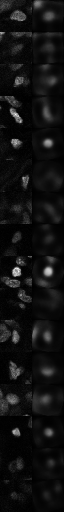

In [183]:
%matplotlib notebook
from IPython.display import Image
from IPython.core.display import Image, display
from torchvision.utils import save_image

#resume = "C:/Users/awoloshu/Documents/NephNet/saved/cd45VAE_3dmask/0113_095248/checkpoint-epoch500.pth"
resume = "C:/Users/awoloshu/Documents/NephNet/saved/cd45VAE/0113_132807/checkpoint-epoch500.pth"
checkpoint = torch.load(resume)
model.load_state_dict(checkpoint['state_dict'])

def compare(x):
    s = nn.Sigmoid()
    recon_x, _, _ = model(x)
    img = torch.squeeze(x)[:,3,:,:]
    print(img.shape)
    print(recon_x.cpu().detach().numpy().shape)
    if recon_x.cpu().detach().numpy().shape[2] == 1:
        recon_img = torch.squeeze(recon_x)
    else:
        recon_img = torch.squeeze(recon_x)[:,3,:,:]
        print(recon_img.shape)
    return torch.cat([img, recon_img], 2)

data_loader = get_instance(module_data, 'data_loader_test', config)
batch, label = next(iter(data_loader))

compare_x = compare(batch.cuda())
print(compare_x.shape)
img2show = compare_x.view(compare_x.size(0)*32, 64).data.cpu()
#plt.figure( figsize=[8, 16])
#plt.imshow(img2show, cmap = 'gray')


compare_x = compare_x.view(compare_x.size(0),1, 32, 64)
#print(compare_x.shape)


save_image(img2show, 'sample_image.png')
display(Image('sample_image.png', width=700, unconfined=True))





In [190]:
#get the latent for the test images
'''
config_text = "C:/Users/awoloshu/Documents/NephNet/configs/config_VAE.json"
with open(config_text) as handle:
    config = json.load(handle)
'''
data_loader = get_instance(module_data, 'data_loader_test', config)
all_img = []
batches = []
ids = data_loader.dataset.getIds()
ids = ids.squeeze()
print(ids.shape)
model.eval()
for i in range(len(data_loader.dataset)):
    data = data_loader.dataset.__getitem__(i)[0].to(device)
    all_img.extend(data.cpu().data.detach().numpy())
    encoder = model.encoder
    batch_outputs = encoder(data)
    batches.extend( batch_outputs.cpu().data.detach().numpy())
'''    
for i, (data, label) in enumerate(data_loader):
    data = data.to(device)
    encoder = model.encoder
    batch_outputs = encoder(data)
    batches.extend( batch_outputs.cpu().data.detach().numpy())
'''
testLatent = np.asarray(batches)
testImages = np.asarray(all_img)
print(testImages.shape)
print(testLatent.shape)


(11036,)
(11036, 7, 32, 32)
(11036, 200)


Total variance explained by 3 components 0.41194847226142883
Total variance explained by 15 components 0.7885375022888184
[0 1 2 3 4]


<IPython.core.display.Javascript object>


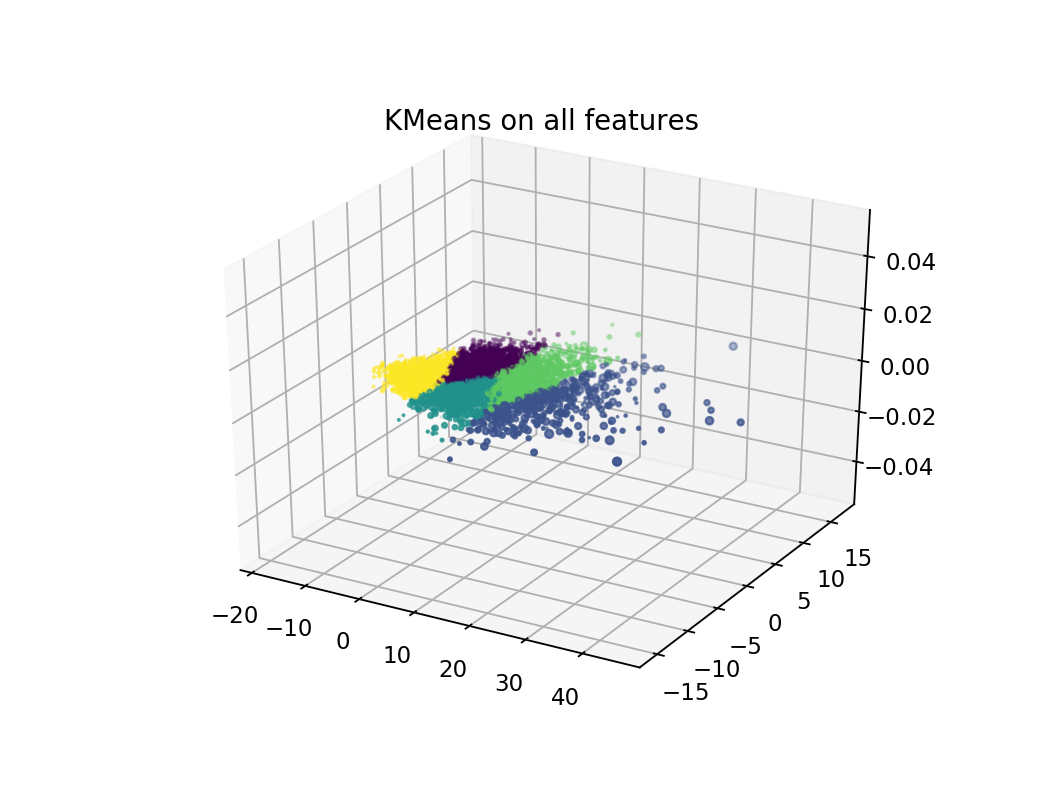

C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\matplotlib\collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


<IPython.core.display.Javascript object>


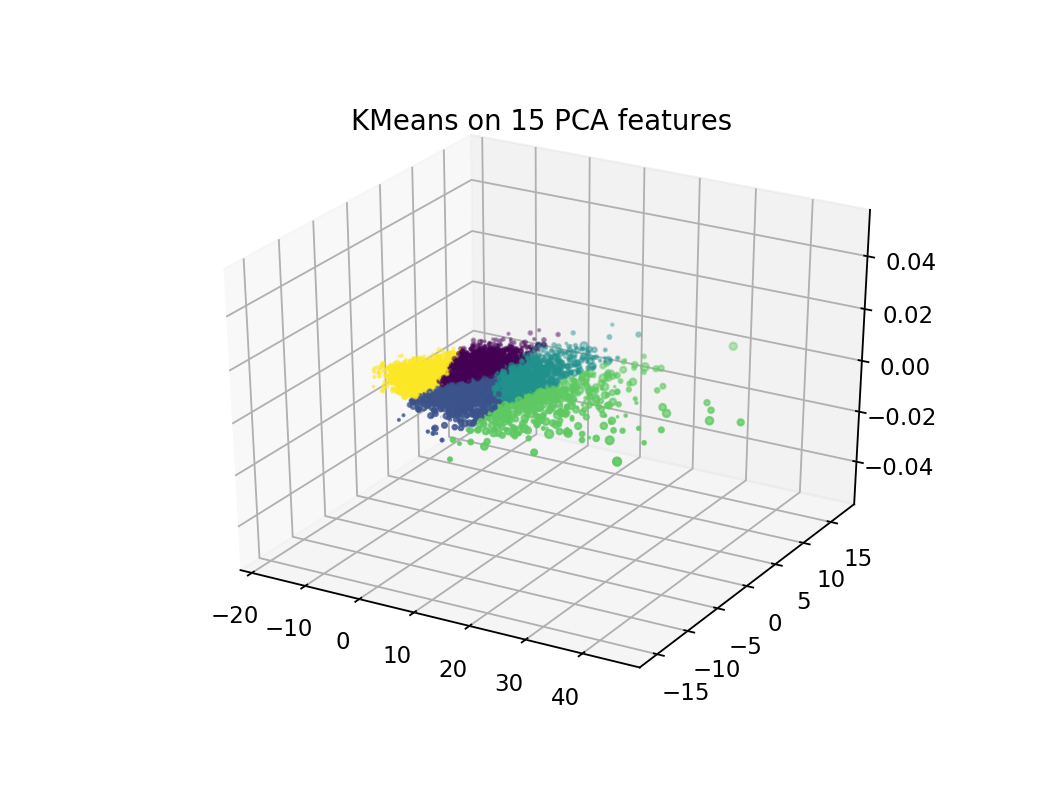

<IPython.core.display.Javascript object>


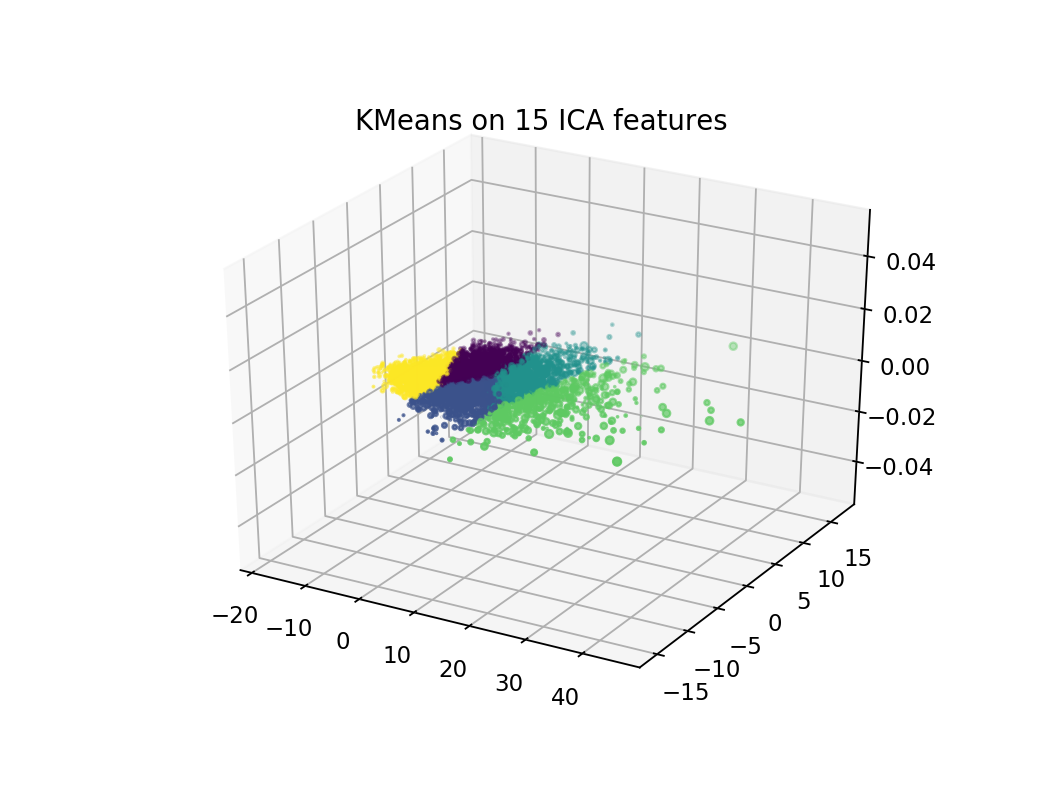

<IPython.core.display.Javascript object>


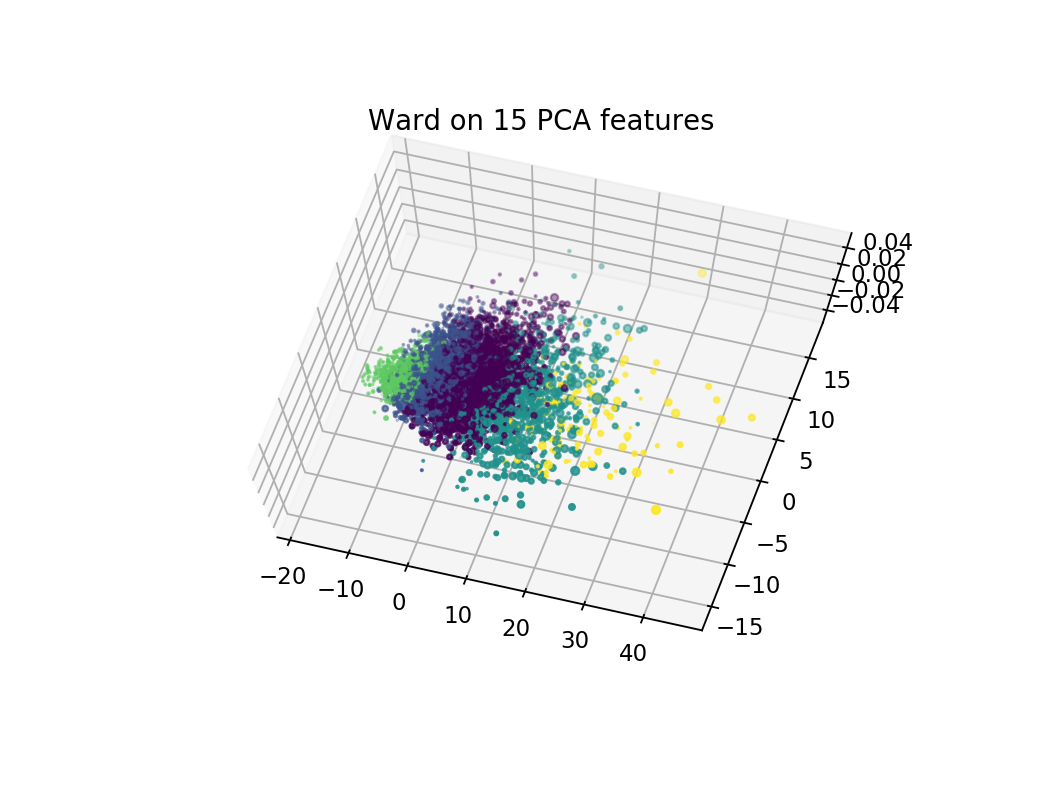

In [191]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D 

train_features = testLatent
train_features = StandardScaler().fit_transform(train_features)

# PLOTTING PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(train_features)
print("Total variance explained by 3 components {}".format(np.sum(pca.explained_variance_ratio_)))


# FEATURE PCA
pca_feat = PCA(n_components=15)
principalComponents_feat = pca_feat.fit_transform(train_features)
print("Total variance explained by 15 components {}".format(np.sum(pca_feat.explained_variance_ratio_)))

# FEATURE ICA
ica_feat = FastICA(n_components=15,random_state=0)
independentComponents_feat = pca_feat.fit_transform(train_features)

n_cluster = 5
kmeans_pred = KMeans(n_clusters=n_cluster, random_state=0).fit_predict(train_features)
kmeans_pred_feat = KMeans(n_clusters=n_cluster, random_state=0).fit_predict(principalComponents_feat)
kmeans_pred_ica = KMeans(n_clusters=n_cluster, random_state=0).fit_predict(independentComponents_feat)
ward_pred = AgglomerativeClustering(n_clusters=n_cluster, affinity='euclidean', linkage='ward').fit_predict(principalComponents_feat)

print(np.unique(kmeans_pred))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.title("KMeans on all features")
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], principalComponents[:,2], c=kmeans_pred)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.title("KMeans on 15 PCA features")
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], principalComponents[:,2], c=kmeans_pred_feat)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.title("KMeans on 15 ICA features")
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], principalComponents[:,2], c=kmeans_pred_ica)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.title("Ward on 15 PCA features")
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], principalComponents[:,2], c=ward_pred)


In [187]:
#show some examples of the cluster
#CLUSTERING MUST HAVE BEEN DONE ON NON SHUFFLED DATA
def plotExamples(cluster, all_images, label):
    pw = 10
    pl = 10
    cluster_mask = kmeans_pred == label
    cluster_imgs = all_images[cluster_mask]
    print(cluster_imgs.shape)
    id2show = np.random.choice(len(cluster_imgs), pw*pl,  replace=False)
    mydata_cluster = cluster_imgs[id2show, 3, :, :]
    '''
    for idx in id2show:
        img, _ = data_loader.dataset.__getitem__(idx)
        img = torch.squeeze(img).cpu().data.detach().numpy()
        mydata_cluster.append(img[3])
    '''
    imgs = mydata_cluster
    

    #fig, axs = plt.subplots(pl, pw, figsize=(10,10),facecolor='w', edgecolor='k')
    title = "Cluster: {}".format(label)
    plt.pause(0.1)
    fig, axs = plt.subplots(pl, pw,facecolor='w', edgecolor='k')
    plt.suptitle((title),
                 fontsize=10, fontweight='bold')
    axs = axs.ravel()
    fig.subplots_adjust(hspace = 0.05, wspace= 0.05)

    for i in range(pw*pl):
        title = "Cluster: {}".format(label)
        axs[i].imshow(imgs[i], cmap = plt.cm.gray)
        #axs[i].set_title(title, fontsize = 5)
        '''
        if labels[i] == 5:
            axs[i].spines['bottom'].set_color('red')
            axs[i].spines['top'].set_color('red')
            axs[i].spines['left'].set_color('red')
            axs[i].spines['right'].set_color('red')
        else:
            axs[i].spines['bottom'].set_color('green')
            axs[i].spines['top'].set_color('green')
            axs[i].spines['left'].set_color('green')
            axs[i].spines['right'].set_color('green')
        '''        
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        
#plotExamples(kmeans_pred, my_data, 0)

(1620, 7, 32, 32)


<IPython.core.display.Javascript object>


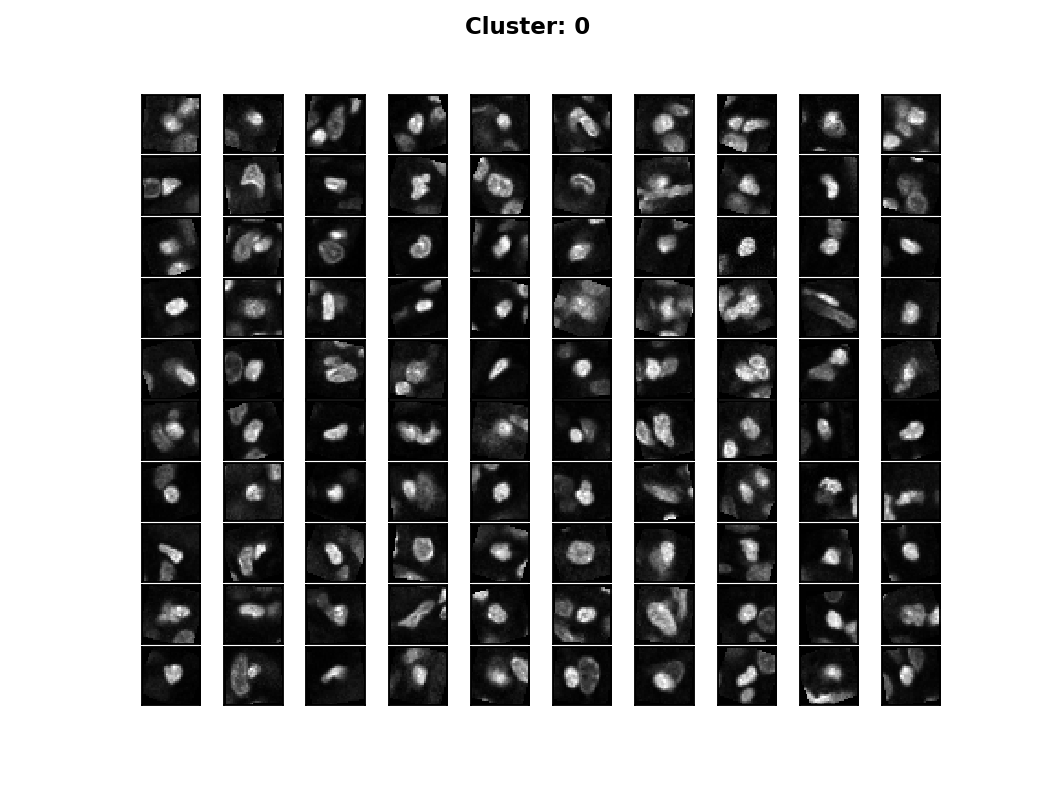

(2896, 7, 32, 32)


<IPython.core.display.Javascript object>


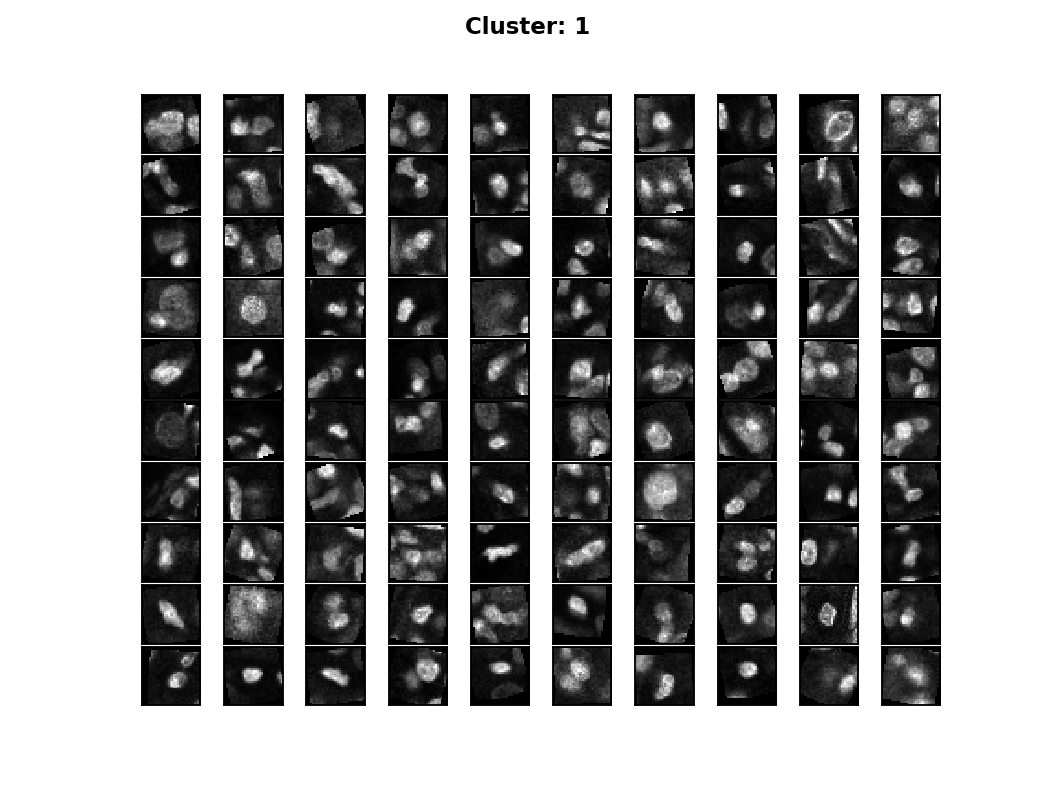

(737, 7, 32, 32)


<IPython.core.display.Javascript object>


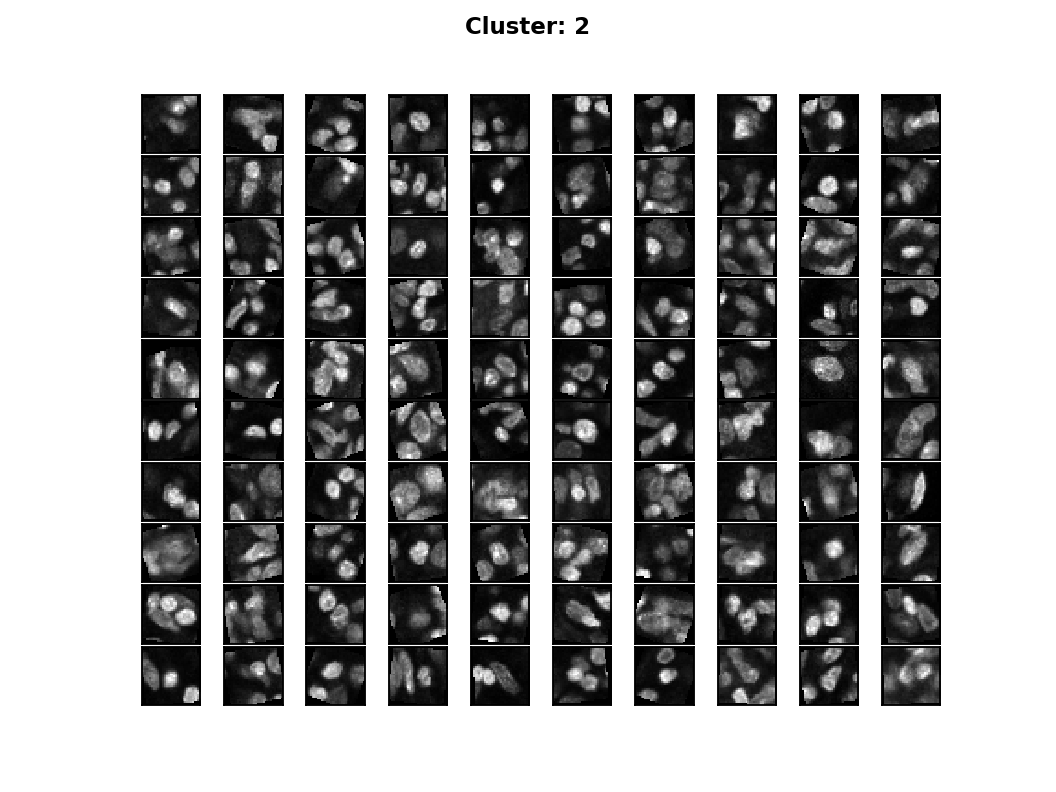

(2581, 7, 32, 32)


<IPython.core.display.Javascript object>


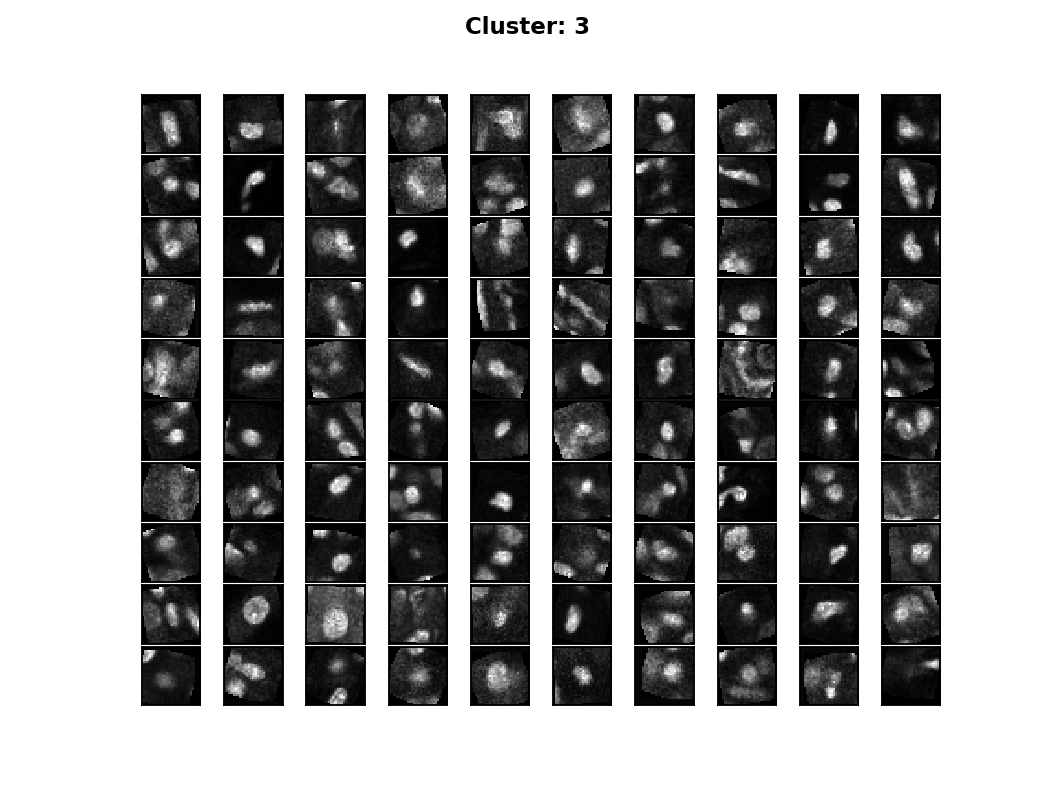

(1546, 7, 32, 32)


<IPython.core.display.Javascript object>


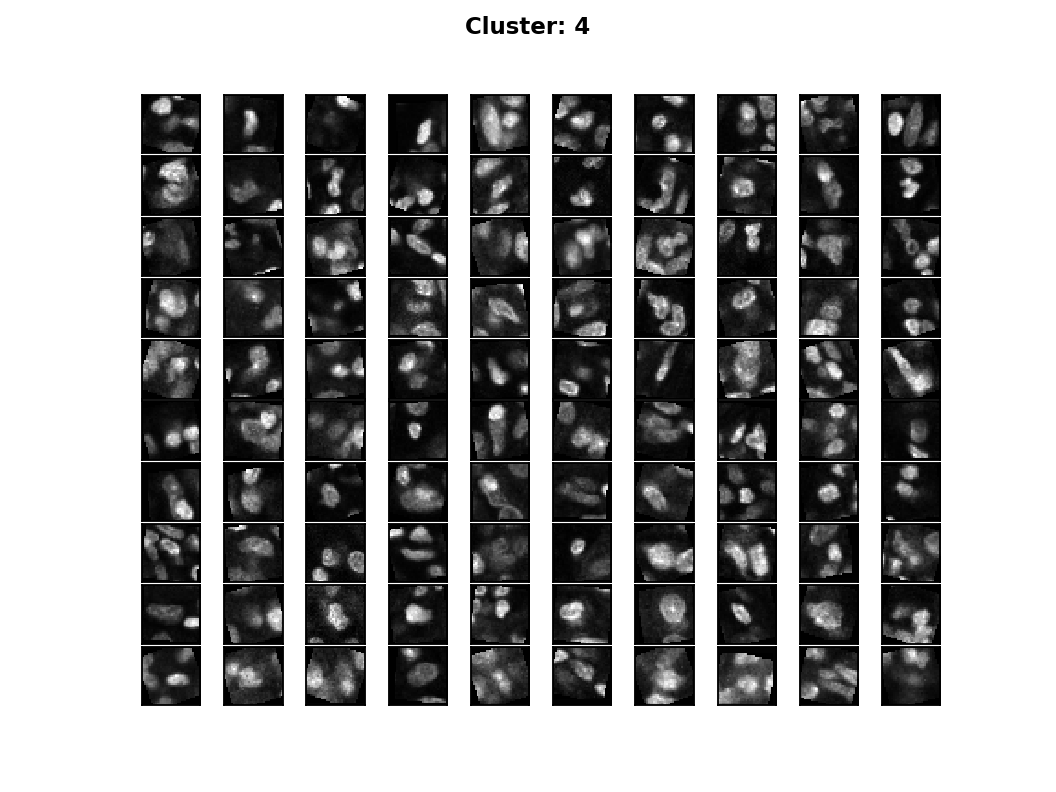

In [160]:
#ALL KMEANS

for label in np.unique(kmeans_pred):
    plotExamples(kmeans_pred, testImages, label)

(1620, 7, 32, 32)


<IPython.core.display.Javascript object>


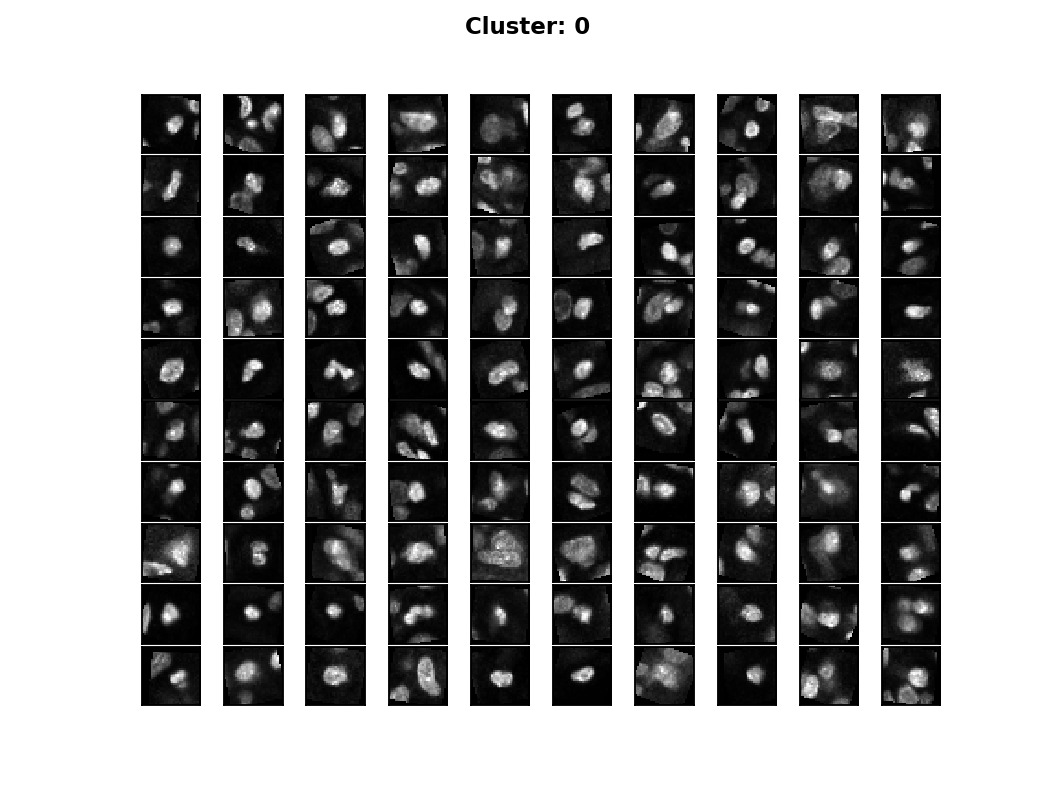

(2896, 7, 32, 32)


<IPython.core.display.Javascript object>


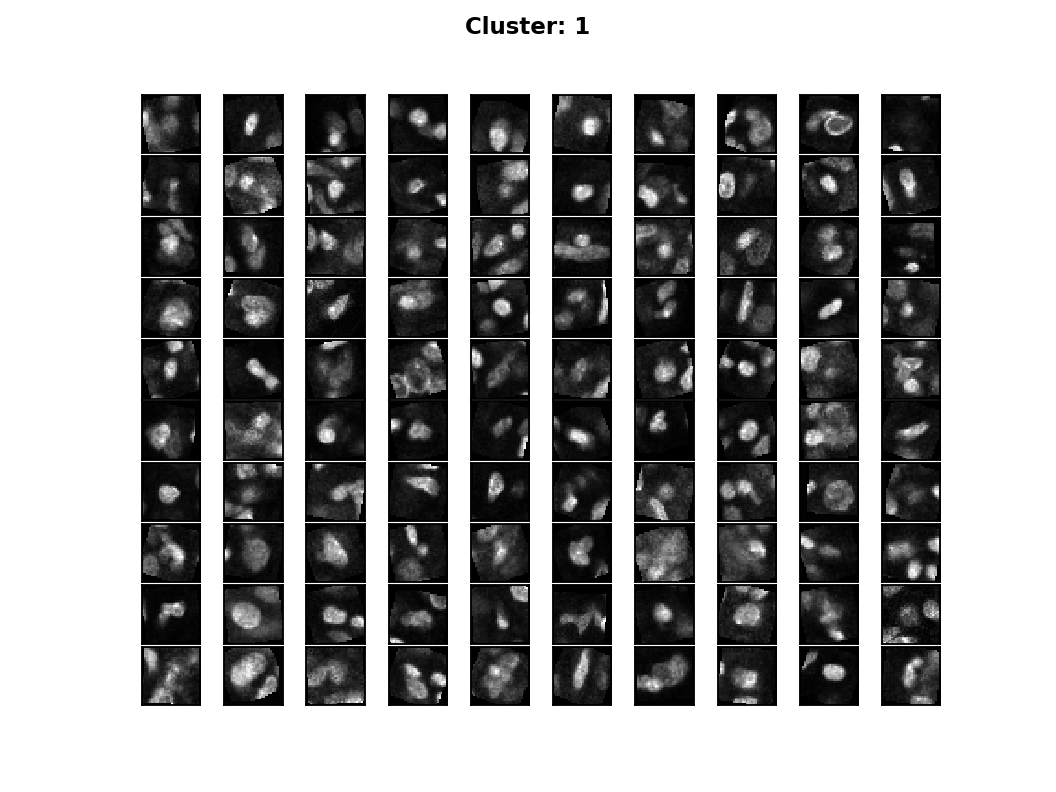

(737, 7, 32, 32)


<IPython.core.display.Javascript object>


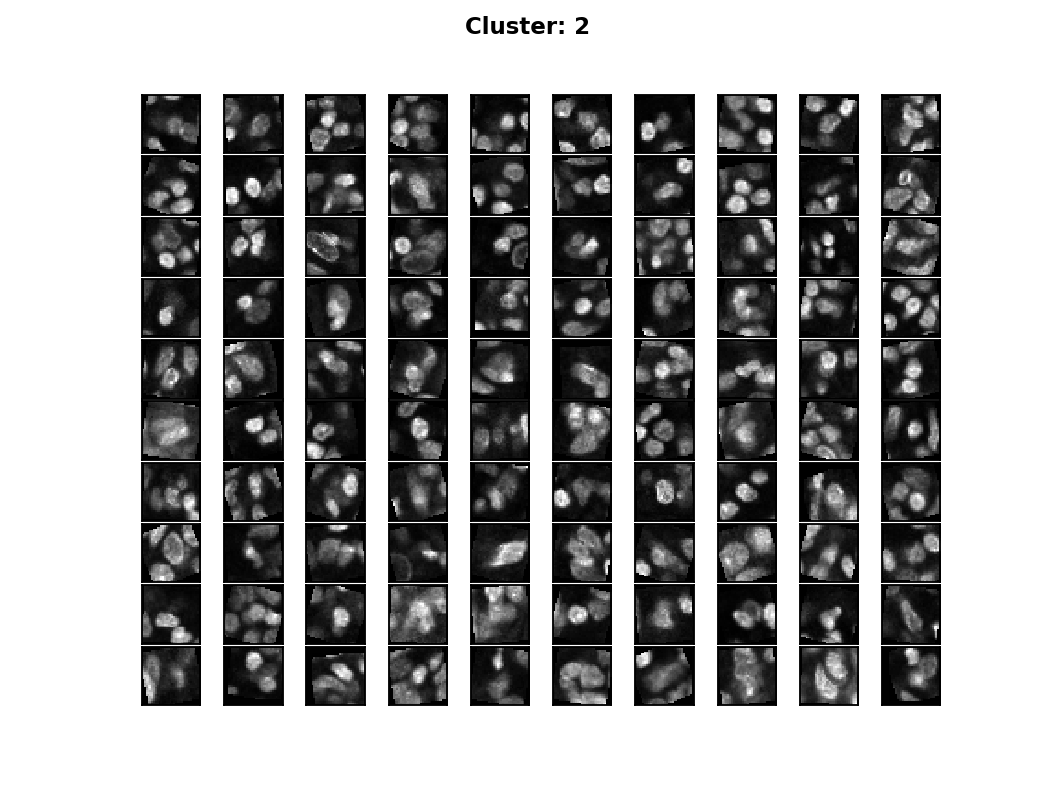

(2581, 7, 32, 32)


<IPython.core.display.Javascript object>


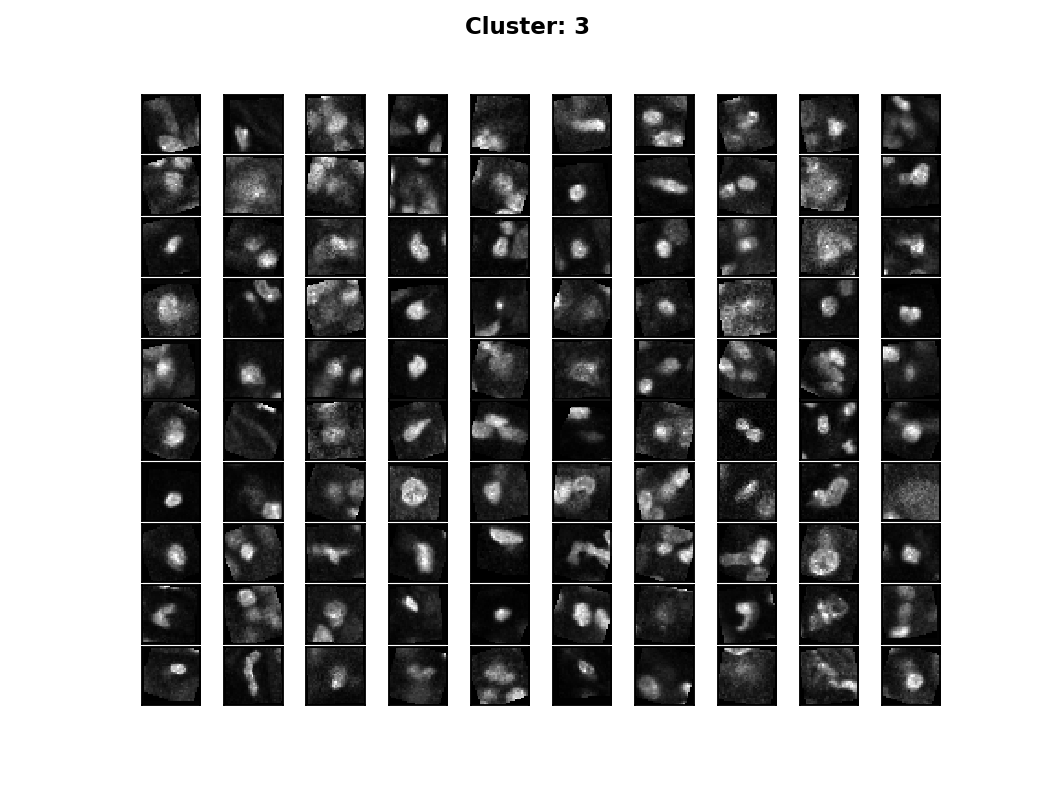

(1546, 7, 32, 32)


<IPython.core.display.Javascript object>


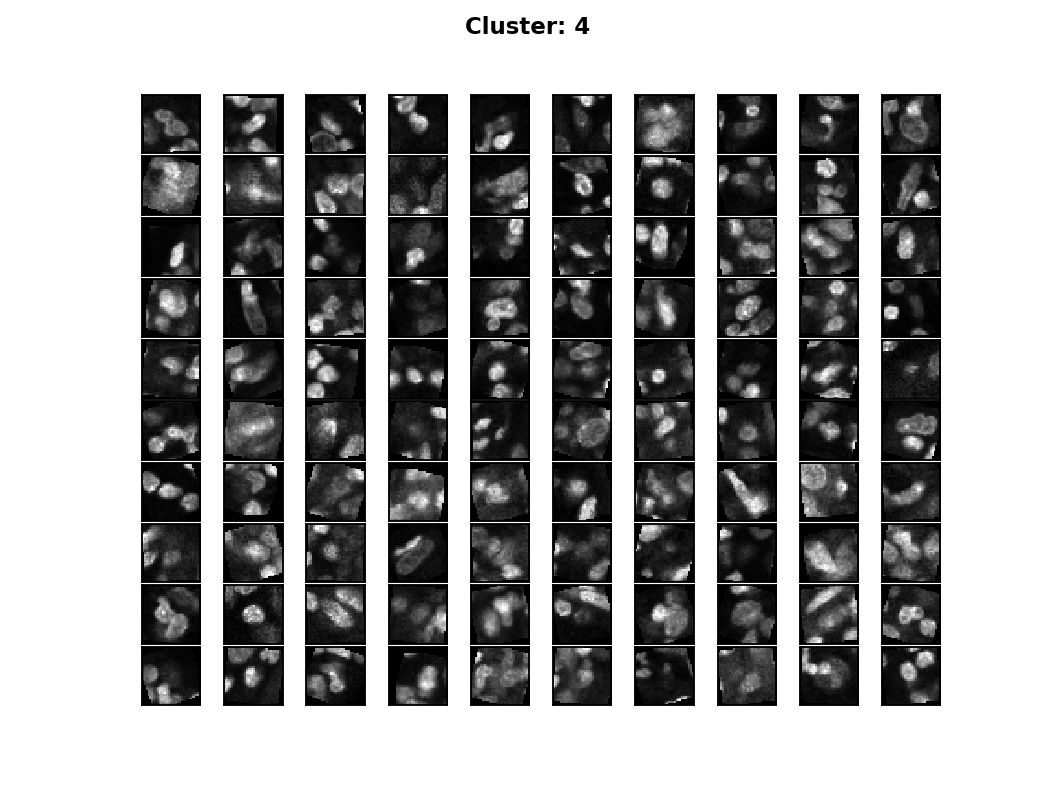

In [161]:
# PCA KMEANS

for label in np.unique(kmeans_pred_feat):
    plotExamples(kmeans_pred, testImages, label)

(1620, 7, 32, 32)


<IPython.core.display.Javascript object>


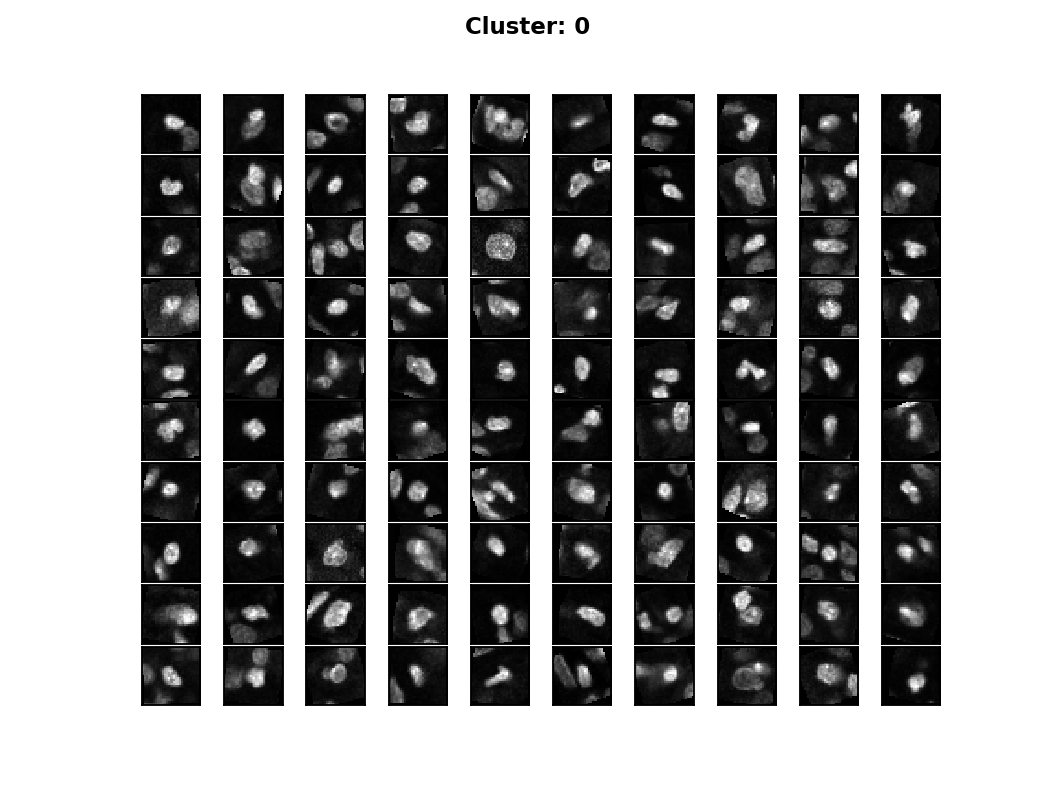

(2896, 7, 32, 32)


<IPython.core.display.Javascript object>


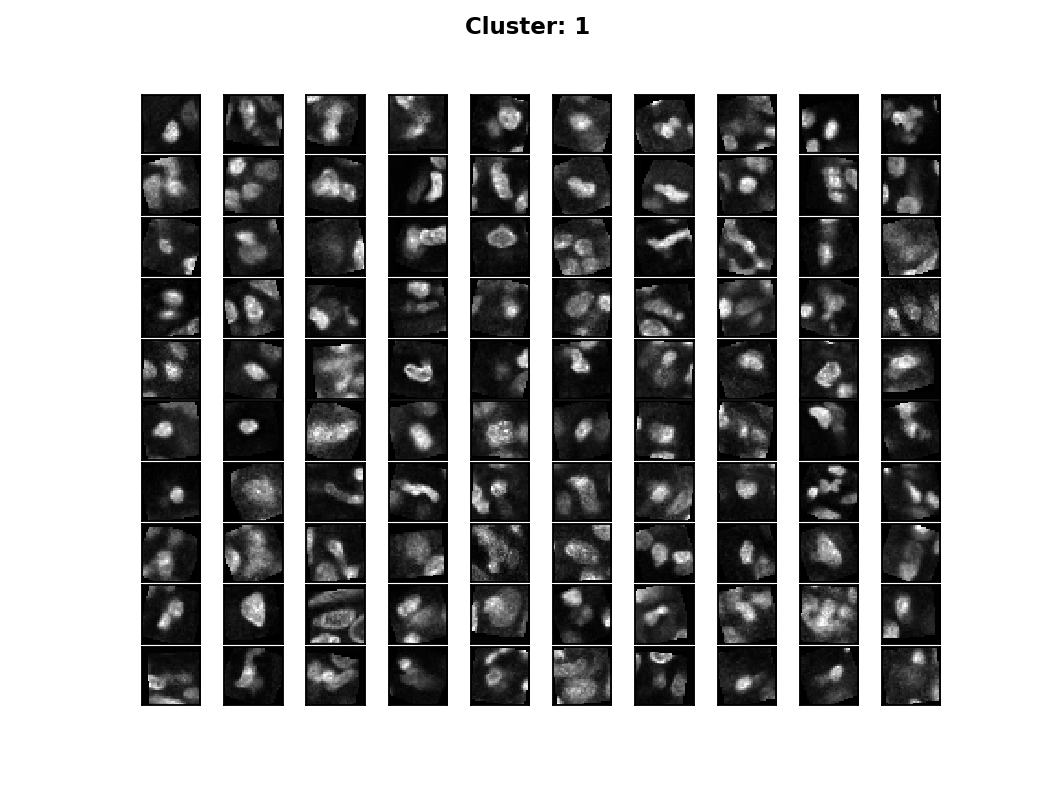

(737, 7, 32, 32)


<IPython.core.display.Javascript object>


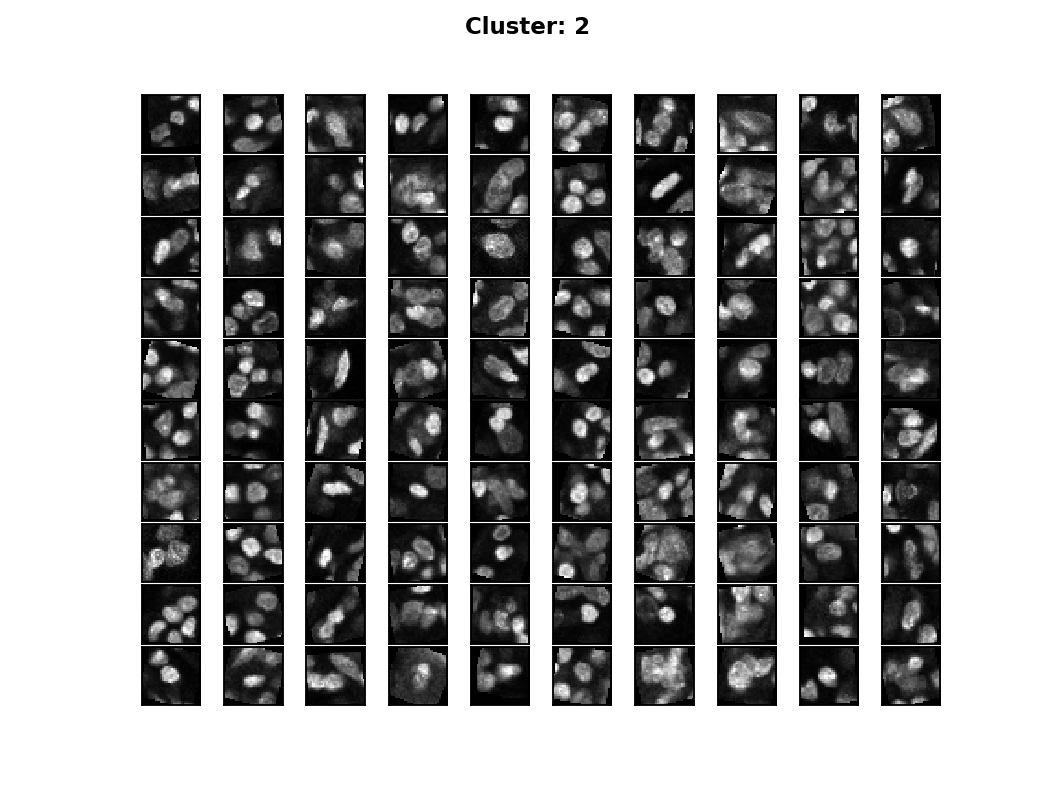

(2581, 7, 32, 32)


<IPython.core.display.Javascript object>


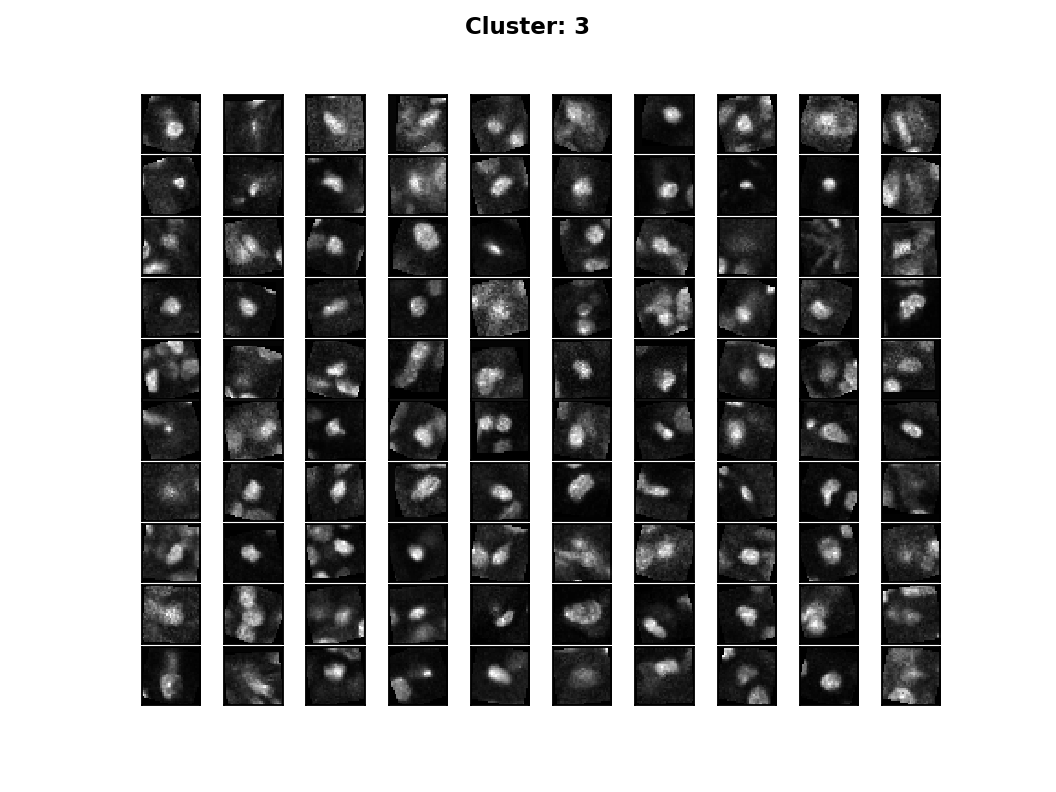

(1546, 7, 32, 32)


<IPython.core.display.Javascript object>


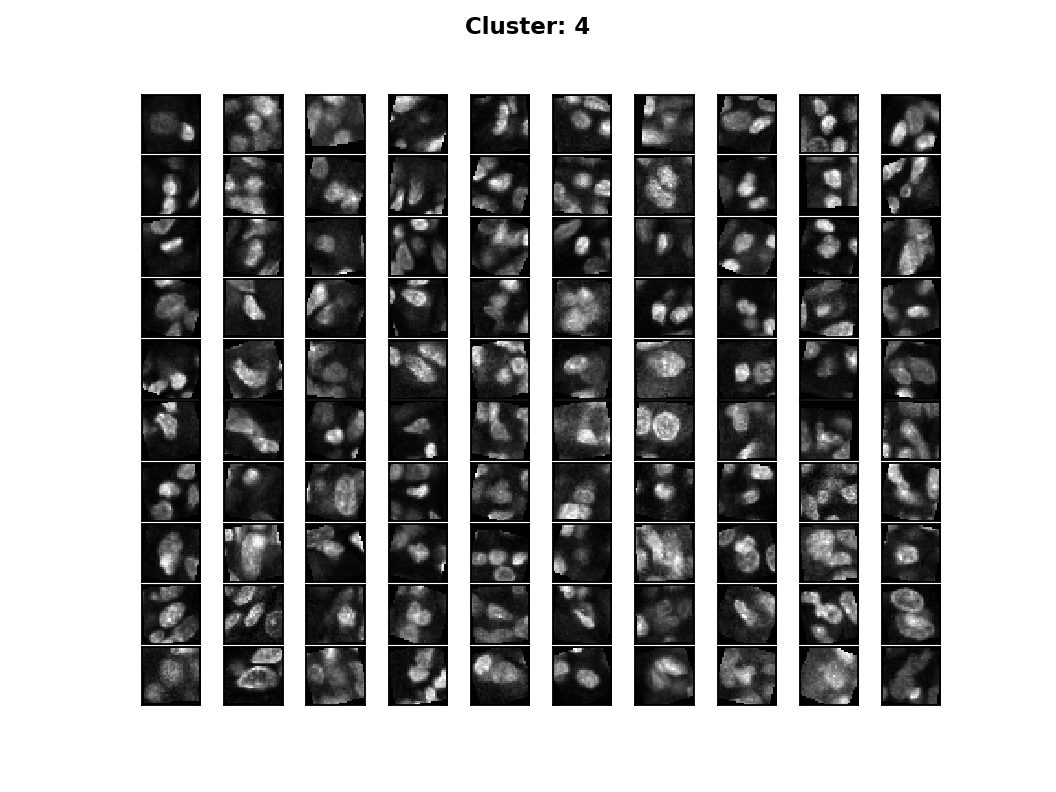

In [162]:
# KMEANS ICA

for label in np.unique(kmeans_pred_ica):
    plotExamples(kmeans_pred, testImages, label)

(2699, 7, 32, 32)


<IPython.core.display.Javascript object>


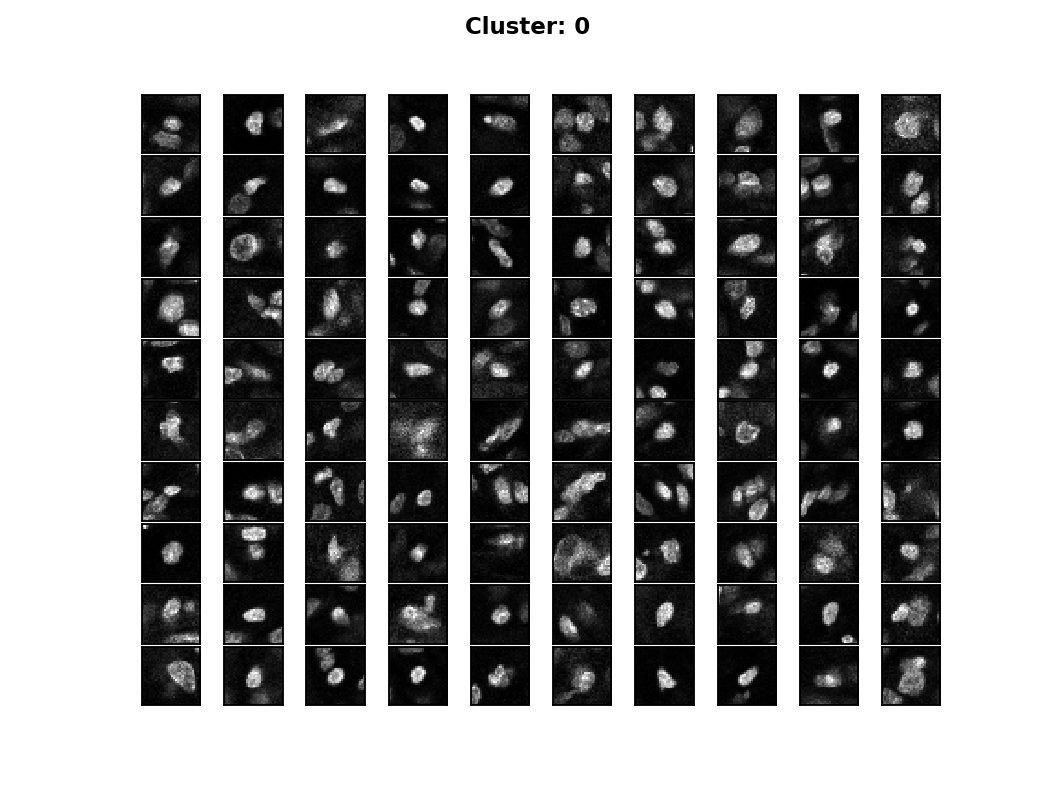

(950, 7, 32, 32)


<IPython.core.display.Javascript object>


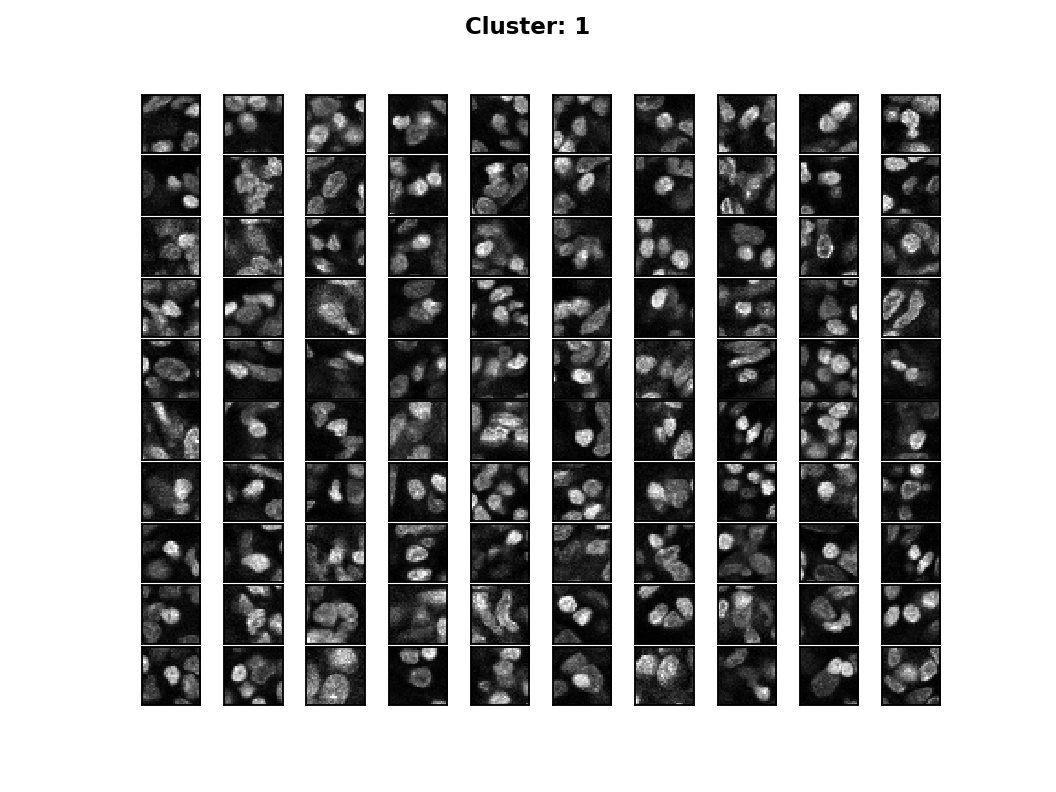

(2226, 7, 32, 32)


<IPython.core.display.Javascript object>


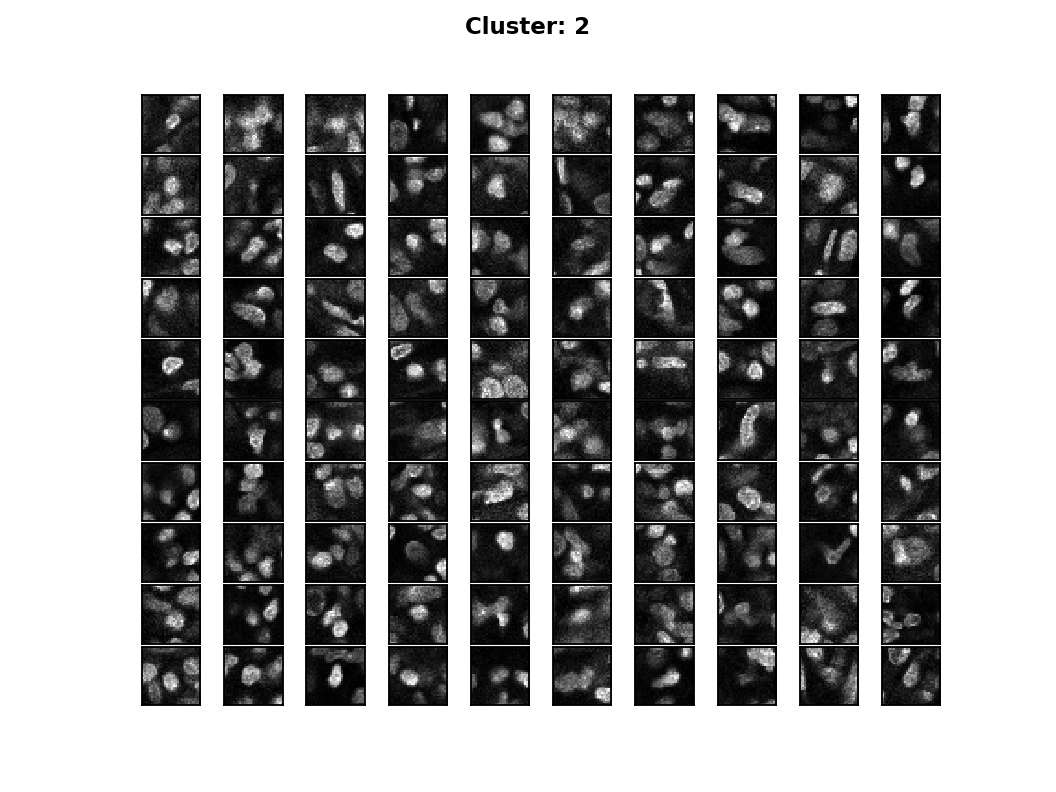

(1744, 7, 32, 32)


<IPython.core.display.Javascript object>


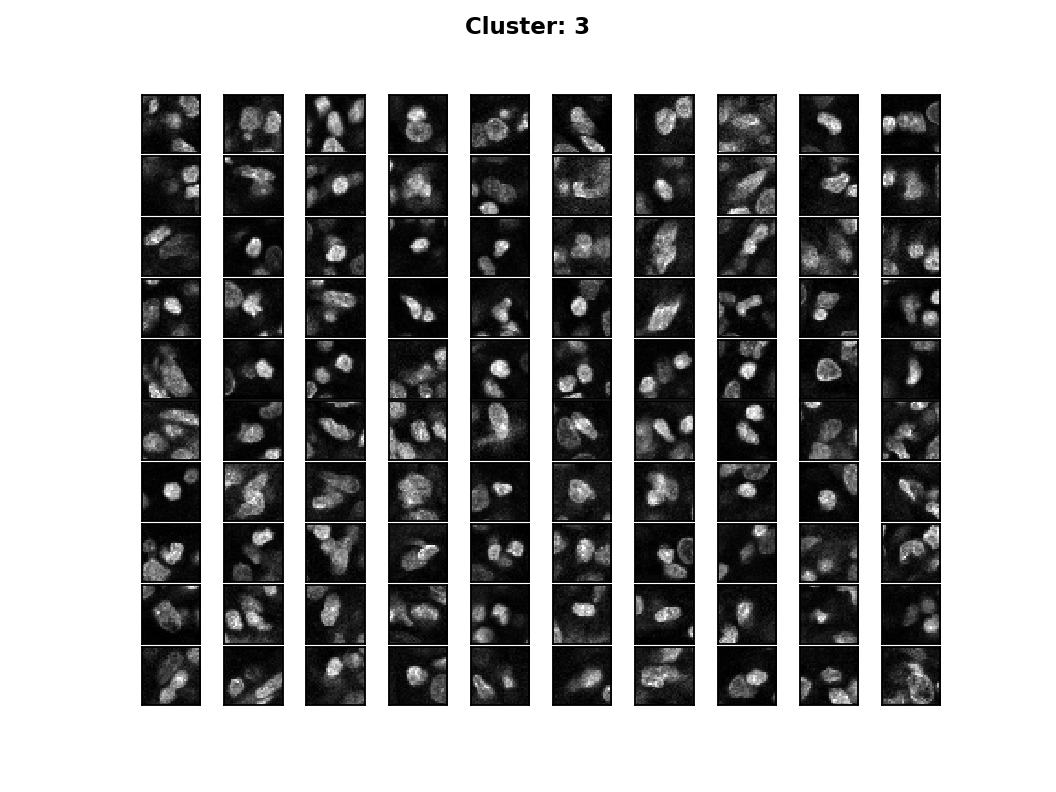

(3417, 7, 32, 32)


<IPython.core.display.Javascript object>


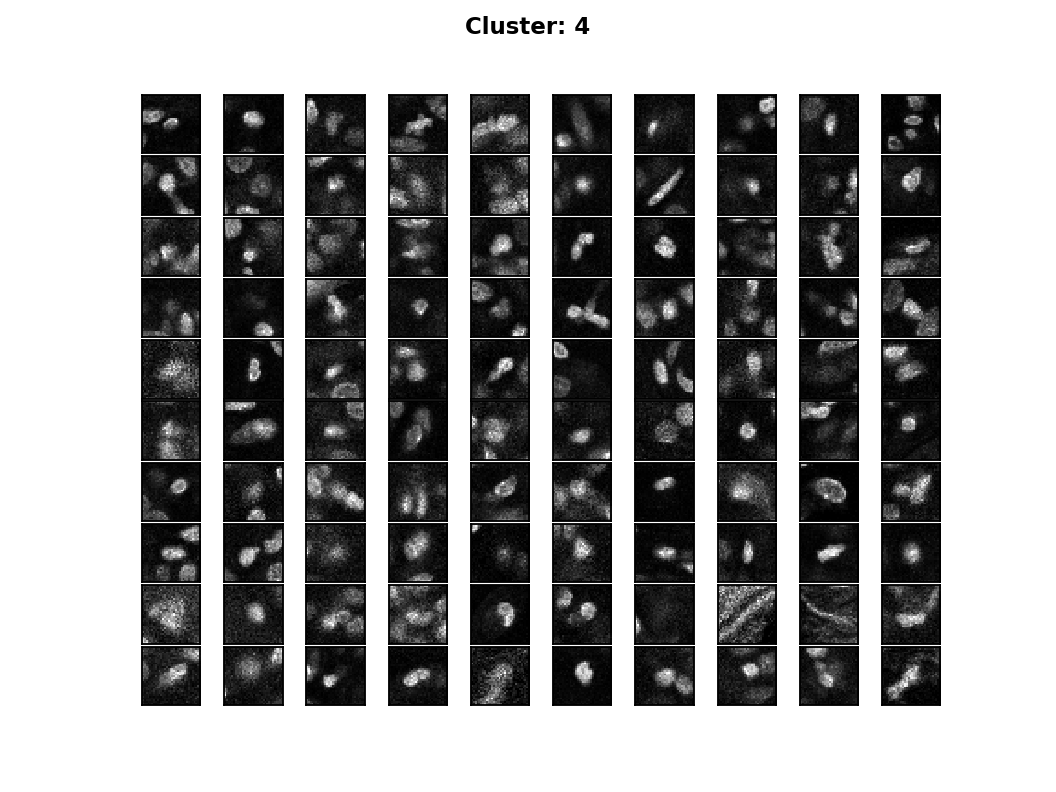

In [192]:
# WARD PCA

for label in np.unique(ward_pred):
    plotExamples(ward_pred, testImages, label)

In [231]:
#CONVERT WARD PREDICTIONS TO CSV FILE FOR CD45
#REMAKE F33 TRAINING DATASET WITH ~13 CLASSES
#TEST ON F44 
print(ids.shape)
print(ward_pred.shape)

cluster_reassigned = np.zeros_like(ward_pred)
new_labels = [6,10,11,12,13]
for i, cluster in enumerate(ward_pred):
    new_label = new_labels[cluster]
    cluster_reassigned[i] = new_label
    

id_cluster = list(zip(cluster_reassigned, ids))
print(id_cluster[:5])
print(id_cluster[1][1])
print(ids[:10])

(11036,)
(11036,)
[(6, 324606), (6, 283902), (10, 109526), (6, 115788), (10, 315608)]
283902
[324606 283902 109526 115788 315608 165105 268418 183746 209140 295311]


In [211]:
import csv
mycsv = "C:/Users/awoloshu/Desktop/datasets/NephNet/3d_all/cd45_vae/f33_cd45.csv"

r = csv.reader(open(mycsv))
lines = list(r)


C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


(array([], dtype=int64),)


TypeError: list indices must be integers or slices, not tuple

In [240]:
all_changes = []

for line in lines:
    myid = line[1]  
    myid_idx=np.where(ids == int(myid))
    if myid_idx[0]:
        found = myid_idx[0][0]
        new_label = id_cluster[found][0]
        line[0] = new_label
        all_changes.append(new_label)
print(np.unique(all_changes))        
mycsv_out = mycsv.split('.')[0] + "_relabeled1.csv"
print(mycsv_out)


with open(mycsv_out, 'w', newline='') as outfile:
    writer = csv.writer(outfile)
    writer.writerows(lines)
        
print("Finished writing")

[ 6 10 11 12 13]
C:/Users/awoloshu/Desktop/datasets/NephNet/3d_all/cd45_vae/f33_cd45_relabeled1.csv
Finished writing
